In [4]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.utils import resample
from sklearn.metrics import r2_score, ndcg_score
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr


In [6]:
ALL_AAS = ("A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y")

In [9]:
class GB1XDataset(Dataset):
    
    def __init__(self, file_path):
        full_sequence = False
        
        self.data = pd.read_csv(file_path)
        self.data['num_muts'] = self.data['Combo'].apply(self.diff_letters)

        #only select variants with 2 or less mutations
        #self.data = self.data[self.data['num_muts'] <= 2]
        
        self.all_combos = self.data["Combo"]
        if full_sequence:
            self.all_combos = self.all_combos.apply(self.generate_full) #need to fix this
        self.n_positions_combined = len(self.all_combos[0])

        self.X = torch.tensor(self._generate_onehot()).float()
        self.attributes = self.data[["EvMutation", "Triad-FixedBb-dG", "esm_msa1_t12_100M_UR50S-Conditional-ColumnUnmasked"]].values 
        scaler = StandardScaler()
        self.attributes = scaler.fit_transform(self.attributes)
        # , "esm_msa1_t12_100M_UR50S-Naive-ColumnUnmasked" ,	"esm_msa1_t12_100M_UR50S-Conditional-ColumnUnmasked", "esm_msa1_t12_100M_UR50S-Naive-ColumnMasked", "esm_msa1_t12_100M_UR50S-Conditional-ColumnMasked"]].values
        #"Triad-FlexibleBb-dG", "Triad-FlexibleBb-RMSD"
        self.y = self.data["Fitness"].values

    #function that generates onehot encodings
    def _generate_onehot(self):
        """
        Builds a onehot encoding for a given combinatorial space.
        """
        # Make a dictionary that links amino acid to index
        one_hot_dict = {aa: i for i, aa in enumerate(ALL_AAS)}
    
        # Build an array of zeros
        onehot_array = np.zeros([len(self.all_combos), self.n_positions_combined, 20])
        
        # Loop over all combos. This should all be vectorized at some point.
        for i, combo in enumerate(self.all_combos):
            
            # Loop over the combo and add ones as appropriate
            for j, character in enumerate(combo):
                
                # Add a 1 to the appropriate position
                onehot_ind = one_hot_dict[character]
                onehot_array[i, j, onehot_ind] = 1
                
        # Return the flattened array
        return onehot_array.reshape(onehot_array.shape[0],-1)
    
    @staticmethod
    def diff_letters(a, b = 'VDGV'):
        return sum ( a[i] != b[i] for i in range(len(a)) )

    @staticmethod
    def generate_full(combo):
        seq = "MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE"
        seq = seq[:38] + combo[0] + combo[1] + combo[2] + seq[41:53] + combo[3] + seq[54:]
        return seq
          
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):            
        return self.X[index], self.attributes[index]

In [10]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
#torch.cuda.device_count()
cuda0 = torch.cuda.set_device(0)

# Hyper-parameters
input_dim = 80 #initial dimension
h_dim1 = 64 #hidden layer dimension 1
h_dim2 = 32 #hidden layer dimension 2
z_dim = 16 #embedding dimension
num_epochs = 20
attr_dim = 3 #number of attributes to decode

#h_dim1 = 512 #hidden layer dimension 1
#h_dim2 = 256 #hidden layer dimension 2
#z_dim = 128 #embedding dimension


batch_size = 128
learning_rate = 1e-3
variational = False #if True, trains a variational autoencoder instead of an autoencoder

# GB1 dataset
dataset = GB1XDataset('./data/AllPredictions.csv')
input_dim = dataset.n_positions_combined*20 #initial dimension

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

# VAE/AE model
class ProtTP(nn.Module):
    def __init__(self, input_dim=80, h_dim1=64, h_dim2=32, z_dim=16, variational=False):
        super(ProtTP, self).__init__()

        #encoder layers
        self.fce1 = nn.Linear(input_dim, h_dim1)
        self.fce2 = nn.Linear(h_dim1, h_dim2)
        self.fce3 = nn.Linear(h_dim2, z_dim)
        self.fcvar = nn.Linear(h_dim2, z_dim)
        
        #decoder layers
        self.fcd1 = nn.Linear(z_dim, h_dim2)
        self.fcd2 = nn.Linear(h_dim2, h_dim1)
        self.fcd3 = nn.Linear(h_dim1, input_dim)

        #attribute decoder layers
        self.fcad1 = nn.Linear(z_dim, z_dim)
        self.fcad2 = nn.Linear(z_dim, attr_dim)
        
    def encode(self, x):
        h1 = F.relu(self.fce1(x))
        h2 = F.relu(self.fce2(h1))
        if variational:
            return self.fce3(h2), self.fcvar(h2)
        else:
            return self.fce3(h2)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h1 = F.relu(self.fcd1(z))
        h2 = F.relu(self.fcd2(h1))
        return torch.softmax(self.fcd3(h2))
    
    def decode_attr(self, z):
        h1 = F.relu(self.fcad1(z))
        return self.fcad1(z)

    def forward(self, x):
        if variational:
            mu, log_var = self.encode(x)
            z = self.reparameterize(mu, log_var)
            x_reconst = self.decode(z)
            return x_reconst, mu, log_var
        else:
            z = self.encode(x)
            x_reconst = self.decode(z)
            return x_reconst, z
        
model = ProtTP(input_dim=input_dim, h_dim1=h_dim1, h_dim2=h_dim2, z_dim=z_dim, variational=variational).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cuda


In [32]:
# Start training
best_loss = 0
for epoch in range(num_epochs):
    for i, (x, a) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, input_dim)

        if variational:
            x_reconst, mu, log_var = model(x)
            kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) 
        else:
            x_reconst, z = model(x)
            kl_div = 0
        
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        loss = reconst_loss + kl_div
        
        # Backprop and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 1167 == 0:
            if variational:
                print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                    .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))
            else:
                print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}"
                    .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()))
    
    #update the best model after each epoch
    if epoch == 0 or loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), 'best_AE.pth')
        print('Best model saved')

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/20], Step [1167/1167], Reconst Loss: 1284.5219
Best model saved
Epoch[2/20], Step [1167/1167], Reconst Loss: 732.3413
Best model saved
Epoch[3/20], Step [1167/1167], Reconst Loss: 221.9527
Best model saved
Epoch[4/20], Step [1167/1167], Reconst Loss: 11.9499
Best model saved
Epoch[5/20], Step [1167/1167], Reconst Loss: 1.8023
Best model saved
Epoch[6/20], Step [1167/1167], Reconst Loss: 0.8124
Best model saved
Epoch[7/20], Step [1167/1167], Reconst Loss: 0.4150
Best model saved
Epoch[8/20], Step [1167/1167], Reconst Loss: 0.2236
Best model saved
Epoch[9/20], Step [1167/1167], Reconst Loss: 0.1603
Best model saved
Epoch[10/20], Step [1167/1167], Reconst Loss: 0.2346
Epoch[11/20], Step [1167/1167], Reconst Loss: 0.1063
Best model saved
Epoch[12/20], Step [1167/1167], Reconst Loss: 0.0814
Best model saved
Epoch[13/20], Step [1167/1167], Reconst Loss: 0.0711
Best model saved
Epoch[14/20], Step [1167/1167], Reconst Loss: 0.0386
Best model saved
Epoch[15/20], Step [1167/1167], Recons

In [11]:
#Get embeddings
model.load_state_dict(torch.load('best_AE.pth'))

with torch.no_grad():
    X = dataset.X.to(device)
    if variational:
        mu, log_var = model.encode(X)
        embeddings = model.reparameterize(mu, log_var)
    else:
        embeddings = model.encode(X)
    reconstructions = model.decode(embeddings)

In [55]:
model_params = {"booster": "gbtree",
                      "tree_method": "exact",
                      "nthread": 1,
                      "verbosity": 0,
                      "objective": "reg:tweedie",
                      "tweedie_variance_power": 1.5,
                      "eval_metric": "tweedie-nloglik@1.5"}

# model_params = {"booster": "gblinear",
#                       "tree_method": "exact",
#                       "nthread": 1,
#                       "verbosity": 0,
#                       "objective": "reg:tweedie",
#                       "tweedie_variance_power": 1.5,
#                       "eval_metric": "tweedie-nloglik@1.5"}

In [56]:
#downstream supervised regression
N_models = 100
N_train_samples = 384
N_test_samples = 32
alpha = 1
linear = False

X_baseline = np.array(dataset.X)
X_OHembed = np.concatenate((np.array(dataset.X), np.array(embeddings.cpu())), axis=1)
#X_OHembed = np.array(embeddings.cpu())
X_zs = np.concatenate((np.array(dataset.X), np.array(dataset.attributes)), axis=1)
#X_zs = np.array(dataset.attributes)

inputs = [X_baseline, X_OHembed, X_zs]
#inputs = [X_baseline, X_zs]

results = np.zeros((N_models, len(inputs)*2))
for j, X in enumerate(inputs):
    #scaler = StandardScaler()
    #X = scaler.fit_transform(X)
    y = dataset.y

    X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    for i in range(N_models):
        X_train, y_train = resample(X_train_all, y_train_all, n_samples=N_train_samples)
        #only run this line if you wish to use a different test size
        #X_test, y_test = resample(X, y, n_samples=N_test_samples)
        
        if linear:
            clf = Ridge(alpha=alpha)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
        else:
            train_matrix = xgb.DMatrix(X_train, label = y_train)
            test_matrix = xgb.DMatrix(X_test, label = y_test)
            evallist = [(train_matrix, "train"),
                    (test_matrix, "test")]
            clf = xgb.train(model_params, train_matrix, evals=evallist)
            best = clf.best_ntree_limit
            y_pred_test = clf.predict(xgb.DMatrix(X_test), ntree_limit = best)
        
        results[i, j] = ndcg_score([y_test], [y_pred_test])
        results[i, 3+j] = spearmanr(y_test, y_pred_test)[0]

[0]	train-tweedie-nloglik@1.5:1.32695	test-tweedie-nloglik@1.5:1.35240
[1]	train-tweedie-nloglik@1.5:1.10499	test-tweedie-nloglik@1.5:1.16647
[2]	train-tweedie-nloglik@1.5:0.94988	test-tweedie-nloglik@1.5:1.04833
[3]	train-tweedie-nloglik@1.5:0.84223	test-tweedie-nloglik@1.5:0.97775
[4]	train-tweedie-nloglik@1.5:0.76942	test-tweedie-nloglik@1.5:0.95546
[5]	train-tweedie-nloglik@1.5:0.71459	test-tweedie-nloglik@1.5:0.94715
[6]	train-tweedie-nloglik@1.5:0.68211	test-tweedie-nloglik@1.5:0.94086
[7]	train-tweedie-nloglik@1.5:0.65990	test-tweedie-nloglik@1.5:0.94400
[8]	train-tweedie-nloglik@1.5:0.64273	test-tweedie-nloglik@1.5:0.95237
[9]	train-tweedie-nloglik@1.5:0.63249	test-tweedie-nloglik@1.5:0.96110
[0]	train-tweedie-nloglik@1.5:1.35569	test-tweedie-nloglik@1.5:1.35588
[1]	train-tweedie-nloglik@1.5:1.12471	test-tweedie-nloglik@1.5:1.17430
[2]	train-tweedie-nloglik@1.5:0.96304	test-tweedie-nloglik@1.5:1.06504
[3]	train-tweedie-nloglik@1.5:0.84566	test-tweedie-nloglik@1.5:0.99753
[4]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.64119	test-tweedie-nloglik@1.5:0.95859
[8]	train-tweedie-nloglik@1.5:0.62478	test-tweedie-nloglik@1.5:0.95620
[9]	train-tweedie-nloglik@1.5:0.61367	test-tweedie-nloglik@1.5:0.97964
[0]	train-tweedie-nloglik@1.5:1.28683	test-tweedie-nloglik@1.5:1.34370
[1]	train-tweedie-nloglik@1.5:1.05470	test-tweedie-nloglik@1.5:1.15266
[2]	train-tweedie-nloglik@1.5:0.88682	test-tweedie-nloglik@1.5:1.03191
[3]	train-tweedie-nloglik@1.5:0.77292	test-tweedie-nloglik@1.5:0.95999
[4]	train-tweedie-nloglik@1.5:0.68878	test-tweedie-nloglik@1.5:0.93554
[5]	train-tweedie-nloglik@1.5:0.63354	test-tweedie-nloglik@1.5:0.94041
[6]	train-tweedie-nloglik@1.5:0.59794	test-tweedie-nloglik@1.5:0.95782
[7]	train-tweedie-nloglik@1.5:0.57521	test-tweedie-nloglik@1.5:0.98699
[8]	train-tweedie-nloglik@1.5:0.56130	test-tweedie-nloglik@1.5:1.01718
[9]	train-tweedie-nloglik@1.5:0.55192	test-tweedie-nloglik@1.5:1.05225
[0]	train-tweedie-nloglik@1.5:1.42241	test-tweedie-nloglik@1.5:1.36253
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.75880	test-tweedie-nloglik@1.5:0.91080
[7]	train-tweedie-nloglik@1.5:0.73458	test-tweedie-nloglik@1.5:0.90332
[8]	train-tweedie-nloglik@1.5:0.72319	test-tweedie-nloglik@1.5:0.90357
[9]	train-tweedie-nloglik@1.5:0.71190	test-tweedie-nloglik@1.5:0.90283
[0]	train-tweedie-nloglik@1.5:1.36388	test-tweedie-nloglik@1.5:1.35522
[1]	train-tweedie-nloglik@1.5:1.13455	test-tweedie-nloglik@1.5:1.17436
[2]	train-tweedie-nloglik@1.5:0.97236	test-tweedie-nloglik@1.5:1.06920
[3]	train-tweedie-nloglik@1.5:0.85871	test-tweedie-nloglik@1.5:1.00914
[4]	train-tweedie-nloglik@1.5:0.77697	test-tweedie-nloglik@1.5:0.97643
[5]	train-tweedie-nloglik@1.5:0.72032	test-tweedie-nloglik@1.5:0.98651
[6]	train-tweedie-nloglik@1.5:0.68396	test-tweedie-nloglik@1.5:1.02518
[7]	train-tweedie-nloglik@1.5:0.66229	test-tweedie-nloglik@1.5:1.05957
[8]	train-tweedie-nloglik@1.5:0.64587	test-tweedie-nloglik@1.5:1.07835
[9]	train-tweedie-nloglik@1.5:0.63730	test-tweedie-nloglik@1.5:1.08822
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.66795	test-tweedie-nloglik@1.5:0.94895
[8]	train-tweedie-nloglik@1.5:0.64901	test-tweedie-nloglik@1.5:0.97313
[9]	train-tweedie-nloglik@1.5:0.63645	test-tweedie-nloglik@1.5:0.98660
[0]	train-tweedie-nloglik@1.5:1.27353	test-tweedie-nloglik@1.5:1.35336
[1]	train-tweedie-nloglik@1.5:1.04225	test-tweedie-nloglik@1.5:1.17117
[2]	train-tweedie-nloglik@1.5:0.87944	test-tweedie-nloglik@1.5:1.06350
[3]	train-tweedie-nloglik@1.5:0.76755	test-tweedie-nloglik@1.5:0.99673
[4]	train-tweedie-nloglik@1.5:0.69164	test-tweedie-nloglik@1.5:0.98064
[5]	train-tweedie-nloglik@1.5:0.63924	test-tweedie-nloglik@1.5:0.96686
[6]	train-tweedie-nloglik@1.5:0.60574	test-tweedie-nloglik@1.5:0.98189
[7]	train-tweedie-nloglik@1.5:0.58369	test-tweedie-nloglik@1.5:1.00983
[8]	train-tweedie-nloglik@1.5:0.56968	test-tweedie-nloglik@1.5:1.02080
[9]	train-tweedie-nloglik@1.5:0.56113	test-tweedie-nloglik@1.5:1.03942
[0]	train-tweedie-nloglik@1.5:1.29666	test-tweedie-nloglik@1.5:1.34605
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.56354	test-tweedie-nloglik@1.5:1.07082
[8]	train-tweedie-nloglik@1.5:0.54807	test-tweedie-nloglik@1.5:1.11877
[9]	train-tweedie-nloglik@1.5:0.53904	test-tweedie-nloglik@1.5:1.14336
[0]	train-tweedie-nloglik@1.5:1.21948	test-tweedie-nloglik@1.5:1.35298
[1]	train-tweedie-nloglik@1.5:0.98534	test-tweedie-nloglik@1.5:1.16688
[2]	train-tweedie-nloglik@1.5:0.81905	test-tweedie-nloglik@1.5:1.05306
[3]	train-tweedie-nloglik@1.5:0.70341	test-tweedie-nloglik@1.5:0.99994
[4]	train-tweedie-nloglik@1.5:0.62307	test-tweedie-nloglik@1.5:0.98442
[5]	train-tweedie-nloglik@1.5:0.56955	test-tweedie-nloglik@1.5:0.98838
[6]	train-tweedie-nloglik@1.5:0.53492	test-tweedie-nloglik@1.5:1.01761
[7]	train-tweedie-nloglik@1.5:0.51258	test-tweedie-nloglik@1.5:1.04154
[8]	train-tweedie-nloglik@1.5:0.49862	test-tweedie-nloglik@1.5:1.07723
[9]	train-tweedie-nloglik@1.5:0.48952	test-tweedie-nloglik@1.5:1.09662
[0]	train-tweedie-nloglik@1.5:1.37172	test-tweedie-nloglik@1.5:1.34359
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.67545	test-tweedie-nloglik@1.5:0.89673
[8]	train-tweedie-nloglik@1.5:0.65917	test-tweedie-nloglik@1.5:0.90474
[9]	train-tweedie-nloglik@1.5:0.65178	test-tweedie-nloglik@1.5:0.90451
[0]	train-tweedie-nloglik@1.5:1.21521	test-tweedie-nloglik@1.5:1.35518
[1]	train-tweedie-nloglik@1.5:0.98509	test-tweedie-nloglik@1.5:1.17428
[2]	train-tweedie-nloglik@1.5:0.82173	test-tweedie-nloglik@1.5:1.07293
[3]	train-tweedie-nloglik@1.5:0.70821	test-tweedie-nloglik@1.5:1.02732
[4]	train-tweedie-nloglik@1.5:0.63250	test-tweedie-nloglik@1.5:1.01970
[5]	train-tweedie-nloglik@1.5:0.57993	test-tweedie-nloglik@1.5:1.03802
[6]	train-tweedie-nloglik@1.5:0.54623	test-tweedie-nloglik@1.5:1.08310
[7]	train-tweedie-nloglik@1.5:0.52414	test-tweedie-nloglik@1.5:1.09482
[8]	train-tweedie-nloglik@1.5:0.50789	test-tweedie-nloglik@1.5:1.11576
[9]	train-tweedie-nloglik@1.5:0.49927	test-tweedie-nloglik@1.5:1.14528
[0]	train-tweedie-nloglik@1.5:1.25824	test-tweedie-nloglik@1.5:1.36480
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[8]	train-tweedie-nloglik@1.5:0.56381	test-tweedie-nloglik@1.5:1.00152
[9]	train-tweedie-nloglik@1.5:0.55489	test-tweedie-nloglik@1.5:1.00151
[0]	train-tweedie-nloglik@1.5:1.29093	test-tweedie-nloglik@1.5:1.35594
[1]	train-tweedie-nloglik@1.5:1.07043	test-tweedie-nloglik@1.5:1.16887
[2]	train-tweedie-nloglik@1.5:0.91771	test-tweedie-nloglik@1.5:1.05140
[3]	train-tweedie-nloglik@1.5:0.80938	test-tweedie-nloglik@1.5:0.98512
[4]	train-tweedie-nloglik@1.5:0.73134	test-tweedie-nloglik@1.5:0.95032
[5]	train-tweedie-nloglik@1.5:0.68035	test-tweedie-nloglik@1.5:0.94465
[6]	train-tweedie-nloglik@1.5:0.64914	test-tweedie-nloglik@1.5:0.94977
[7]	train-tweedie-nloglik@1.5:0.62649	test-tweedie-nloglik@1.5:0.95234
[8]	train-tweedie-nloglik@1.5:0.61272	test-tweedie-nloglik@1.5:0.95274
[9]	train-tweedie-nloglik@1.5:0.60131	test-tweedie-nloglik@1.5:0.95187
[0]	train-tweedie-nloglik@1.5:1.39878	test-tweedie-nloglik@1.5:1.35313
[1]	train-tweedie-nloglik@1.5:1.16754	test-tweedie-nloglik@1.5:1.17178
[2]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.68922	test-tweedie-nloglik@1.5:0.94214
[8]	train-tweedie-nloglik@1.5:0.67075	test-tweedie-nloglik@1.5:0.94192
[9]	train-tweedie-nloglik@1.5:0.66021	test-tweedie-nloglik@1.5:0.93563
[0]	train-tweedie-nloglik@1.5:1.46910	test-tweedie-nloglik@1.5:1.34223
[1]	train-tweedie-nloglik@1.5:1.23119	test-tweedie-nloglik@1.5:1.14172
[2]	train-tweedie-nloglik@1.5:1.06436	test-tweedie-nloglik@1.5:1.00777
[3]	train-tweedie-nloglik@1.5:0.94575	test-tweedie-nloglik@1.5:0.92781
[4]	train-tweedie-nloglik@1.5:0.86549	test-tweedie-nloglik@1.5:0.88379
[5]	train-tweedie-nloglik@1.5:0.81019	test-tweedie-nloglik@1.5:0.87023
[6]	train-tweedie-nloglik@1.5:0.77634	test-tweedie-nloglik@1.5:0.86770
[7]	train-tweedie-nloglik@1.5:0.75272	test-tweedie-nloglik@1.5:0.87738
[8]	train-tweedie-nloglik@1.5:0.73777	test-tweedie-nloglik@1.5:0.89366
[9]	train-tweedie-nloglik@1.5:0.73016	test-tweedie-nloglik@1.5:0.88777
[0]	train-tweedie-nloglik@1.5:1.28734	test-tweedie-nloglik@1.5:1.35988
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.59699	test-tweedie-nloglik@1.5:1.03435
[8]	train-tweedie-nloglik@1.5:0.57919	test-tweedie-nloglik@1.5:1.05351
[9]	train-tweedie-nloglik@1.5:0.56635	test-tweedie-nloglik@1.5:1.07159
[0]	train-tweedie-nloglik@1.5:1.29592	test-tweedie-nloglik@1.5:1.34967
[1]	train-tweedie-nloglik@1.5:1.05135	test-tweedie-nloglik@1.5:1.16647
[2]	train-tweedie-nloglik@1.5:0.87845	test-tweedie-nloglik@1.5:1.06538
[3]	train-tweedie-nloglik@1.5:0.75802	test-tweedie-nloglik@1.5:1.01641
[4]	train-tweedie-nloglik@1.5:0.67588	test-tweedie-nloglik@1.5:1.00863
[5]	train-tweedie-nloglik@1.5:0.62113	test-tweedie-nloglik@1.5:1.03646
[6]	train-tweedie-nloglik@1.5:0.58375	test-tweedie-nloglik@1.5:1.06587
[7]	train-tweedie-nloglik@1.5:0.56138	test-tweedie-nloglik@1.5:1.09383
[8]	train-tweedie-nloglik@1.5:0.54631	test-tweedie-nloglik@1.5:1.13210
[9]	train-tweedie-nloglik@1.5:0.53660	test-tweedie-nloglik@1.5:1.18004
[0]	train-tweedie-nloglik@1.5:1.33752	test-tweedie-nloglik@1.5:1.34979
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.65082	test-tweedie-nloglik@1.5:0.93415
[8]	train-tweedie-nloglik@1.5:0.63385	test-tweedie-nloglik@1.5:0.95384
[9]	train-tweedie-nloglik@1.5:0.62307	test-tweedie-nloglik@1.5:0.95641
[0]	train-tweedie-nloglik@1.5:1.32353	test-tweedie-nloglik@1.5:1.34808
[1]	train-tweedie-nloglik@1.5:1.08864	test-tweedie-nloglik@1.5:1.15938
[2]	train-tweedie-nloglik@1.5:0.92330	test-tweedie-nloglik@1.5:1.03983
[3]	train-tweedie-nloglik@1.5:0.80930	test-tweedie-nloglik@1.5:0.97477
[4]	train-tweedie-nloglik@1.5:0.73067	test-tweedie-nloglik@1.5:0.94191
[5]	train-tweedie-nloglik@1.5:0.67951	test-tweedie-nloglik@1.5:0.93181
[6]	train-tweedie-nloglik@1.5:0.64260	test-tweedie-nloglik@1.5:0.93368
[7]	train-tweedie-nloglik@1.5:0.62139	test-tweedie-nloglik@1.5:0.94852
[8]	train-tweedie-nloglik@1.5:0.60523	test-tweedie-nloglik@1.5:0.95866
[9]	train-tweedie-nloglik@1.5:0.59571	test-tweedie-nloglik@1.5:0.97010
[0]	train-tweedie-nloglik@1.5:1.28407	test-tweedie-nloglik@1.5:1.34434
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[8]	train-tweedie-nloglik@1.5:0.55557	test-tweedie-nloglik@1.5:1.01066
[9]	train-tweedie-nloglik@1.5:0.54605	test-tweedie-nloglik@1.5:1.03962
[0]	train-tweedie-nloglik@1.5:1.28669	test-tweedie-nloglik@1.5:1.35419
[1]	train-tweedie-nloglik@1.5:1.04822	test-tweedie-nloglik@1.5:1.17422
[2]	train-tweedie-nloglik@1.5:0.88268	test-tweedie-nloglik@1.5:1.06743
[3]	train-tweedie-nloglik@1.5:0.76347	test-tweedie-nloglik@1.5:1.01631
[4]	train-tweedie-nloglik@1.5:0.68475	test-tweedie-nloglik@1.5:0.99830
[5]	train-tweedie-nloglik@1.5:0.62582	test-tweedie-nloglik@1.5:0.99290
[6]	train-tweedie-nloglik@1.5:0.58827	test-tweedie-nloglik@1.5:0.99768
[7]	train-tweedie-nloglik@1.5:0.56545	test-tweedie-nloglik@1.5:1.02696
[8]	train-tweedie-nloglik@1.5:0.55149	test-tweedie-nloglik@1.5:1.05123
[9]	train-tweedie-nloglik@1.5:0.54224	test-tweedie-nloglik@1.5:1.05536
[0]	train-tweedie-nloglik@1.5:1.28820	test-tweedie-nloglik@1.5:1.35506
[1]	train-tweedie-nloglik@1.5:1.05752	test-tweedie-nloglik@1.5:1.17752
[2]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.59010	test-tweedie-nloglik@1.5:1.06090
[8]	train-tweedie-nloglik@1.5:0.57544	test-tweedie-nloglik@1.5:1.09837
[9]	train-tweedie-nloglik@1.5:0.56574	test-tweedie-nloglik@1.5:1.12355
[0]	train-tweedie-nloglik@1.5:1.23822	test-tweedie-nloglik@1.5:1.35183
[1]	train-tweedie-nloglik@1.5:1.00461	test-tweedie-nloglik@1.5:1.16775
[2]	train-tweedie-nloglik@1.5:0.83820	test-tweedie-nloglik@1.5:1.05178
[3]	train-tweedie-nloglik@1.5:0.72178	test-tweedie-nloglik@1.5:0.99101
[4]	train-tweedie-nloglik@1.5:0.64310	test-tweedie-nloglik@1.5:0.97762
[5]	train-tweedie-nloglik@1.5:0.58743	test-tweedie-nloglik@1.5:0.98392
[6]	train-tweedie-nloglik@1.5:0.55275	test-tweedie-nloglik@1.5:0.99894
[7]	train-tweedie-nloglik@1.5:0.52985	test-tweedie-nloglik@1.5:1.03788
[8]	train-tweedie-nloglik@1.5:0.51494	test-tweedie-nloglik@1.5:1.08596
[9]	train-tweedie-nloglik@1.5:0.50620	test-tweedie-nloglik@1.5:1.11195
[0]	train-tweedie-nloglik@1.5:1.33831	test-tweedie-nloglik@1.5:1.35452
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.66255	test-tweedie-nloglik@1.5:0.93430
[8]	train-tweedie-nloglik@1.5:0.64799	test-tweedie-nloglik@1.5:0.93695
[9]	train-tweedie-nloglik@1.5:0.63969	test-tweedie-nloglik@1.5:0.94429
[0]	train-tweedie-nloglik@1.5:1.23286	test-tweedie-nloglik@1.5:1.34694
[1]	train-tweedie-nloglik@1.5:0.99872	test-tweedie-nloglik@1.5:1.16122
[2]	train-tweedie-nloglik@1.5:0.83312	test-tweedie-nloglik@1.5:1.05572
[3]	train-tweedie-nloglik@1.5:0.71721	test-tweedie-nloglik@1.5:1.00043
[4]	train-tweedie-nloglik@1.5:0.63726	test-tweedie-nloglik@1.5:0.97118
[5]	train-tweedie-nloglik@1.5:0.58285	test-tweedie-nloglik@1.5:0.98334
[6]	train-tweedie-nloglik@1.5:0.54779	test-tweedie-nloglik@1.5:0.99983
[7]	train-tweedie-nloglik@1.5:0.52630	test-tweedie-nloglik@1.5:1.02941
[8]	train-tweedie-nloglik@1.5:0.51244	test-tweedie-nloglik@1.5:1.04005
[9]	train-tweedie-nloglik@1.5:0.50303	test-tweedie-nloglik@1.5:1.06458
[0]	train-tweedie-nloglik@1.5:1.31333	test-tweedie-nloglik@1.5:1.36645
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[8]	train-tweedie-nloglik@1.5:0.61055	test-tweedie-nloglik@1.5:1.00898
[9]	train-tweedie-nloglik@1.5:0.60009	test-tweedie-nloglik@1.5:1.03086
[0]	train-tweedie-nloglik@1.5:1.28193	test-tweedie-nloglik@1.5:1.35274
[1]	train-tweedie-nloglik@1.5:1.04505	test-tweedie-nloglik@1.5:1.17390
[2]	train-tweedie-nloglik@1.5:0.87811	test-tweedie-nloglik@1.5:1.07246
[3]	train-tweedie-nloglik@1.5:0.76174	test-tweedie-nloglik@1.5:1.03202
[4]	train-tweedie-nloglik@1.5:0.68371	test-tweedie-nloglik@1.5:1.03843
[5]	train-tweedie-nloglik@1.5:0.63061	test-tweedie-nloglik@1.5:1.05241
[6]	train-tweedie-nloglik@1.5:0.59690	test-tweedie-nloglik@1.5:1.08028
[7]	train-tweedie-nloglik@1.5:0.57404	test-tweedie-nloglik@1.5:1.14718
[8]	train-tweedie-nloglik@1.5:0.56061	test-tweedie-nloglik@1.5:1.15551
[9]	train-tweedie-nloglik@1.5:0.55094	test-tweedie-nloglik@1.5:1.17406
[0]	train-tweedie-nloglik@1.5:1.39576	test-tweedie-nloglik@1.5:1.34738
[1]	train-tweedie-nloglik@1.5:1.17852	test-tweedie-nloglik@1.5:1.15176
[2]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[8]	train-tweedie-nloglik@1.5:0.72093	test-tweedie-nloglik@1.5:0.91460
[9]	train-tweedie-nloglik@1.5:0.71322	test-tweedie-nloglik@1.5:0.91281
[0]	train-tweedie-nloglik@1.5:1.26058	test-tweedie-nloglik@1.5:1.35235
[1]	train-tweedie-nloglik@1.5:1.02646	test-tweedie-nloglik@1.5:1.16701
[2]	train-tweedie-nloglik@1.5:0.85876	test-tweedie-nloglik@1.5:1.05425
[3]	train-tweedie-nloglik@1.5:0.74217	test-tweedie-nloglik@1.5:0.99721
[4]	train-tweedie-nloglik@1.5:0.66066	test-tweedie-nloglik@1.5:0.97461
[5]	train-tweedie-nloglik@1.5:0.60673	test-tweedie-nloglik@1.5:0.96877
[6]	train-tweedie-nloglik@1.5:0.57098	test-tweedie-nloglik@1.5:0.99687
[7]	train-tweedie-nloglik@1.5:0.54763	test-tweedie-nloglik@1.5:1.01432
[8]	train-tweedie-nloglik@1.5:0.53432	test-tweedie-nloglik@1.5:1.04391
[9]	train-tweedie-nloglik@1.5:0.52415	test-tweedie-nloglik@1.5:1.06922
[0]	train-tweedie-nloglik@1.5:1.26696	test-tweedie-nloglik@1.5:1.35322
[1]	train-tweedie-nloglik@1.5:1.03516	test-tweedie-nloglik@1.5:1.16954
[2]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.56823	test-tweedie-nloglik@1.5:1.01274
[8]	train-tweedie-nloglik@1.5:0.55052	test-tweedie-nloglik@1.5:1.03497
[9]	train-tweedie-nloglik@1.5:0.54037	test-tweedie-nloglik@1.5:1.04820
[0]	train-tweedie-nloglik@1.5:1.35391	test-tweedie-nloglik@1.5:1.35588
[1]	train-tweedie-nloglik@1.5:1.12010	test-tweedie-nloglik@1.5:1.17260
[2]	train-tweedie-nloglik@1.5:0.95555	test-tweedie-nloglik@1.5:1.04342
[3]	train-tweedie-nloglik@1.5:0.83847	test-tweedie-nloglik@1.5:0.96536
[4]	train-tweedie-nloglik@1.5:0.75857	test-tweedie-nloglik@1.5:0.92425
[5]	train-tweedie-nloglik@1.5:0.70473	test-tweedie-nloglik@1.5:0.91824
[6]	train-tweedie-nloglik@1.5:0.66820	test-tweedie-nloglik@1.5:0.91135
[7]	train-tweedie-nloglik@1.5:0.64651	test-tweedie-nloglik@1.5:0.93146
[8]	train-tweedie-nloglik@1.5:0.63282	test-tweedie-nloglik@1.5:0.94220
[9]	train-tweedie-nloglik@1.5:0.62383	test-tweedie-nloglik@1.5:0.94333
[0]	train-tweedie-nloglik@1.5:1.29830	test-tweedie-nloglik@1.5:1.35185
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[8]	train-tweedie-nloglik@1.5:0.60632	test-tweedie-nloglik@1.5:0.96142
[9]	train-tweedie-nloglik@1.5:0.59795	test-tweedie-nloglik@1.5:0.97537
[0]	train-tweedie-nloglik@1.5:1.29570	test-tweedie-nloglik@1.5:1.34478
[1]	train-tweedie-nloglik@1.5:1.06330	test-tweedie-nloglik@1.5:1.15254
[2]	train-tweedie-nloglik@1.5:0.89891	test-tweedie-nloglik@1.5:1.03370
[3]	train-tweedie-nloglik@1.5:0.78149	test-tweedie-nloglik@1.5:0.96799
[4]	train-tweedie-nloglik@1.5:0.70241	test-tweedie-nloglik@1.5:0.94742
[5]	train-tweedie-nloglik@1.5:0.64959	test-tweedie-nloglik@1.5:0.95922
[6]	train-tweedie-nloglik@1.5:0.61381	test-tweedie-nloglik@1.5:0.98001
[7]	train-tweedie-nloglik@1.5:0.59128	test-tweedie-nloglik@1.5:1.01702
[8]	train-tweedie-nloglik@1.5:0.57873	test-tweedie-nloglik@1.5:1.03863
[9]	train-tweedie-nloglik@1.5:0.56848	test-tweedie-nloglik@1.5:1.05118
[0]	train-tweedie-nloglik@1.5:1.26372	test-tweedie-nloglik@1.5:1.34180
[1]	train-tweedie-nloglik@1.5:1.02457	test-tweedie-nloglik@1.5:1.14940
[2]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.53714	test-tweedie-nloglik@1.5:1.01541
[8]	train-tweedie-nloglik@1.5:0.52260	test-tweedie-nloglik@1.5:1.06011
[9]	train-tweedie-nloglik@1.5:0.51275	test-tweedie-nloglik@1.5:1.09665
[0]	train-tweedie-nloglik@1.5:1.36339	test-tweedie-nloglik@1.5:1.34961
[1]	train-tweedie-nloglik@1.5:1.13531	test-tweedie-nloglik@1.5:1.15674
[2]	train-tweedie-nloglik@1.5:0.97467	test-tweedie-nloglik@1.5:1.03023
[3]	train-tweedie-nloglik@1.5:0.86063	test-tweedie-nloglik@1.5:0.94925
[4]	train-tweedie-nloglik@1.5:0.78460	test-tweedie-nloglik@1.5:0.90365
[5]	train-tweedie-nloglik@1.5:0.72848	test-tweedie-nloglik@1.5:0.88187
[6]	train-tweedie-nloglik@1.5:0.69342	test-tweedie-nloglik@1.5:0.87495
[7]	train-tweedie-nloglik@1.5:0.67088	test-tweedie-nloglik@1.5:0.87803
[8]	train-tweedie-nloglik@1.5:0.65518	test-tweedie-nloglik@1.5:0.88029
[9]	train-tweedie-nloglik@1.5:0.64839	test-tweedie-nloglik@1.5:0.87381
[0]	train-tweedie-nloglik@1.5:1.22430	test-tweedie-nloglik@1.5:1.35821
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[8]	train-tweedie-nloglik@1.5:0.51821	test-tweedie-nloglik@1.5:1.08157
[9]	train-tweedie-nloglik@1.5:0.50895	test-tweedie-nloglik@1.5:1.11896
[0]	train-tweedie-nloglik@1.5:1.22107	test-tweedie-nloglik@1.5:1.35065
[1]	train-tweedie-nloglik@1.5:0.99433	test-tweedie-nloglik@1.5:1.16729
[2]	train-tweedie-nloglik@1.5:0.83431	test-tweedie-nloglik@1.5:1.05128
[3]	train-tweedie-nloglik@1.5:0.72368	test-tweedie-nloglik@1.5:0.98647
[4]	train-tweedie-nloglik@1.5:0.64545	test-tweedie-nloglik@1.5:0.95512
[5]	train-tweedie-nloglik@1.5:0.59210	test-tweedie-nloglik@1.5:0.96389
[6]	train-tweedie-nloglik@1.5:0.55963	test-tweedie-nloglik@1.5:0.97971
[7]	train-tweedie-nloglik@1.5:0.53559	test-tweedie-nloglik@1.5:0.99320
[8]	train-tweedie-nloglik@1.5:0.52155	test-tweedie-nloglik@1.5:1.01231
[9]	train-tweedie-nloglik@1.5:0.51098	test-tweedie-nloglik@1.5:1.03111
[0]	train-tweedie-nloglik@1.5:1.40010	test-tweedie-nloglik@1.5:1.35873
[1]	train-tweedie-nloglik@1.5:1.17245	test-tweedie-nloglik@1.5:1.17584
[2]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[8]	train-tweedie-nloglik@1.5:0.68967	test-tweedie-nloglik@1.5:0.94630
[9]	train-tweedie-nloglik@1.5:0.67727	test-tweedie-nloglik@1.5:0.95243
[0]	train-tweedie-nloglik@1.5:1.34822	test-tweedie-nloglik@1.5:1.35153
[1]	train-tweedie-nloglik@1.5:1.11660	test-tweedie-nloglik@1.5:1.16536
[2]	train-tweedie-nloglik@1.5:0.95431	test-tweedie-nloglik@1.5:1.05228
[3]	train-tweedie-nloglik@1.5:0.83939	test-tweedie-nloglik@1.5:0.98266
[4]	train-tweedie-nloglik@1.5:0.76373	test-tweedie-nloglik@1.5:0.95809
[5]	train-tweedie-nloglik@1.5:0.71323	test-tweedie-nloglik@1.5:0.94675
[6]	train-tweedie-nloglik@1.5:0.67954	test-tweedie-nloglik@1.5:0.94406
[7]	train-tweedie-nloglik@1.5:0.65840	test-tweedie-nloglik@1.5:0.95736
[8]	train-tweedie-nloglik@1.5:0.64445	test-tweedie-nloglik@1.5:0.96101
[9]	train-tweedie-nloglik@1.5:0.63620	test-tweedie-nloglik@1.5:0.95510
[0]	train-tweedie-nloglik@1.5:1.21029	test-tweedie-nloglik@1.5:1.35718
[1]	train-tweedie-nloglik@1.5:0.98283	test-tweedie-nloglik@1.5:1.17687
[2]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[8]	train-tweedie-nloglik@1.5:0.50683	test-tweedie-nloglik@1.5:1.05958
[9]	train-tweedie-nloglik@1.5:0.49794	test-tweedie-nloglik@1.5:1.07092
[0]	train-tweedie-nloglik@1.5:1.29813	test-tweedie-nloglik@1.5:1.34913
[1]	train-tweedie-nloglik@1.5:1.06018	test-tweedie-nloglik@1.5:1.16471
[2]	train-tweedie-nloglik@1.5:0.89306	test-tweedie-nloglik@1.5:1.05355
[3]	train-tweedie-nloglik@1.5:0.77730	test-tweedie-nloglik@1.5:0.99774
[4]	train-tweedie-nloglik@1.5:0.69861	test-tweedie-nloglik@1.5:0.97611
[5]	train-tweedie-nloglik@1.5:0.64514	test-tweedie-nloglik@1.5:0.97117
[6]	train-tweedie-nloglik@1.5:0.61036	test-tweedie-nloglik@1.5:0.97942
[7]	train-tweedie-nloglik@1.5:0.58780	test-tweedie-nloglik@1.5:0.98671
[8]	train-tweedie-nloglik@1.5:0.57170	test-tweedie-nloglik@1.5:1.02125
[9]	train-tweedie-nloglik@1.5:0.56119	test-tweedie-nloglik@1.5:1.03099
[0]	train-tweedie-nloglik@1.5:1.46055	test-tweedie-nloglik@1.5:1.35742
[1]	train-tweedie-nloglik@1.5:1.22495	test-tweedie-nloglik@1.5:1.16916
[2]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.73639	test-tweedie-nloglik@1.5:0.97730
[8]	train-tweedie-nloglik@1.5:0.71586	test-tweedie-nloglik@1.5:0.96915
[9]	train-tweedie-nloglik@1.5:0.70807	test-tweedie-nloglik@1.5:0.96834
[0]	train-tweedie-nloglik@1.5:1.32539	test-tweedie-nloglik@1.5:1.35931
[1]	train-tweedie-nloglik@1.5:1.10269	test-tweedie-nloglik@1.5:1.17718
[2]	train-tweedie-nloglik@1.5:0.94114	test-tweedie-nloglik@1.5:1.05282
[3]	train-tweedie-nloglik@1.5:0.82621	test-tweedie-nloglik@1.5:0.97859
[4]	train-tweedie-nloglik@1.5:0.75235	test-tweedie-nloglik@1.5:0.94169
[5]	train-tweedie-nloglik@1.5:0.69091	test-tweedie-nloglik@1.5:0.92122
[6]	train-tweedie-nloglik@1.5:0.65560	test-tweedie-nloglik@1.5:0.92603
[7]	train-tweedie-nloglik@1.5:0.62922	test-tweedie-nloglik@1.5:0.94635
[8]	train-tweedie-nloglik@1.5:0.61135	test-tweedie-nloglik@1.5:0.95470
[9]	train-tweedie-nloglik@1.5:0.59767	test-tweedie-nloglik@1.5:0.95589
[0]	train-tweedie-nloglik@1.5:1.25477	test-tweedie-nloglik@1.5:1.35193
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.55457	test-tweedie-nloglik@1.5:1.10710
[8]	train-tweedie-nloglik@1.5:0.54076	test-tweedie-nloglik@1.5:1.13543
[9]	train-tweedie-nloglik@1.5:0.53183	test-tweedie-nloglik@1.5:1.16018
[0]	train-tweedie-nloglik@1.5:1.37933	test-tweedie-nloglik@1.5:1.35721
[1]	train-tweedie-nloglik@1.5:1.14593	test-tweedie-nloglik@1.5:1.17693
[2]	train-tweedie-nloglik@1.5:0.98124	test-tweedie-nloglik@1.5:1.07208
[3]	train-tweedie-nloglik@1.5:0.86500	test-tweedie-nloglik@1.5:1.00661
[4]	train-tweedie-nloglik@1.5:0.78339	test-tweedie-nloglik@1.5:0.97615
[5]	train-tweedie-nloglik@1.5:0.72967	test-tweedie-nloglik@1.5:0.96997
[6]	train-tweedie-nloglik@1.5:0.69538	test-tweedie-nloglik@1.5:0.99003
[7]	train-tweedie-nloglik@1.5:0.67183	test-tweedie-nloglik@1.5:0.98510
[8]	train-tweedie-nloglik@1.5:0.65925	test-tweedie-nloglik@1.5:0.99022
[9]	train-tweedie-nloglik@1.5:0.65256	test-tweedie-nloglik@1.5:0.99619
[0]	train-tweedie-nloglik@1.5:1.41637	test-tweedie-nloglik@1.5:1.35360
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.71984	test-tweedie-nloglik@1.5:0.86359
[8]	train-tweedie-nloglik@1.5:0.70433	test-tweedie-nloglik@1.5:0.86565
[9]	train-tweedie-nloglik@1.5:0.69508	test-tweedie-nloglik@1.5:0.86499
[0]	train-tweedie-nloglik@1.5:1.28716	test-tweedie-nloglik@1.5:1.35886
[1]	train-tweedie-nloglik@1.5:1.06376	test-tweedie-nloglik@1.5:1.17484
[2]	train-tweedie-nloglik@1.5:0.90738	test-tweedie-nloglik@1.5:1.05791
[3]	train-tweedie-nloglik@1.5:0.79580	test-tweedie-nloglik@1.5:0.98445
[4]	train-tweedie-nloglik@1.5:0.72077	test-tweedie-nloglik@1.5:0.95205
[5]	train-tweedie-nloglik@1.5:0.67219	test-tweedie-nloglik@1.5:0.92922
[6]	train-tweedie-nloglik@1.5:0.64003	test-tweedie-nloglik@1.5:0.92843
[7]	train-tweedie-nloglik@1.5:0.61903	test-tweedie-nloglik@1.5:0.93442
[8]	train-tweedie-nloglik@1.5:0.60591	test-tweedie-nloglik@1.5:0.94153
[9]	train-tweedie-nloglik@1.5:0.59828	test-tweedie-nloglik@1.5:0.93775
[0]	train-tweedie-nloglik@1.5:1.32030	test-tweedie-nloglik@1.5:1.35220
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.63713	test-tweedie-nloglik@1.5:0.90340
[8]	train-tweedie-nloglik@1.5:0.62314	test-tweedie-nloglik@1.5:0.92166
[9]	train-tweedie-nloglik@1.5:0.61259	test-tweedie-nloglik@1.5:0.92493
[0]	train-tweedie-nloglik@1.5:1.30387	test-tweedie-nloglik@1.5:1.35022
[1]	train-tweedie-nloglik@1.5:1.06667	test-tweedie-nloglik@1.5:1.16473
[2]	train-tweedie-nloglik@1.5:0.89447	test-tweedie-nloglik@1.5:1.05215
[3]	train-tweedie-nloglik@1.5:0.77541	test-tweedie-nloglik@1.5:0.99625
[4]	train-tweedie-nloglik@1.5:0.69391	test-tweedie-nloglik@1.5:0.98056
[5]	train-tweedie-nloglik@1.5:0.63955	test-tweedie-nloglik@1.5:1.00334
[6]	train-tweedie-nloglik@1.5:0.60385	test-tweedie-nloglik@1.5:1.04156
[7]	train-tweedie-nloglik@1.5:0.58080	test-tweedie-nloglik@1.5:1.08341
[8]	train-tweedie-nloglik@1.5:0.56744	test-tweedie-nloglik@1.5:1.12918
[9]	train-tweedie-nloglik@1.5:0.55939	test-tweedie-nloglik@1.5:1.15884
[0]	train-tweedie-nloglik@1.5:1.24191	test-tweedie-nloglik@1.5:1.35661
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[8]	train-tweedie-nloglik@1.5:0.54951	test-tweedie-nloglik@1.5:0.99082
[9]	train-tweedie-nloglik@1.5:0.54129	test-tweedie-nloglik@1.5:0.98632
[0]	train-tweedie-nloglik@1.5:1.23591	test-tweedie-nloglik@1.5:1.35457
[1]	train-tweedie-nloglik@1.5:1.00931	test-tweedie-nloglik@1.5:1.17508
[2]	train-tweedie-nloglik@1.5:0.85127	test-tweedie-nloglik@1.5:1.06570
[3]	train-tweedie-nloglik@1.5:0.73667	test-tweedie-nloglik@1.5:0.99279
[4]	train-tweedie-nloglik@1.5:0.65930	test-tweedie-nloglik@1.5:0.96335
[5]	train-tweedie-nloglik@1.5:0.60638	test-tweedie-nloglik@1.5:0.96416
[6]	train-tweedie-nloglik@1.5:0.57257	test-tweedie-nloglik@1.5:0.96480
[7]	train-tweedie-nloglik@1.5:0.55166	test-tweedie-nloglik@1.5:0.98162
[8]	train-tweedie-nloglik@1.5:0.53650	test-tweedie-nloglik@1.5:1.01067
[9]	train-tweedie-nloglik@1.5:0.52662	test-tweedie-nloglik@1.5:1.03106
[0]	train-tweedie-nloglik@1.5:1.37218	test-tweedie-nloglik@1.5:1.35475
[1]	train-tweedie-nloglik@1.5:1.14192	test-tweedie-nloglik@1.5:1.17587
[2]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[8]	train-tweedie-nloglik@1.5:0.66675	test-tweedie-nloglik@1.5:1.03748
[9]	train-tweedie-nloglik@1.5:0.65780	test-tweedie-nloglik@1.5:1.04992
[0]	train-tweedie-nloglik@1.5:1.37676	test-tweedie-nloglik@1.5:1.36336
[1]	train-tweedie-nloglik@1.5:1.14367	test-tweedie-nloglik@1.5:1.17953
[2]	train-tweedie-nloglik@1.5:0.98097	test-tweedie-nloglik@1.5:1.05552
[3]	train-tweedie-nloglik@1.5:0.86770	test-tweedie-nloglik@1.5:0.98435
[4]	train-tweedie-nloglik@1.5:0.79224	test-tweedie-nloglik@1.5:0.93729
[5]	train-tweedie-nloglik@1.5:0.74283	test-tweedie-nloglik@1.5:0.91686
[6]	train-tweedie-nloglik@1.5:0.70868	test-tweedie-nloglik@1.5:0.91881
[7]	train-tweedie-nloglik@1.5:0.68527	test-tweedie-nloglik@1.5:0.91975
[8]	train-tweedie-nloglik@1.5:0.67135	test-tweedie-nloglik@1.5:0.92510
[9]	train-tweedie-nloglik@1.5:0.65963	test-tweedie-nloglik@1.5:0.91679
[0]	train-tweedie-nloglik@1.5:1.27896	test-tweedie-nloglik@1.5:1.35728
[1]	train-tweedie-nloglik@1.5:1.05866	test-tweedie-nloglik@1.5:1.17416
[2]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.62810	test-tweedie-nloglik@1.5:0.92549
[8]	train-tweedie-nloglik@1.5:0.61234	test-tweedie-nloglik@1.5:0.92378
[9]	train-tweedie-nloglik@1.5:0.60255	test-tweedie-nloglik@1.5:0.92980
[0]	train-tweedie-nloglik@1.5:1.34040	test-tweedie-nloglik@1.5:1.35438
[1]	train-tweedie-nloglik@1.5:1.11475	test-tweedie-nloglik@1.5:1.17029
[2]	train-tweedie-nloglik@1.5:0.95318	test-tweedie-nloglik@1.5:1.05239
[3]	train-tweedie-nloglik@1.5:0.84645	test-tweedie-nloglik@1.5:0.98857
[4]	train-tweedie-nloglik@1.5:0.77079	test-tweedie-nloglik@1.5:0.95717
[5]	train-tweedie-nloglik@1.5:0.71935	test-tweedie-nloglik@1.5:0.94781
[6]	train-tweedie-nloglik@1.5:0.68880	test-tweedie-nloglik@1.5:0.94777
[7]	train-tweedie-nloglik@1.5:0.66380	test-tweedie-nloglik@1.5:0.96029
[8]	train-tweedie-nloglik@1.5:0.65037	test-tweedie-nloglik@1.5:0.97053
[9]	train-tweedie-nloglik@1.5:0.64279	test-tweedie-nloglik@1.5:0.96585
[0]	train-tweedie-nloglik@1.5:1.29229	test-tweedie-nloglik@1.5:1.34982
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.61011	test-tweedie-nloglik@1.5:0.97245
[8]	train-tweedie-nloglik@1.5:0.59526	test-tweedie-nloglik@1.5:1.00748
[9]	train-tweedie-nloglik@1.5:0.58483	test-tweedie-nloglik@1.5:1.01712
[0]	train-tweedie-nloglik@1.5:1.25547	test-tweedie-nloglik@1.5:1.34125
[1]	train-tweedie-nloglik@1.5:1.02162	test-tweedie-nloglik@1.5:1.14360
[2]	train-tweedie-nloglik@1.5:0.85434	test-tweedie-nloglik@1.5:1.01655
[3]	train-tweedie-nloglik@1.5:0.73659	test-tweedie-nloglik@1.5:0.94267
[4]	train-tweedie-nloglik@1.5:0.65539	test-tweedie-nloglik@1.5:0.91274
[5]	train-tweedie-nloglik@1.5:0.60160	test-tweedie-nloglik@1.5:0.91339
[6]	train-tweedie-nloglik@1.5:0.56725	test-tweedie-nloglik@1.5:0.92808
[7]	train-tweedie-nloglik@1.5:0.54608	test-tweedie-nloglik@1.5:0.95621
[8]	train-tweedie-nloglik@1.5:0.53177	test-tweedie-nloglik@1.5:0.97611
[9]	train-tweedie-nloglik@1.5:0.52160	test-tweedie-nloglik@1.5:0.99978
[0]	train-tweedie-nloglik@1.5:1.34372	test-tweedie-nloglik@1.5:1.35104
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[8]	train-tweedie-nloglik@1.5:0.59376	test-tweedie-nloglik@1.5:0.95869
[9]	train-tweedie-nloglik@1.5:0.58450	test-tweedie-nloglik@1.5:0.97273
[0]	train-tweedie-nloglik@1.5:1.42200	test-tweedie-nloglik@1.5:1.34975
[1]	train-tweedie-nloglik@1.5:1.19699	test-tweedie-nloglik@1.5:1.16251
[2]	train-tweedie-nloglik@1.5:1.04161	test-tweedie-nloglik@1.5:1.04374
[3]	train-tweedie-nloglik@1.5:0.93255	test-tweedie-nloglik@1.5:0.97071
[4]	train-tweedie-nloglik@1.5:0.85672	test-tweedie-nloglik@1.5:0.92999
[5]	train-tweedie-nloglik@1.5:0.80603	test-tweedie-nloglik@1.5:0.91811
[6]	train-tweedie-nloglik@1.5:0.77286	test-tweedie-nloglik@1.5:0.90681
[7]	train-tweedie-nloglik@1.5:0.75094	test-tweedie-nloglik@1.5:0.91255
[8]	train-tweedie-nloglik@1.5:0.73447	test-tweedie-nloglik@1.5:0.91537
[9]	train-tweedie-nloglik@1.5:0.72452	test-tweedie-nloglik@1.5:0.91553
[0]	train-tweedie-nloglik@1.5:1.27302	test-tweedie-nloglik@1.5:1.35302
[1]	train-tweedie-nloglik@1.5:1.04265	test-tweedie-nloglik@1.5:1.16784
[2]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.58639	test-tweedie-nloglik@1.5:0.96217
[8]	train-tweedie-nloglik@1.5:0.57128	test-tweedie-nloglik@1.5:0.98208
[9]	train-tweedie-nloglik@1.5:0.56144	test-tweedie-nloglik@1.5:0.99525
[0]	train-tweedie-nloglik@1.5:1.30266	test-tweedie-nloglik@1.5:1.35105
[1]	train-tweedie-nloglik@1.5:1.06816	test-tweedie-nloglik@1.5:1.16271
[2]	train-tweedie-nloglik@1.5:0.90311	test-tweedie-nloglik@1.5:1.04699
[3]	train-tweedie-nloglik@1.5:0.78780	test-tweedie-nloglik@1.5:0.97777
[4]	train-tweedie-nloglik@1.5:0.71098	test-tweedie-nloglik@1.5:0.94622
[5]	train-tweedie-nloglik@1.5:0.66124	test-tweedie-nloglik@1.5:0.93597
[6]	train-tweedie-nloglik@1.5:0.62552	test-tweedie-nloglik@1.5:0.94123
[7]	train-tweedie-nloglik@1.5:0.60199	test-tweedie-nloglik@1.5:0.96378
[8]	train-tweedie-nloglik@1.5:0.58646	test-tweedie-nloglik@1.5:0.98526
[9]	train-tweedie-nloglik@1.5:0.57745	test-tweedie-nloglik@1.5:0.99826
[0]	train-tweedie-nloglik@1.5:1.29101	test-tweedie-nloglik@1.5:1.35636
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.54395	test-tweedie-nloglik@1.5:1.02450
[8]	train-tweedie-nloglik@1.5:0.52896	test-tweedie-nloglik@1.5:1.05470
[9]	train-tweedie-nloglik@1.5:0.51888	test-tweedie-nloglik@1.5:1.07368
[0]	train-tweedie-nloglik@1.5:1.41127	test-tweedie-nloglik@1.5:1.35959
[1]	train-tweedie-nloglik@1.5:1.19433	test-tweedie-nloglik@1.5:1.17431
[2]	train-tweedie-nloglik@1.5:1.03800	test-tweedie-nloglik@1.5:1.05352
[3]	train-tweedie-nloglik@1.5:0.92971	test-tweedie-nloglik@1.5:0.98344
[4]	train-tweedie-nloglik@1.5:0.84954	test-tweedie-nloglik@1.5:0.94925
[5]	train-tweedie-nloglik@1.5:0.80001	test-tweedie-nloglik@1.5:0.94254
[6]	train-tweedie-nloglik@1.5:0.75831	test-tweedie-nloglik@1.5:0.93057
[7]	train-tweedie-nloglik@1.5:0.73197	test-tweedie-nloglik@1.5:0.94534
[8]	train-tweedie-nloglik@1.5:0.71724	test-tweedie-nloglik@1.5:0.94564
[9]	train-tweedie-nloglik@1.5:0.70951	test-tweedie-nloglik@1.5:0.93485
[0]	train-tweedie-nloglik@1.5:1.41788	test-tweedie-nloglik@1.5:1.35653
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.71218	test-tweedie-nloglik@1.5:0.97368
[8]	train-tweedie-nloglik@1.5:0.69750	test-tweedie-nloglik@1.5:0.97718
[9]	train-tweedie-nloglik@1.5:0.68692	test-tweedie-nloglik@1.5:0.99373
[0]	train-tweedie-nloglik@1.5:1.30926	test-tweedie-nloglik@1.5:1.36059
[1]	train-tweedie-nloglik@1.5:1.08368	test-tweedie-nloglik@1.5:1.18369
[2]	train-tweedie-nloglik@1.5:0.92530	test-tweedie-nloglik@1.5:1.08154
[3]	train-tweedie-nloglik@1.5:0.81744	test-tweedie-nloglik@1.5:1.02148
[4]	train-tweedie-nloglik@1.5:0.74465	test-tweedie-nloglik@1.5:0.99412
[5]	train-tweedie-nloglik@1.5:0.69512	test-tweedie-nloglik@1.5:0.98548
[6]	train-tweedie-nloglik@1.5:0.66179	test-tweedie-nloglik@1.5:0.99389
[7]	train-tweedie-nloglik@1.5:0.64278	test-tweedie-nloglik@1.5:1.01418
[8]	train-tweedie-nloglik@1.5:0.62803	test-tweedie-nloglik@1.5:1.03348
[9]	train-tweedie-nloglik@1.5:0.61702	test-tweedie-nloglik@1.5:1.05560
[0]	train-tweedie-nloglik@1.5:1.27950	test-tweedie-nloglik@1.5:1.34574
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.56782	test-tweedie-nloglik@1.5:1.02820
[8]	train-tweedie-nloglik@1.5:0.55473	test-tweedie-nloglik@1.5:1.05508
[9]	train-tweedie-nloglik@1.5:0.54623	test-tweedie-nloglik@1.5:1.07872
[0]	train-tweedie-nloglik@1.5:1.37480	test-tweedie-nloglik@1.5:1.35543
[1]	train-tweedie-nloglik@1.5:1.13646	test-tweedie-nloglik@1.5:1.16730
[2]	train-tweedie-nloglik@1.5:0.96698	test-tweedie-nloglik@1.5:1.04229
[3]	train-tweedie-nloglik@1.5:0.85068	test-tweedie-nloglik@1.5:0.96699
[4]	train-tweedie-nloglik@1.5:0.76890	test-tweedie-nloglik@1.5:0.92922
[5]	train-tweedie-nloglik@1.5:0.71150	test-tweedie-nloglik@1.5:0.91893
[6]	train-tweedie-nloglik@1.5:0.67472	test-tweedie-nloglik@1.5:0.91487
[7]	train-tweedie-nloglik@1.5:0.64644	test-tweedie-nloglik@1.5:0.91202
[8]	train-tweedie-nloglik@1.5:0.62946	test-tweedie-nloglik@1.5:0.91854
[9]	train-tweedie-nloglik@1.5:0.62010	test-tweedie-nloglik@1.5:0.92544
[0]	train-tweedie-nloglik@1.5:1.35238	test-tweedie-nloglik@1.5:1.35571
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.65589	test-tweedie-nloglik@1.5:1.01809
[8]	train-tweedie-nloglik@1.5:0.64058	test-tweedie-nloglik@1.5:1.03069
[9]	train-tweedie-nloglik@1.5:0.63202	test-tweedie-nloglik@1.5:1.04167
[0]	train-tweedie-nloglik@1.5:1.34147	test-tweedie-nloglik@1.5:1.35357
[1]	train-tweedie-nloglik@1.5:1.11791	test-tweedie-nloglik@1.5:1.16462
[2]	train-tweedie-nloglik@1.5:0.96076	test-tweedie-nloglik@1.5:1.04168
[3]	train-tweedie-nloglik@1.5:0.84928	test-tweedie-nloglik@1.5:0.96078
[4]	train-tweedie-nloglik@1.5:0.77529	test-tweedie-nloglik@1.5:0.91733
[5]	train-tweedie-nloglik@1.5:0.72375	test-tweedie-nloglik@1.5:0.89462
[6]	train-tweedie-nloglik@1.5:0.69097	test-tweedie-nloglik@1.5:0.88002
[7]	train-tweedie-nloglik@1.5:0.66815	test-tweedie-nloglik@1.5:0.87639
[8]	train-tweedie-nloglik@1.5:0.65750	test-tweedie-nloglik@1.5:0.87020
[9]	train-tweedie-nloglik@1.5:0.64770	test-tweedie-nloglik@1.5:0.87311
[0]	train-tweedie-nloglik@1.5:1.25684	test-tweedie-nloglik@1.5:1.35120
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[8]	train-tweedie-nloglik@1.5:0.53370	test-tweedie-nloglik@1.5:1.00163
[9]	train-tweedie-nloglik@1.5:0.52429	test-tweedie-nloglik@1.5:1.01341
[0]	train-tweedie-nloglik@1.5:1.41883	test-tweedie-nloglik@1.5:1.35981
[1]	train-tweedie-nloglik@1.5:1.19443	test-tweedie-nloglik@1.5:1.17871
[2]	train-tweedie-nloglik@1.5:1.03548	test-tweedie-nloglik@1.5:1.06489
[3]	train-tweedie-nloglik@1.5:0.92675	test-tweedie-nloglik@1.5:0.99662
[4]	train-tweedie-nloglik@1.5:0.85831	test-tweedie-nloglik@1.5:0.96793
[5]	train-tweedie-nloglik@1.5:0.80505	test-tweedie-nloglik@1.5:0.95299
[6]	train-tweedie-nloglik@1.5:0.77179	test-tweedie-nloglik@1.5:0.97275
[7]	train-tweedie-nloglik@1.5:0.74774	test-tweedie-nloglik@1.5:0.97211
[8]	train-tweedie-nloglik@1.5:0.73281	test-tweedie-nloglik@1.5:0.97646
[9]	train-tweedie-nloglik@1.5:0.72467	test-tweedie-nloglik@1.5:0.96754
[0]	train-tweedie-nloglik@1.5:1.42479	test-tweedie-nloglik@1.5:1.36206
[1]	train-tweedie-nloglik@1.5:1.19808	test-tweedie-nloglik@1.5:1.17931
[2]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.71939	test-tweedie-nloglik@1.5:0.90315
[8]	train-tweedie-nloglik@1.5:0.69983	test-tweedie-nloglik@1.5:0.90466
[9]	train-tweedie-nloglik@1.5:0.69218	test-tweedie-nloglik@1.5:0.90446
[0]	train-tweedie-nloglik@1.5:1.32802	test-tweedie-nloglik@1.5:1.35290
[1]	train-tweedie-nloglik@1.5:1.10346	test-tweedie-nloglik@1.5:1.16614
[2]	train-tweedie-nloglik@1.5:0.94981	test-tweedie-nloglik@1.5:1.04892
[3]	train-tweedie-nloglik@1.5:0.84148	test-tweedie-nloglik@1.5:0.98130
[4]	train-tweedie-nloglik@1.5:0.77055	test-tweedie-nloglik@1.5:0.94661
[5]	train-tweedie-nloglik@1.5:0.72405	test-tweedie-nloglik@1.5:0.93795
[6]	train-tweedie-nloglik@1.5:0.69111	test-tweedie-nloglik@1.5:0.94002
[7]	train-tweedie-nloglik@1.5:0.66491	test-tweedie-nloglik@1.5:0.95161
[8]	train-tweedie-nloglik@1.5:0.65036	test-tweedie-nloglik@1.5:0.96308
[9]	train-tweedie-nloglik@1.5:0.63616	test-tweedie-nloglik@1.5:0.97485
[0]	train-tweedie-nloglik@1.5:1.35420	test-tweedie-nloglik@1.5:1.35767
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.69571	test-tweedie-nloglik@1.5:0.91257
[8]	train-tweedie-nloglik@1.5:0.67824	test-tweedie-nloglik@1.5:0.92721
[9]	train-tweedie-nloglik@1.5:0.66984	test-tweedie-nloglik@1.5:0.91948
[0]	train-tweedie-nloglik@1.5:1.31066	test-tweedie-nloglik@1.5:1.34927
[1]	train-tweedie-nloglik@1.5:1.08364	test-tweedie-nloglik@1.5:1.15792
[2]	train-tweedie-nloglik@1.5:0.92441	test-tweedie-nloglik@1.5:1.03826
[3]	train-tweedie-nloglik@1.5:0.81467	test-tweedie-nloglik@1.5:0.96913
[4]	train-tweedie-nloglik@1.5:0.73666	test-tweedie-nloglik@1.5:0.93682
[5]	train-tweedie-nloglik@1.5:0.68354	test-tweedie-nloglik@1.5:0.91534
[6]	train-tweedie-nloglik@1.5:0.64862	test-tweedie-nloglik@1.5:0.92237
[7]	train-tweedie-nloglik@1.5:0.62445	test-tweedie-nloglik@1.5:0.93078
[8]	train-tweedie-nloglik@1.5:0.60981	test-tweedie-nloglik@1.5:0.94913
[9]	train-tweedie-nloglik@1.5:0.59982	test-tweedie-nloglik@1.5:0.96371
[0]	train-tweedie-nloglik@1.5:1.29349	test-tweedie-nloglik@1.5:1.35530
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.59451	test-tweedie-nloglik@1.5:0.99074
[8]	train-tweedie-nloglik@1.5:0.57878	test-tweedie-nloglik@1.5:1.01631
[9]	train-tweedie-nloglik@1.5:0.57072	test-tweedie-nloglik@1.5:1.02627
[0]	train-tweedie-nloglik@1.5:1.27769	test-tweedie-nloglik@1.5:1.35937
[1]	train-tweedie-nloglik@1.5:1.04866	test-tweedie-nloglik@1.5:1.18162
[2]	train-tweedie-nloglik@1.5:0.88455	test-tweedie-nloglik@1.5:1.07102
[3]	train-tweedie-nloglik@1.5:0.77204	test-tweedie-nloglik@1.5:1.00452
[4]	train-tweedie-nloglik@1.5:0.69321	test-tweedie-nloglik@1.5:0.97220
[5]	train-tweedie-nloglik@1.5:0.64023	test-tweedie-nloglik@1.5:0.95698
[6]	train-tweedie-nloglik@1.5:0.60407	test-tweedie-nloglik@1.5:0.97993
[7]	train-tweedie-nloglik@1.5:0.58083	test-tweedie-nloglik@1.5:1.00762
[8]	train-tweedie-nloglik@1.5:0.56603	test-tweedie-nloglik@1.5:1.03300
[9]	train-tweedie-nloglik@1.5:0.55427	test-tweedie-nloglik@1.5:1.06287
[0]	train-tweedie-nloglik@1.5:1.37073	test-tweedie-nloglik@1.5:1.35643
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.68218	test-tweedie-nloglik@1.5:0.95505
[8]	train-tweedie-nloglik@1.5:0.66778	test-tweedie-nloglik@1.5:0.97601
[9]	train-tweedie-nloglik@1.5:0.65981	test-tweedie-nloglik@1.5:0.98706
[0]	train-tweedie-nloglik@1.5:1.33020	test-tweedie-nloglik@1.5:1.35593
[1]	train-tweedie-nloglik@1.5:1.10108	test-tweedie-nloglik@1.5:1.16929
[2]	train-tweedie-nloglik@1.5:0.93977	test-tweedie-nloglik@1.5:1.05164
[3]	train-tweedie-nloglik@1.5:0.82729	test-tweedie-nloglik@1.5:0.98177
[4]	train-tweedie-nloglik@1.5:0.74807	test-tweedie-nloglik@1.5:0.94283
[5]	train-tweedie-nloglik@1.5:0.69314	test-tweedie-nloglik@1.5:0.91989
[6]	train-tweedie-nloglik@1.5:0.66200	test-tweedie-nloglik@1.5:0.91978
[7]	train-tweedie-nloglik@1.5:0.63987	test-tweedie-nloglik@1.5:0.92998
[8]	train-tweedie-nloglik@1.5:0.62031	test-tweedie-nloglik@1.5:0.93599
[9]	train-tweedie-nloglik@1.5:0.61227	test-tweedie-nloglik@1.5:0.93601
[0]	train-tweedie-nloglik@1.5:1.24302	test-tweedie-nloglik@1.5:1.35490
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.54742	test-tweedie-nloglik@1.5:1.01718
[8]	train-tweedie-nloglik@1.5:0.53339	test-tweedie-nloglik@1.5:1.04555
[9]	train-tweedie-nloglik@1.5:0.52465	test-tweedie-nloglik@1.5:1.07363
[0]	train-tweedie-nloglik@1.5:1.31785	test-tweedie-nloglik@1.5:1.35124
[1]	train-tweedie-nloglik@1.5:1.08446	test-tweedie-nloglik@1.5:1.16264
[2]	train-tweedie-nloglik@1.5:0.91810	test-tweedie-nloglik@1.5:1.04546
[3]	train-tweedie-nloglik@1.5:0.80311	test-tweedie-nloglik@1.5:0.98208
[4]	train-tweedie-nloglik@1.5:0.72527	test-tweedie-nloglik@1.5:0.95845
[5]	train-tweedie-nloglik@1.5:0.67059	test-tweedie-nloglik@1.5:0.94562
[6]	train-tweedie-nloglik@1.5:0.63614	test-tweedie-nloglik@1.5:0.94789
[7]	train-tweedie-nloglik@1.5:0.61372	test-tweedie-nloglik@1.5:0.96662
[8]	train-tweedie-nloglik@1.5:0.59827	test-tweedie-nloglik@1.5:0.98832
[9]	train-tweedie-nloglik@1.5:0.58764	test-tweedie-nloglik@1.5:0.97885
[0]	train-tweedie-nloglik@1.5:1.30595	test-tweedie-nloglik@1.5:1.35273
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.62524	test-tweedie-nloglik@1.5:0.94090
[8]	train-tweedie-nloglik@1.5:0.61006	test-tweedie-nloglik@1.5:0.96352
[9]	train-tweedie-nloglik@1.5:0.60249	test-tweedie-nloglik@1.5:0.96110
[0]	train-tweedie-nloglik@1.5:1.40381	test-tweedie-nloglik@1.5:1.35261
[1]	train-tweedie-nloglik@1.5:1.17026	test-tweedie-nloglik@1.5:1.15872
[2]	train-tweedie-nloglik@1.5:1.00534	test-tweedie-nloglik@1.5:1.02853
[3]	train-tweedie-nloglik@1.5:0.89054	test-tweedie-nloglik@1.5:0.94892
[4]	train-tweedie-nloglik@1.5:0.81302	test-tweedie-nloglik@1.5:0.90772
[5]	train-tweedie-nloglik@1.5:0.75707	test-tweedie-nloglik@1.5:0.87910
[6]	train-tweedie-nloglik@1.5:0.71590	test-tweedie-nloglik@1.5:0.86554
[7]	train-tweedie-nloglik@1.5:0.69261	test-tweedie-nloglik@1.5:0.87443
[8]	train-tweedie-nloglik@1.5:0.67494	test-tweedie-nloglik@1.5:0.87944
[9]	train-tweedie-nloglik@1.5:0.66623	test-tweedie-nloglik@1.5:0.88811
[0]	train-tweedie-nloglik@1.5:1.29878	test-tweedie-nloglik@1.5:1.35761
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.59856	test-tweedie-nloglik@1.5:0.95590
[8]	train-tweedie-nloglik@1.5:0.58432	test-tweedie-nloglik@1.5:0.98002
[9]	train-tweedie-nloglik@1.5:0.57409	test-tweedie-nloglik@1.5:0.99147
[0]	train-tweedie-nloglik@1.5:1.29791	test-tweedie-nloglik@1.5:1.35067
[1]	train-tweedie-nloglik@1.5:1.06830	test-tweedie-nloglik@1.5:1.16927
[2]	train-tweedie-nloglik@1.5:0.90282	test-tweedie-nloglik@1.5:1.04279
[3]	train-tweedie-nloglik@1.5:0.79075	test-tweedie-nloglik@1.5:0.98166
[4]	train-tweedie-nloglik@1.5:0.70875	test-tweedie-nloglik@1.5:0.94961
[5]	train-tweedie-nloglik@1.5:0.65481	test-tweedie-nloglik@1.5:0.93509
[6]	train-tweedie-nloglik@1.5:0.61923	test-tweedie-nloglik@1.5:0.93248
[7]	train-tweedie-nloglik@1.5:0.59692	test-tweedie-nloglik@1.5:0.94075
[8]	train-tweedie-nloglik@1.5:0.57946	test-tweedie-nloglik@1.5:0.96196
[9]	train-tweedie-nloglik@1.5:0.56906	test-tweedie-nloglik@1.5:0.96998
[0]	train-tweedie-nloglik@1.5:1.33922	test-tweedie-nloglik@1.5:1.35880
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.63598	test-tweedie-nloglik@1.5:1.02153
[8]	train-tweedie-nloglik@1.5:0.62081	test-tweedie-nloglik@1.5:1.03412
[9]	train-tweedie-nloglik@1.5:0.61286	test-tweedie-nloglik@1.5:1.05187
[0]	train-tweedie-nloglik@1.5:1.48533	test-tweedie-nloglik@1.5:1.36109
[1]	train-tweedie-nloglik@1.5:1.25702	test-tweedie-nloglik@1.5:1.17069
[2]	train-tweedie-nloglik@1.5:1.09307	test-tweedie-nloglik@1.5:1.04427
[3]	train-tweedie-nloglik@1.5:0.97739	test-tweedie-nloglik@1.5:0.97176
[4]	train-tweedie-nloglik@1.5:0.89812	test-tweedie-nloglik@1.5:0.93002
[5]	train-tweedie-nloglik@1.5:0.84507	test-tweedie-nloglik@1.5:0.91136
[6]	train-tweedie-nloglik@1.5:0.80581	test-tweedie-nloglik@1.5:0.89827
[7]	train-tweedie-nloglik@1.5:0.77973	test-tweedie-nloglik@1.5:0.89450
[8]	train-tweedie-nloglik@1.5:0.76758	test-tweedie-nloglik@1.5:0.88269
[9]	train-tweedie-nloglik@1.5:0.75434	test-tweedie-nloglik@1.5:0.87995
[0]	train-tweedie-nloglik@1.5:1.34130	test-tweedie-nloglik@1.5:1.35321
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.64298	test-tweedie-nloglik@1.5:0.88213
[8]	train-tweedie-nloglik@1.5:0.63002	test-tweedie-nloglik@1.5:0.88561
[9]	train-tweedie-nloglik@1.5:0.61921	test-tweedie-nloglik@1.5:0.90199
[0]	train-tweedie-nloglik@1.5:1.35546	test-tweedie-nloglik@1.5:1.35150
[1]	train-tweedie-nloglik@1.5:1.11906	test-tweedie-nloglik@1.5:1.16533
[2]	train-tweedie-nloglik@1.5:0.95226	test-tweedie-nloglik@1.5:1.04994
[3]	train-tweedie-nloglik@1.5:0.83427	test-tweedie-nloglik@1.5:0.98675
[4]	train-tweedie-nloglik@1.5:0.75390	test-tweedie-nloglik@1.5:0.96586
[5]	train-tweedie-nloglik@1.5:0.70122	test-tweedie-nloglik@1.5:0.97296
[6]	train-tweedie-nloglik@1.5:0.66734	test-tweedie-nloglik@1.5:0.98349
[7]	train-tweedie-nloglik@1.5:0.64475	test-tweedie-nloglik@1.5:1.02029
[8]	train-tweedie-nloglik@1.5:0.62889	test-tweedie-nloglik@1.5:1.02179
[9]	train-tweedie-nloglik@1.5:0.61981	test-tweedie-nloglik@1.5:1.04671
[0]	train-tweedie-nloglik@1.5:1.33689	test-tweedie-nloglik@1.5:1.34726
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.65305	test-tweedie-nloglik@1.5:0.90237
[8]	train-tweedie-nloglik@1.5:0.63854	test-tweedie-nloglik@1.5:0.90343
[9]	train-tweedie-nloglik@1.5:0.62827	test-tweedie-nloglik@1.5:0.90565
[0]	train-tweedie-nloglik@1.5:1.36952	test-tweedie-nloglik@1.5:1.35222
[1]	train-tweedie-nloglik@1.5:1.13645	test-tweedie-nloglik@1.5:1.16740
[2]	train-tweedie-nloglik@1.5:0.97302	test-tweedie-nloglik@1.5:1.05546
[3]	train-tweedie-nloglik@1.5:0.85710	test-tweedie-nloglik@1.5:0.98380
[4]	train-tweedie-nloglik@1.5:0.78016	test-tweedie-nloglik@1.5:0.95154
[5]	train-tweedie-nloglik@1.5:0.72667	test-tweedie-nloglik@1.5:0.94921
[6]	train-tweedie-nloglik@1.5:0.69313	test-tweedie-nloglik@1.5:0.95968
[7]	train-tweedie-nloglik@1.5:0.67205	test-tweedie-nloglik@1.5:0.98223
[8]	train-tweedie-nloglik@1.5:0.65663	test-tweedie-nloglik@1.5:0.99827
[9]	train-tweedie-nloglik@1.5:0.64707	test-tweedie-nloglik@1.5:1.01833
[0]	train-tweedie-nloglik@1.5:1.27232	test-tweedie-nloglik@1.5:1.35850
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.57801	test-tweedie-nloglik@1.5:0.99881
[8]	train-tweedie-nloglik@1.5:0.56380	test-tweedie-nloglik@1.5:1.01332
[9]	train-tweedie-nloglik@1.5:0.55339	test-tweedie-nloglik@1.5:1.02447
[0]	train-tweedie-nloglik@1.5:1.21044	test-tweedie-nloglik@1.5:1.36279
[1]	train-tweedie-nloglik@1.5:0.97427	test-tweedie-nloglik@1.5:1.18812
[2]	train-tweedie-nloglik@1.5:0.80914	test-tweedie-nloglik@1.5:1.08676
[3]	train-tweedie-nloglik@1.5:0.69117	test-tweedie-nloglik@1.5:1.03928
[4]	train-tweedie-nloglik@1.5:0.60874	test-tweedie-nloglik@1.5:1.02087
[5]	train-tweedie-nloglik@1.5:0.55307	test-tweedie-nloglik@1.5:1.04882
[6]	train-tweedie-nloglik@1.5:0.51580	test-tweedie-nloglik@1.5:1.08247
[7]	train-tweedie-nloglik@1.5:0.49206	test-tweedie-nloglik@1.5:1.10893
[8]	train-tweedie-nloglik@1.5:0.47744	test-tweedie-nloglik@1.5:1.15239
[9]	train-tweedie-nloglik@1.5:0.46679	test-tweedie-nloglik@1.5:1.16022
[0]	train-tweedie-nloglik@1.5:1.33486	test-tweedie-nloglik@1.5:1.34971
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.65605	test-tweedie-nloglik@1.5:0.93766
[8]	train-tweedie-nloglik@1.5:0.63985	test-tweedie-nloglik@1.5:0.94128
[9]	train-tweedie-nloglik@1.5:0.63005	test-tweedie-nloglik@1.5:0.94915
[0]	train-tweedie-nloglik@1.5:1.33889	test-tweedie-nloglik@1.5:1.35551
[1]	train-tweedie-nloglik@1.5:1.09747	test-tweedie-nloglik@1.5:1.17015
[2]	train-tweedie-nloglik@1.5:0.92729	test-tweedie-nloglik@1.5:1.05643
[3]	train-tweedie-nloglik@1.5:0.80807	test-tweedie-nloglik@1.5:0.99968
[4]	train-tweedie-nloglik@1.5:0.72538	test-tweedie-nloglik@1.5:0.97499
[5]	train-tweedie-nloglik@1.5:0.66767	test-tweedie-nloglik@1.5:0.96887
[6]	train-tweedie-nloglik@1.5:0.63296	test-tweedie-nloglik@1.5:0.99154
[7]	train-tweedie-nloglik@1.5:0.60693	test-tweedie-nloglik@1.5:1.00638
[8]	train-tweedie-nloglik@1.5:0.59134	test-tweedie-nloglik@1.5:1.01197
[9]	train-tweedie-nloglik@1.5:0.58059	test-tweedie-nloglik@1.5:1.03771
[0]	train-tweedie-nloglik@1.5:1.33020	test-tweedie-nloglik@1.5:1.35600
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[8]	train-tweedie-nloglik@1.5:0.61791	test-tweedie-nloglik@1.5:1.01670
[9]	train-tweedie-nloglik@1.5:0.60799	test-tweedie-nloglik@1.5:1.03556
[0]	train-tweedie-nloglik@1.5:1.26009	test-tweedie-nloglik@1.5:1.35125
[1]	train-tweedie-nloglik@1.5:1.02906	test-tweedie-nloglik@1.5:1.16508
[2]	train-tweedie-nloglik@1.5:0.86601	test-tweedie-nloglik@1.5:1.04867
[3]	train-tweedie-nloglik@1.5:0.75330	test-tweedie-nloglik@1.5:0.98581
[4]	train-tweedie-nloglik@1.5:0.67435	test-tweedie-nloglik@1.5:0.94646
[5]	train-tweedie-nloglik@1.5:0.62247	test-tweedie-nloglik@1.5:0.94256
[6]	train-tweedie-nloglik@1.5:0.58801	test-tweedie-nloglik@1.5:0.94150
[7]	train-tweedie-nloglik@1.5:0.56735	test-tweedie-nloglik@1.5:0.94858
[8]	train-tweedie-nloglik@1.5:0.55326	test-tweedie-nloglik@1.5:0.96842
[9]	train-tweedie-nloglik@1.5:0.54287	test-tweedie-nloglik@1.5:0.98362
[0]	train-tweedie-nloglik@1.5:1.33213	test-tweedie-nloglik@1.5:1.35384
[1]	train-tweedie-nloglik@1.5:1.09312	test-tweedie-nloglik@1.5:1.16857
[2]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.61210	test-tweedie-nloglik@1.5:1.00268
[8]	train-tweedie-nloglik@1.5:0.59549	test-tweedie-nloglik@1.5:1.02373
[9]	train-tweedie-nloglik@1.5:0.58622	test-tweedie-nloglik@1.5:1.03567
[0]	train-tweedie-nloglik@1.5:1.23830	test-tweedie-nloglik@1.5:1.35326
[1]	train-tweedie-nloglik@1.5:1.01073	test-tweedie-nloglik@1.5:1.17309
[2]	train-tweedie-nloglik@1.5:0.84940	test-tweedie-nloglik@1.5:1.05037
[3]	train-tweedie-nloglik@1.5:0.73836	test-tweedie-nloglik@1.5:0.98401
[4]	train-tweedie-nloglik@1.5:0.66328	test-tweedie-nloglik@1.5:0.95241
[5]	train-tweedie-nloglik@1.5:0.61181	test-tweedie-nloglik@1.5:0.93693
[6]	train-tweedie-nloglik@1.5:0.57913	test-tweedie-nloglik@1.5:0.93498
[7]	train-tweedie-nloglik@1.5:0.55891	test-tweedie-nloglik@1.5:0.95326
[8]	train-tweedie-nloglik@1.5:0.54447	test-tweedie-nloglik@1.5:0.96331
[9]	train-tweedie-nloglik@1.5:0.53607	test-tweedie-nloglik@1.5:0.98841
[0]	train-tweedie-nloglik@1.5:1.40412	test-tweedie-nloglik@1.5:1.36779
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[3]	train-tweedie-nloglik@1.5:0.92149	test-tweedie-nloglik@1.5:0.99519
[4]	train-tweedie-nloglik@1.5:0.84124	test-tweedie-nloglik@1.5:0.96664
[5]	train-tweedie-nloglik@1.5:0.78650	test-tweedie-nloglik@1.5:0.96423
[6]	train-tweedie-nloglik@1.5:0.74572	test-tweedie-nloglik@1.5:0.96671
[7]	train-tweedie-nloglik@1.5:0.71610	test-tweedie-nloglik@1.5:0.98106
[8]	train-tweedie-nloglik@1.5:0.69473	test-tweedie-nloglik@1.5:0.99824
[9]	train-tweedie-nloglik@1.5:0.68119	test-tweedie-nloglik@1.5:1.01870
[0]	train-tweedie-nloglik@1.5:1.26228	test-tweedie-nloglik@1.5:1.35139
[1]	train-tweedie-nloglik@1.5:1.03014	test-tweedie-nloglik@1.5:1.16722
[2]	train-tweedie-nloglik@1.5:0.86658	test-tweedie-nloglik@1.5:1.05608
[3]	train-tweedie-nloglik@1.5:0.75263	test-tweedie-nloglik@1.5:1.00731
[4]	train-tweedie-nloglik@1.5:0.67111	test-tweedie-nloglik@1.5:0.98766
[5]	train-tweedie-nloglik@1.5:0.61522	test-tweedie-nloglik@1.5:1.00653
[6]	train-tweedie-nloglik@1.5:0.57598	test-tweedie-nloglik@1.5:1.02140
[7]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.87454	test-tweedie-nloglik@1.5:1.07842
[3]	train-tweedie-nloglik@1.5:0.75895	test-tweedie-nloglik@1.5:1.01606
[4]	train-tweedie-nloglik@1.5:0.67714	test-tweedie-nloglik@1.5:0.98104
[5]	train-tweedie-nloglik@1.5:0.62003	test-tweedie-nloglik@1.5:0.97869
[6]	train-tweedie-nloglik@1.5:0.58458	test-tweedie-nloglik@1.5:0.99120
[7]	train-tweedie-nloglik@1.5:0.55962	test-tweedie-nloglik@1.5:1.02110
[8]	train-tweedie-nloglik@1.5:0.54226	test-tweedie-nloglik@1.5:1.03064
[9]	train-tweedie-nloglik@1.5:0.52881	test-tweedie-nloglik@1.5:1.04392
[0]	train-tweedie-nloglik@1.5:1.36339	test-tweedie-nloglik@1.5:1.37387
[1]	train-tweedie-nloglik@1.5:1.13815	test-tweedie-nloglik@1.5:1.20173
[2]	train-tweedie-nloglik@1.5:0.97216	test-tweedie-nloglik@1.5:1.08838
[3]	train-tweedie-nloglik@1.5:0.85459	test-tweedie-nloglik@1.5:1.03063
[4]	train-tweedie-nloglik@1.5:0.77430	test-tweedie-nloglik@1.5:0.99141
[5]	train-tweedie-nloglik@1.5:0.71991	test-tweedie-nloglik@1.5:0.99916
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.93851	test-tweedie-nloglik@1.5:1.09528
[3]	train-tweedie-nloglik@1.5:0.82033	test-tweedie-nloglik@1.5:1.04099
[4]	train-tweedie-nloglik@1.5:0.73705	test-tweedie-nloglik@1.5:1.01589
[5]	train-tweedie-nloglik@1.5:0.67966	test-tweedie-nloglik@1.5:1.00553
[6]	train-tweedie-nloglik@1.5:0.64246	test-tweedie-nloglik@1.5:1.00743
[7]	train-tweedie-nloglik@1.5:0.62050	test-tweedie-nloglik@1.5:1.02815
[8]	train-tweedie-nloglik@1.5:0.60339	test-tweedie-nloglik@1.5:1.04046
[9]	train-tweedie-nloglik@1.5:0.59183	test-tweedie-nloglik@1.5:1.05487
[0]	train-tweedie-nloglik@1.5:1.33989	test-tweedie-nloglik@1.5:1.37526
[1]	train-tweedie-nloglik@1.5:1.10384	test-tweedie-nloglik@1.5:1.21446
[2]	train-tweedie-nloglik@1.5:0.93330	test-tweedie-nloglik@1.5:1.10953
[3]	train-tweedie-nloglik@1.5:0.82686	test-tweedie-nloglik@1.5:1.05397
[4]	train-tweedie-nloglik@1.5:0.73923	test-tweedie-nloglik@1.5:1.03352
[5]	train-tweedie-nloglik@1.5:0.68099	test-tweedie-nloglik@1.5:1.04029
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-tweedie-nloglik@1.5:1.03717	test-tweedie-nloglik@1.5:1.17805
[2]	train-tweedie-nloglik@1.5:0.87428	test-tweedie-nloglik@1.5:1.06826
[3]	train-tweedie-nloglik@1.5:0.75986	test-tweedie-nloglik@1.5:1.00854
[4]	train-tweedie-nloglik@1.5:0.67930	test-tweedie-nloglik@1.5:0.98693
[5]	train-tweedie-nloglik@1.5:0.62570	test-tweedie-nloglik@1.5:0.98877
[6]	train-tweedie-nloglik@1.5:0.58659	test-tweedie-nloglik@1.5:0.99915
[7]	train-tweedie-nloglik@1.5:0.56123	test-tweedie-nloglik@1.5:1.01711
[8]	train-tweedie-nloglik@1.5:0.54119	test-tweedie-nloglik@1.5:1.04032
[9]	train-tweedie-nloglik@1.5:0.52672	test-tweedie-nloglik@1.5:1.06415
[0]	train-tweedie-nloglik@1.5:1.24809	test-tweedie-nloglik@1.5:1.36400
[1]	train-tweedie-nloglik@1.5:1.02109	test-tweedie-nloglik@1.5:1.19367
[2]	train-tweedie-nloglik@1.5:0.85879	test-tweedie-nloglik@1.5:1.09970
[3]	train-tweedie-nloglik@1.5:0.74505	test-tweedie-nloglik@1.5:1.04426
[4]	train-tweedie-nloglik@1.5:0.66657	test-tweedie-nloglik@1.5:1.03364
[5]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:1.02006	test-tweedie-nloglik@1.5:1.10497
[3]	train-tweedie-nloglik@1.5:0.90635	test-tweedie-nloglik@1.5:1.05275
[4]	train-tweedie-nloglik@1.5:0.83101	test-tweedie-nloglik@1.5:1.01993
[5]	train-tweedie-nloglik@1.5:0.77886	test-tweedie-nloglik@1.5:1.01798
[6]	train-tweedie-nloglik@1.5:0.73237	test-tweedie-nloglik@1.5:0.99885
[7]	train-tweedie-nloglik@1.5:0.70556	test-tweedie-nloglik@1.5:1.02431
[8]	train-tweedie-nloglik@1.5:0.68250	test-tweedie-nloglik@1.5:1.02082
[9]	train-tweedie-nloglik@1.5:0.67102	test-tweedie-nloglik@1.5:1.04380
[0]	train-tweedie-nloglik@1.5:1.23541	test-tweedie-nloglik@1.5:1.35888
[1]	train-tweedie-nloglik@1.5:1.00022	test-tweedie-nloglik@1.5:1.18225
[2]	train-tweedie-nloglik@1.5:0.82911	test-tweedie-nloglik@1.5:1.07537
[3]	train-tweedie-nloglik@1.5:0.71057	test-tweedie-nloglik@1.5:1.02580
[4]	train-tweedie-nloglik@1.5:0.62864	test-tweedie-nloglik@1.5:0.99019
[5]	train-tweedie-nloglik@1.5:0.56886	test-tweedie-nloglik@1.5:1.00528
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.92059	test-tweedie-nloglik@1.5:1.07085
[3]	train-tweedie-nloglik@1.5:0.80139	test-tweedie-nloglik@1.5:1.00668
[4]	train-tweedie-nloglik@1.5:0.71430	test-tweedie-nloglik@1.5:0.97001
[5]	train-tweedie-nloglik@1.5:0.65428	test-tweedie-nloglik@1.5:0.97299
[6]	train-tweedie-nloglik@1.5:0.61612	test-tweedie-nloglik@1.5:0.98458
[7]	train-tweedie-nloglik@1.5:0.58668	test-tweedie-nloglik@1.5:0.97255
[8]	train-tweedie-nloglik@1.5:0.56942	test-tweedie-nloglik@1.5:0.98889
[9]	train-tweedie-nloglik@1.5:0.55727	test-tweedie-nloglik@1.5:1.01783
[0]	train-tweedie-nloglik@1.5:1.27611	test-tweedie-nloglik@1.5:1.35980
[1]	train-tweedie-nloglik@1.5:1.04614	test-tweedie-nloglik@1.5:1.18169
[2]	train-tweedie-nloglik@1.5:0.88098	test-tweedie-nloglik@1.5:1.07311
[3]	train-tweedie-nloglik@1.5:0.76731	test-tweedie-nloglik@1.5:1.02737
[4]	train-tweedie-nloglik@1.5:0.68855	test-tweedie-nloglik@1.5:1.02458
[5]	train-tweedie-nloglik@1.5:0.63365	test-tweedie-nloglik@1.5:1.03598
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.97503	test-tweedie-nloglik@1.5:1.08577
[3]	train-tweedie-nloglik@1.5:0.86049	test-tweedie-nloglik@1.5:1.02091
[4]	train-tweedie-nloglik@1.5:0.77853	test-tweedie-nloglik@1.5:1.00211
[5]	train-tweedie-nloglik@1.5:0.72230	test-tweedie-nloglik@1.5:1.01194
[6]	train-tweedie-nloglik@1.5:0.68529	test-tweedie-nloglik@1.5:1.03405
[7]	train-tweedie-nloglik@1.5:0.66060	test-tweedie-nloglik@1.5:1.06503
[8]	train-tweedie-nloglik@1.5:0.64340	test-tweedie-nloglik@1.5:1.08924
[9]	train-tweedie-nloglik@1.5:0.63494	test-tweedie-nloglik@1.5:1.10771
[0]	train-tweedie-nloglik@1.5:1.34917	test-tweedie-nloglik@1.5:1.38047
[1]	train-tweedie-nloglik@1.5:1.12866	test-tweedie-nloglik@1.5:1.21064
[2]	train-tweedie-nloglik@1.5:0.97543	test-tweedie-nloglik@1.5:1.10586
[3]	train-tweedie-nloglik@1.5:0.86244	test-tweedie-nloglik@1.5:1.04263
[4]	train-tweedie-nloglik@1.5:0.78719	test-tweedie-nloglik@1.5:1.01628
[5]	train-tweedie-nloglik@1.5:0.73060	test-tweedie-nloglik@1.5:1.00501
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.90724	test-tweedie-nloglik@1.5:1.05365
[3]	train-tweedie-nloglik@1.5:0.79134	test-tweedie-nloglik@1.5:0.98077
[4]	train-tweedie-nloglik@1.5:0.70864	test-tweedie-nloglik@1.5:0.96538
[5]	train-tweedie-nloglik@1.5:0.64984	test-tweedie-nloglik@1.5:0.95963
[6]	train-tweedie-nloglik@1.5:0.61050	test-tweedie-nloglik@1.5:0.96766
[7]	train-tweedie-nloglik@1.5:0.58421	test-tweedie-nloglik@1.5:1.00262
[8]	train-tweedie-nloglik@1.5:0.56532	test-tweedie-nloglik@1.5:1.02832
[9]	train-tweedie-nloglik@1.5:0.55448	test-tweedie-nloglik@1.5:1.05655
[0]	train-tweedie-nloglik@1.5:1.43376	test-tweedie-nloglik@1.5:1.37577
[1]	train-tweedie-nloglik@1.5:1.19848	test-tweedie-nloglik@1.5:1.19344
[2]	train-tweedie-nloglik@1.5:1.03835	test-tweedie-nloglik@1.5:1.08588
[3]	train-tweedie-nloglik@1.5:0.91656	test-tweedie-nloglik@1.5:0.99707
[4]	train-tweedie-nloglik@1.5:0.84132	test-tweedie-nloglik@1.5:0.95008
[5]	train-tweedie-nloglik@1.5:0.78963	test-tweedie-nloglik@1.5:0.92348
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-tweedie-nloglik@1.5:1.04902	test-tweedie-nloglik@1.5:1.18572
[2]	train-tweedie-nloglik@1.5:0.88898	test-tweedie-nloglik@1.5:1.07945
[3]	train-tweedie-nloglik@1.5:0.77616	test-tweedie-nloglik@1.5:1.02359
[4]	train-tweedie-nloglik@1.5:0.69738	test-tweedie-nloglik@1.5:0.99821
[5]	train-tweedie-nloglik@1.5:0.64089	test-tweedie-nloglik@1.5:0.99774
[6]	train-tweedie-nloglik@1.5:0.60393	test-tweedie-nloglik@1.5:1.01541
[7]	train-tweedie-nloglik@1.5:0.58061	test-tweedie-nloglik@1.5:1.05350
[8]	train-tweedie-nloglik@1.5:0.56436	test-tweedie-nloglik@1.5:1.09090
[9]	train-tweedie-nloglik@1.5:0.54987	test-tweedie-nloglik@1.5:1.13206
[0]	train-tweedie-nloglik@1.5:1.27053	test-tweedie-nloglik@1.5:1.36193
[1]	train-tweedie-nloglik@1.5:1.04060	test-tweedie-nloglik@1.5:1.17694
[2]	train-tweedie-nloglik@1.5:0.87621	test-tweedie-nloglik@1.5:1.05825
[3]	train-tweedie-nloglik@1.5:0.75345	test-tweedie-nloglik@1.5:0.97977
[4]	train-tweedie-nloglik@1.5:0.66663	test-tweedie-nloglik@1.5:0.95429
[5]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.97702	test-tweedie-nloglik@1.5:1.06417
[3]	train-tweedie-nloglik@1.5:0.86079	test-tweedie-nloglik@1.5:0.99488
[4]	train-tweedie-nloglik@1.5:0.77858	test-tweedie-nloglik@1.5:0.95449
[5]	train-tweedie-nloglik@1.5:0.72234	test-tweedie-nloglik@1.5:0.95631
[6]	train-tweedie-nloglik@1.5:0.68560	test-tweedie-nloglik@1.5:0.94935
[7]	train-tweedie-nloglik@1.5:0.66201	test-tweedie-nloglik@1.5:0.96141
[8]	train-tweedie-nloglik@1.5:0.64309	test-tweedie-nloglik@1.5:0.96880
[9]	train-tweedie-nloglik@1.5:0.63240	test-tweedie-nloglik@1.5:0.97136
[0]	train-tweedie-nloglik@1.5:1.31017	test-tweedie-nloglik@1.5:1.37879
[1]	train-tweedie-nloglik@1.5:1.07808	test-tweedie-nloglik@1.5:1.20223
[2]	train-tweedie-nloglik@1.5:0.90964	test-tweedie-nloglik@1.5:1.09825
[3]	train-tweedie-nloglik@1.5:0.78812	test-tweedie-nloglik@1.5:1.05993
[4]	train-tweedie-nloglik@1.5:0.70467	test-tweedie-nloglik@1.5:1.05109
[5]	train-tweedie-nloglik@1.5:0.64637	test-tweedie-nloglik@1.5:1.08088
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.87771	test-tweedie-nloglik@1.5:1.08878
[3]	train-tweedie-nloglik@1.5:0.76484	test-tweedie-nloglik@1.5:1.03716
[4]	train-tweedie-nloglik@1.5:0.68457	test-tweedie-nloglik@1.5:1.02252
[5]	train-tweedie-nloglik@1.5:0.62737	test-tweedie-nloglik@1.5:1.04119
[6]	train-tweedie-nloglik@1.5:0.58834	test-tweedie-nloglik@1.5:1.04727
[7]	train-tweedie-nloglik@1.5:0.56313	test-tweedie-nloglik@1.5:1.09076
[8]	train-tweedie-nloglik@1.5:0.54524	test-tweedie-nloglik@1.5:1.12860
[9]	train-tweedie-nloglik@1.5:0.53045	test-tweedie-nloglik@1.5:1.15453
[0]	train-tweedie-nloglik@1.5:1.35724	test-tweedie-nloglik@1.5:1.36820
[1]	train-tweedie-nloglik@1.5:1.13125	test-tweedie-nloglik@1.5:1.19905
[2]	train-tweedie-nloglik@1.5:0.96854	test-tweedie-nloglik@1.5:1.09311
[3]	train-tweedie-nloglik@1.5:0.85490	test-tweedie-nloglik@1.5:1.02709
[4]	train-tweedie-nloglik@1.5:0.77165	test-tweedie-nloglik@1.5:1.00403
[5]	train-tweedie-nloglik@1.5:0.71090	test-tweedie-nloglik@1.5:0.99741
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.95380	test-tweedie-nloglik@1.5:1.08201
[3]	train-tweedie-nloglik@1.5:0.84000	test-tweedie-nloglik@1.5:1.01434
[4]	train-tweedie-nloglik@1.5:0.75843	test-tweedie-nloglik@1.5:0.98245
[5]	train-tweedie-nloglik@1.5:0.69932	test-tweedie-nloglik@1.5:0.96454
[6]	train-tweedie-nloglik@1.5:0.66163	test-tweedie-nloglik@1.5:0.98001
[7]	train-tweedie-nloglik@1.5:0.63406	test-tweedie-nloglik@1.5:0.99178
[8]	train-tweedie-nloglik@1.5:0.61714	test-tweedie-nloglik@1.5:1.02037
[9]	train-tweedie-nloglik@1.5:0.60822	test-tweedie-nloglik@1.5:1.02973
[0]	train-tweedie-nloglik@1.5:1.38603	test-tweedie-nloglik@1.5:1.37453
[1]	train-tweedie-nloglik@1.5:1.16076	test-tweedie-nloglik@1.5:1.20452
[2]	train-tweedie-nloglik@1.5:1.00002	test-tweedie-nloglik@1.5:1.09406
[3]	train-tweedie-nloglik@1.5:0.88545	test-tweedie-nloglik@1.5:1.02097
[4]	train-tweedie-nloglik@1.5:0.80414	test-tweedie-nloglik@1.5:0.98961
[5]	train-tweedie-nloglik@1.5:0.74941	test-tweedie-nloglik@1.5:0.97521
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.98301	test-tweedie-nloglik@1.5:1.05965
[3]	train-tweedie-nloglik@1.5:0.86486	test-tweedie-nloglik@1.5:0.99245
[4]	train-tweedie-nloglik@1.5:0.78363	test-tweedie-nloglik@1.5:0.95394
[5]	train-tweedie-nloglik@1.5:0.72736	test-tweedie-nloglik@1.5:0.94501
[6]	train-tweedie-nloglik@1.5:0.69085	test-tweedie-nloglik@1.5:0.93597
[7]	train-tweedie-nloglik@1.5:0.66380	test-tweedie-nloglik@1.5:0.94941
[8]	train-tweedie-nloglik@1.5:0.64701	test-tweedie-nloglik@1.5:0.95227
[9]	train-tweedie-nloglik@1.5:0.63462	test-tweedie-nloglik@1.5:0.96140
[0]	train-tweedie-nloglik@1.5:1.32156	test-tweedie-nloglik@1.5:1.37196
[1]	train-tweedie-nloglik@1.5:1.08851	test-tweedie-nloglik@1.5:1.20523
[2]	train-tweedie-nloglik@1.5:0.91892	test-tweedie-nloglik@1.5:1.10432
[3]	train-tweedie-nloglik@1.5:0.80475	test-tweedie-nloglik@1.5:1.05677
[4]	train-tweedie-nloglik@1.5:0.71661	test-tweedie-nloglik@1.5:1.04052
[5]	train-tweedie-nloglik@1.5:0.65623	test-tweedie-nloglik@1.5:1.05739
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.89028	test-tweedie-nloglik@1.5:1.13070
[3]	train-tweedie-nloglik@1.5:0.78130	test-tweedie-nloglik@1.5:1.06185
[4]	train-tweedie-nloglik@1.5:0.70551	test-tweedie-nloglik@1.5:1.03713
[5]	train-tweedie-nloglik@1.5:0.64755	test-tweedie-nloglik@1.5:1.03483
[6]	train-tweedie-nloglik@1.5:0.60870	test-tweedie-nloglik@1.5:1.05959
[7]	train-tweedie-nloglik@1.5:0.58244	test-tweedie-nloglik@1.5:1.08441
[8]	train-tweedie-nloglik@1.5:0.56591	test-tweedie-nloglik@1.5:1.10166
[9]	train-tweedie-nloglik@1.5:0.55610	test-tweedie-nloglik@1.5:1.11285
[0]	train-tweedie-nloglik@1.5:1.48314	test-tweedie-nloglik@1.5:1.36428
[1]	train-tweedie-nloglik@1.5:1.25376	test-tweedie-nloglik@1.5:1.18277
[2]	train-tweedie-nloglik@1.5:1.08316	test-tweedie-nloglik@1.5:1.05368
[3]	train-tweedie-nloglik@1.5:0.96428	test-tweedie-nloglik@1.5:0.97963
[4]	train-tweedie-nloglik@1.5:0.88360	test-tweedie-nloglik@1.5:0.92850
[5]	train-tweedie-nloglik@1.5:0.82239	test-tweedie-nloglik@1.5:0.90514
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-tweedie-nloglik@1.5:1.02673	test-tweedie-nloglik@1.5:1.19680
[2]	train-tweedie-nloglik@1.5:0.85907	test-tweedie-nloglik@1.5:1.11160
[3]	train-tweedie-nloglik@1.5:0.73561	test-tweedie-nloglik@1.5:1.05593
[4]	train-tweedie-nloglik@1.5:0.65163	test-tweedie-nloglik@1.5:1.03081
[5]	train-tweedie-nloglik@1.5:0.59365	test-tweedie-nloglik@1.5:1.05746
[6]	train-tweedie-nloglik@1.5:0.55735	test-tweedie-nloglik@1.5:1.10671
[7]	train-tweedie-nloglik@1.5:0.53008	test-tweedie-nloglik@1.5:1.16629
[8]	train-tweedie-nloglik@1.5:0.51309	test-tweedie-nloglik@1.5:1.20417
[9]	train-tweedie-nloglik@1.5:0.50127	test-tweedie-nloglik@1.5:1.24141
[0]	train-tweedie-nloglik@1.5:1.33493	test-tweedie-nloglik@1.5:1.36537
[1]	train-tweedie-nloglik@1.5:1.10291	test-tweedie-nloglik@1.5:1.18946
[2]	train-tweedie-nloglik@1.5:0.93733	test-tweedie-nloglik@1.5:1.08544
[3]	train-tweedie-nloglik@1.5:0.81752	test-tweedie-nloglik@1.5:1.00378
[4]	train-tweedie-nloglik@1.5:0.73855	test-tweedie-nloglik@1.5:0.98593
[5]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.81517	test-tweedie-nloglik@1.5:1.09328
[3]	train-tweedie-nloglik@1.5:0.69673	test-tweedie-nloglik@1.5:1.05099
[4]	train-tweedie-nloglik@1.5:0.61427	test-tweedie-nloglik@1.5:1.04170
[5]	train-tweedie-nloglik@1.5:0.55841	test-tweedie-nloglik@1.5:1.07328
[6]	train-tweedie-nloglik@1.5:0.52221	test-tweedie-nloglik@1.5:1.11744
[7]	train-tweedie-nloglik@1.5:0.49801	test-tweedie-nloglik@1.5:1.14922
[8]	train-tweedie-nloglik@1.5:0.48119	test-tweedie-nloglik@1.5:1.19484
[9]	train-tweedie-nloglik@1.5:0.47064	test-tweedie-nloglik@1.5:1.23589
[0]	train-tweedie-nloglik@1.5:1.36549	test-tweedie-nloglik@1.5:1.35988
[1]	train-tweedie-nloglik@1.5:1.12152	test-tweedie-nloglik@1.5:1.18443
[2]	train-tweedie-nloglik@1.5:0.94749	test-tweedie-nloglik@1.5:1.07725
[3]	train-tweedie-nloglik@1.5:0.82658	test-tweedie-nloglik@1.5:1.02696
[4]	train-tweedie-nloglik@1.5:0.74211	test-tweedie-nloglik@1.5:1.00202
[5]	train-tweedie-nloglik@1.5:0.68288	test-tweedie-nloglik@1.5:0.99272
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.93835	test-tweedie-nloglik@1.5:1.07384
[3]	train-tweedie-nloglik@1.5:0.81758	test-tweedie-nloglik@1.5:1.00327
[4]	train-tweedie-nloglik@1.5:0.73504	test-tweedie-nloglik@1.5:0.99205
[5]	train-tweedie-nloglik@1.5:0.67911	test-tweedie-nloglik@1.5:0.99443
[6]	train-tweedie-nloglik@1.5:0.64083	test-tweedie-nloglik@1.5:1.01709
[7]	train-tweedie-nloglik@1.5:0.61617	test-tweedie-nloglik@1.5:1.04132
[8]	train-tweedie-nloglik@1.5:0.60061	test-tweedie-nloglik@1.5:1.06419
[9]	train-tweedie-nloglik@1.5:0.58824	test-tweedie-nloglik@1.5:1.10434
[0]	train-tweedie-nloglik@1.5:1.30766	test-tweedie-nloglik@1.5:1.37125
[1]	train-tweedie-nloglik@1.5:1.07740	test-tweedie-nloglik@1.5:1.20229
[2]	train-tweedie-nloglik@1.5:0.91274	test-tweedie-nloglik@1.5:1.08880
[3]	train-tweedie-nloglik@1.5:0.78951	test-tweedie-nloglik@1.5:1.02325
[4]	train-tweedie-nloglik@1.5:0.70693	test-tweedie-nloglik@1.5:0.98223
[5]	train-tweedie-nloglik@1.5:0.64743	test-tweedie-nloglik@1.5:0.98089
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.85953	test-tweedie-nloglik@1.5:1.08449
[3]	train-tweedie-nloglik@1.5:0.74132	test-tweedie-nloglik@1.5:1.03448
[4]	train-tweedie-nloglik@1.5:0.65928	test-tweedie-nloglik@1.5:1.01865
[5]	train-tweedie-nloglik@1.5:0.60666	test-tweedie-nloglik@1.5:1.03084
[6]	train-tweedie-nloglik@1.5:0.56736	test-tweedie-nloglik@1.5:1.06083
[7]	train-tweedie-nloglik@1.5:0.53984	test-tweedie-nloglik@1.5:1.09945
[8]	train-tweedie-nloglik@1.5:0.52213	test-tweedie-nloglik@1.5:1.13888
[9]	train-tweedie-nloglik@1.5:0.51064	test-tweedie-nloglik@1.5:1.17274
[0]	train-tweedie-nloglik@1.5:1.27462	test-tweedie-nloglik@1.5:1.36372
[1]	train-tweedie-nloglik@1.5:1.04471	test-tweedie-nloglik@1.5:1.18906
[2]	train-tweedie-nloglik@1.5:0.88027	test-tweedie-nloglik@1.5:1.08487
[3]	train-tweedie-nloglik@1.5:0.76616	test-tweedie-nloglik@1.5:1.02529
[4]	train-tweedie-nloglik@1.5:0.68160	test-tweedie-nloglik@1.5:1.00028
[5]	train-tweedie-nloglik@1.5:0.62694	test-tweedie-nloglik@1.5:0.98636
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-tweedie-nloglik@1.5:1.16556	test-tweedie-nloglik@1.5:1.19693
[2]	train-tweedie-nloglik@1.5:0.99825	test-tweedie-nloglik@1.5:1.06712
[3]	train-tweedie-nloglik@1.5:0.88134	test-tweedie-nloglik@1.5:0.98937
[4]	train-tweedie-nloglik@1.5:0.80322	test-tweedie-nloglik@1.5:0.95477
[5]	train-tweedie-nloglik@1.5:0.74569	test-tweedie-nloglik@1.5:0.93700
[6]	train-tweedie-nloglik@1.5:0.70417	test-tweedie-nloglik@1.5:0.93001
[7]	train-tweedie-nloglik@1.5:0.68219	test-tweedie-nloglik@1.5:0.93361
[8]	train-tweedie-nloglik@1.5:0.65515	test-tweedie-nloglik@1.5:0.94874
[9]	train-tweedie-nloglik@1.5:0.63945	test-tweedie-nloglik@1.5:0.95775
[0]	train-tweedie-nloglik@1.5:1.32074	test-tweedie-nloglik@1.5:1.37018
[1]	train-tweedie-nloglik@1.5:1.08035	test-tweedie-nloglik@1.5:1.18315
[2]	train-tweedie-nloglik@1.5:0.90840	test-tweedie-nloglik@1.5:1.06891
[3]	train-tweedie-nloglik@1.5:0.78860	test-tweedie-nloglik@1.5:1.01272
[4]	train-tweedie-nloglik@1.5:0.70602	test-tweedie-nloglik@1.5:0.98706
[5]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-tweedie-nloglik@1.5:1.01289	test-tweedie-nloglik@1.5:1.18767
[2]	train-tweedie-nloglik@1.5:0.84860	test-tweedie-nloglik@1.5:1.09431
[3]	train-tweedie-nloglik@1.5:0.73249	test-tweedie-nloglik@1.5:1.04063
[4]	train-tweedie-nloglik@1.5:0.65084	test-tweedie-nloglik@1.5:1.05397
[5]	train-tweedie-nloglik@1.5:0.59557	test-tweedie-nloglik@1.5:1.07588
[6]	train-tweedie-nloglik@1.5:0.55729	test-tweedie-nloglik@1.5:1.10902
[7]	train-tweedie-nloglik@1.5:0.53382	test-tweedie-nloglik@1.5:1.13385
[8]	train-tweedie-nloglik@1.5:0.51623	test-tweedie-nloglik@1.5:1.18817
[9]	train-tweedie-nloglik@1.5:0.50428	test-tweedie-nloglik@1.5:1.22212
[0]	train-tweedie-nloglik@1.5:1.26829	test-tweedie-nloglik@1.5:1.36745
[1]	train-tweedie-nloglik@1.5:1.03447	test-tweedie-nloglik@1.5:1.18088
[2]	train-tweedie-nloglik@1.5:0.86809	test-tweedie-nloglik@1.5:1.05683
[3]	train-tweedie-nloglik@1.5:0.75323	test-tweedie-nloglik@1.5:0.98872
[4]	train-tweedie-nloglik@1.5:0.66952	test-tweedie-nloglik@1.5:0.96951
[5]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.92080	test-tweedie-nloglik@1.5:1.08590
[3]	train-tweedie-nloglik@1.5:0.80314	test-tweedie-nloglik@1.5:1.03753
[4]	train-tweedie-nloglik@1.5:0.71989	test-tweedie-nloglik@1.5:1.02884
[5]	train-tweedie-nloglik@1.5:0.66399	test-tweedie-nloglik@1.5:1.04657
[6]	train-tweedie-nloglik@1.5:0.62597	test-tweedie-nloglik@1.5:1.06400
[7]	train-tweedie-nloglik@1.5:0.60017	test-tweedie-nloglik@1.5:1.10247
[8]	train-tweedie-nloglik@1.5:0.58164	test-tweedie-nloglik@1.5:1.13370
[9]	train-tweedie-nloglik@1.5:0.57051	test-tweedie-nloglik@1.5:1.17541
[0]	train-tweedie-nloglik@1.5:1.32422	test-tweedie-nloglik@1.5:1.37205
[1]	train-tweedie-nloglik@1.5:1.09113	test-tweedie-nloglik@1.5:1.20277
[2]	train-tweedie-nloglik@1.5:0.92920	test-tweedie-nloglik@1.5:1.10354
[3]	train-tweedie-nloglik@1.5:0.80544	test-tweedie-nloglik@1.5:1.02415
[4]	train-tweedie-nloglik@1.5:0.71866	test-tweedie-nloglik@1.5:0.98296
[5]	train-tweedie-nloglik@1.5:0.65577	test-tweedie-nloglik@1.5:0.95772
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-tweedie-nloglik@1.5:1.40281	test-tweedie-nloglik@1.5:1.35374
[1]	train-tweedie-nloglik@1.5:1.17859	test-tweedie-nloglik@1.5:1.16922
[2]	train-tweedie-nloglik@1.5:1.01704	test-tweedie-nloglik@1.5:1.04931
[3]	train-tweedie-nloglik@1.5:0.90154	test-tweedie-nloglik@1.5:0.97310
[4]	train-tweedie-nloglik@1.5:0.82285	test-tweedie-nloglik@1.5:0.93333
[5]	train-tweedie-nloglik@1.5:0.76655	test-tweedie-nloglik@1.5:0.91103
[6]	train-tweedie-nloglik@1.5:0.72821	test-tweedie-nloglik@1.5:0.91165
[7]	train-tweedie-nloglik@1.5:0.70073	test-tweedie-nloglik@1.5:0.92153
[8]	train-tweedie-nloglik@1.5:0.68432	test-tweedie-nloglik@1.5:0.93239
[9]	train-tweedie-nloglik@1.5:0.67231	test-tweedie-nloglik@1.5:0.94583
[0]	train-tweedie-nloglik@1.5:1.30832	test-tweedie-nloglik@1.5:1.36001
[1]	train-tweedie-nloglik@1.5:1.07887	test-tweedie-nloglik@1.5:1.17753
[2]	train-tweedie-nloglik@1.5:0.91294	test-tweedie-nloglik@1.5:1.05638
[3]	train-tweedie-nloglik@1.5:0.79594	test-tweedie-nloglik@1.5:0.98903
[4]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:1.00571	test-tweedie-nloglik@1.5:1.05603
[3]	train-tweedie-nloglik@1.5:0.88248	test-tweedie-nloglik@1.5:0.98787
[4]	train-tweedie-nloglik@1.5:0.80227	test-tweedie-nloglik@1.5:0.96087
[5]	train-tweedie-nloglik@1.5:0.74424	test-tweedie-nloglik@1.5:0.95608
[6]	train-tweedie-nloglik@1.5:0.70347	test-tweedie-nloglik@1.5:0.96381
[7]	train-tweedie-nloglik@1.5:0.67938	test-tweedie-nloglik@1.5:0.97983
[8]	train-tweedie-nloglik@1.5:0.66238	test-tweedie-nloglik@1.5:0.99628
[9]	train-tweedie-nloglik@1.5:0.64657	test-tweedie-nloglik@1.5:1.02320
[0]	train-tweedie-nloglik@1.5:1.29686	test-tweedie-nloglik@1.5:1.36699
[1]	train-tweedie-nloglik@1.5:1.07229	test-tweedie-nloglik@1.5:1.19458
[2]	train-tweedie-nloglik@1.5:0.91041	test-tweedie-nloglik@1.5:1.09674
[3]	train-tweedie-nloglik@1.5:0.79154	test-tweedie-nloglik@1.5:1.04517
[4]	train-tweedie-nloglik@1.5:0.71287	test-tweedie-nloglik@1.5:1.01741
[5]	train-tweedie-nloglik@1.5:0.65536	test-tweedie-nloglik@1.5:0.99543
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:1.02267	test-tweedie-nloglik@1.5:1.07703
[3]	train-tweedie-nloglik@1.5:0.90596	test-tweedie-nloglik@1.5:1.01731
[4]	train-tweedie-nloglik@1.5:0.82820	test-tweedie-nloglik@1.5:0.98808
[5]	train-tweedie-nloglik@1.5:0.77429	test-tweedie-nloglik@1.5:0.98468
[6]	train-tweedie-nloglik@1.5:0.73921	test-tweedie-nloglik@1.5:0.98423
[7]	train-tweedie-nloglik@1.5:0.71352	test-tweedie-nloglik@1.5:0.99354
[8]	train-tweedie-nloglik@1.5:0.69691	test-tweedie-nloglik@1.5:1.01295
[9]	train-tweedie-nloglik@1.5:0.68367	test-tweedie-nloglik@1.5:1.02100
[0]	train-tweedie-nloglik@1.5:1.35236	test-tweedie-nloglik@1.5:1.37911
[1]	train-tweedie-nloglik@1.5:1.11760	test-tweedie-nloglik@1.5:1.19151
[2]	train-tweedie-nloglik@1.5:0.95195	test-tweedie-nloglik@1.5:1.07471
[3]	train-tweedie-nloglik@1.5:0.83571	test-tweedie-nloglik@1.5:1.01781
[4]	train-tweedie-nloglik@1.5:0.75466	test-tweedie-nloglik@1.5:0.99788
[5]	train-tweedie-nloglik@1.5:0.70030	test-tweedie-nloglik@1.5:1.00278
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-tweedie-nloglik@1.5:1.05968	test-tweedie-nloglik@1.5:1.18242
[2]	train-tweedie-nloglik@1.5:0.89648	test-tweedie-nloglik@1.5:1.07678
[3]	train-tweedie-nloglik@1.5:0.78484	test-tweedie-nloglik@1.5:1.02647
[4]	train-tweedie-nloglik@1.5:0.70589	test-tweedie-nloglik@1.5:1.00216
[5]	train-tweedie-nloglik@1.5:0.65159	test-tweedie-nloglik@1.5:1.01252
[6]	train-tweedie-nloglik@1.5:0.61500	test-tweedie-nloglik@1.5:1.03078
[7]	train-tweedie-nloglik@1.5:0.59258	test-tweedie-nloglik@1.5:1.06330
[8]	train-tweedie-nloglik@1.5:0.57761	test-tweedie-nloglik@1.5:1.10689
[9]	train-tweedie-nloglik@1.5:0.56642	test-tweedie-nloglik@1.5:1.14467
[0]	train-tweedie-nloglik@1.5:1.30304	test-tweedie-nloglik@1.5:1.35544
[1]	train-tweedie-nloglik@1.5:1.07717	test-tweedie-nloglik@1.5:1.17585
[2]	train-tweedie-nloglik@1.5:0.90600	test-tweedie-nloglik@1.5:1.05368
[3]	train-tweedie-nloglik@1.5:0.78450	test-tweedie-nloglik@1.5:0.97950
[4]	train-tweedie-nloglik@1.5:0.70313	test-tweedie-nloglik@1.5:0.93885
[5]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-tweedie-nloglik@1.5:1.13792	test-tweedie-nloglik@1.5:1.19024
[2]	train-tweedie-nloglik@1.5:0.97330	test-tweedie-nloglik@1.5:1.06690
[3]	train-tweedie-nloglik@1.5:0.85658	test-tweedie-nloglik@1.5:0.98839
[4]	train-tweedie-nloglik@1.5:0.77752	test-tweedie-nloglik@1.5:0.95252
[5]	train-tweedie-nloglik@1.5:0.72263	test-tweedie-nloglik@1.5:0.93858
[6]	train-tweedie-nloglik@1.5:0.68298	test-tweedie-nloglik@1.5:0.94627
[7]	train-tweedie-nloglik@1.5:0.65822	test-tweedie-nloglik@1.5:0.96077
[8]	train-tweedie-nloglik@1.5:0.64101	test-tweedie-nloglik@1.5:0.98793
[9]	train-tweedie-nloglik@1.5:0.62828	test-tweedie-nloglik@1.5:1.00845
[0]	train-tweedie-nloglik@1.5:1.28220	test-tweedie-nloglik@1.5:1.37182
[1]	train-tweedie-nloglik@1.5:1.05277	test-tweedie-nloglik@1.5:1.18743
[2]	train-tweedie-nloglik@1.5:0.88750	test-tweedie-nloglik@1.5:1.06591
[3]	train-tweedie-nloglik@1.5:0.77376	test-tweedie-nloglik@1.5:1.00223
[4]	train-tweedie-nloglik@1.5:0.69226	test-tweedie-nloglik@1.5:0.97181
[5]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.95169	test-tweedie-nloglik@1.5:1.07072
[3]	train-tweedie-nloglik@1.5:0.83042	test-tweedie-nloglik@1.5:1.00754
[4]	train-tweedie-nloglik@1.5:0.74601	test-tweedie-nloglik@1.5:0.99005
[5]	train-tweedie-nloglik@1.5:0.68854	test-tweedie-nloglik@1.5:1.01001
[6]	train-tweedie-nloglik@1.5:0.65019	test-tweedie-nloglik@1.5:1.02993
[7]	train-tweedie-nloglik@1.5:0.62487	test-tweedie-nloglik@1.5:1.04922
[8]	train-tweedie-nloglik@1.5:0.60755	test-tweedie-nloglik@1.5:1.09237
[9]	train-tweedie-nloglik@1.5:0.59623	test-tweedie-nloglik@1.5:1.12864
[0]	train-tweedie-nloglik@1.5:1.33113	test-tweedie-nloglik@1.5:1.36263
[1]	train-tweedie-nloglik@1.5:1.09866	test-tweedie-nloglik@1.5:1.17720
[2]	train-tweedie-nloglik@1.5:0.93523	test-tweedie-nloglik@1.5:1.05465
[3]	train-tweedie-nloglik@1.5:0.81801	test-tweedie-nloglik@1.5:0.98282
[4]	train-tweedie-nloglik@1.5:0.73633	test-tweedie-nloglik@1.5:0.92663
[5]	train-tweedie-nloglik@1.5:0.68009	test-tweedie-nloglik@1.5:0.91201
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.95699	test-tweedie-nloglik@1.5:1.09217
[3]	train-tweedie-nloglik@1.5:0.84108	test-tweedie-nloglik@1.5:1.03338
[4]	train-tweedie-nloglik@1.5:0.75975	test-tweedie-nloglik@1.5:1.01761
[5]	train-tweedie-nloglik@1.5:0.70062	test-tweedie-nloglik@1.5:1.02347
[6]	train-tweedie-nloglik@1.5:0.66807	test-tweedie-nloglik@1.5:1.03660
[7]	train-tweedie-nloglik@1.5:0.64018	test-tweedie-nloglik@1.5:1.07353
[8]	train-tweedie-nloglik@1.5:0.61844	test-tweedie-nloglik@1.5:1.09463
[9]	train-tweedie-nloglik@1.5:0.60465	test-tweedie-nloglik@1.5:1.10952
[0]	train-tweedie-nloglik@1.5:1.33619	test-tweedie-nloglik@1.5:1.34923
[1]	train-tweedie-nloglik@1.5:1.10245	test-tweedie-nloglik@1.5:1.16033
[2]	train-tweedie-nloglik@1.5:0.93812	test-tweedie-nloglik@1.5:1.04215
[3]	train-tweedie-nloglik@1.5:0.82466	test-tweedie-nloglik@1.5:0.96976
[4]	train-tweedie-nloglik@1.5:0.74683	test-tweedie-nloglik@1.5:0.93663
[5]	train-tweedie-nloglik@1.5:0.69020	test-tweedie-nloglik@1.5:0.92790
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.97645	test-tweedie-nloglik@1.5:1.08332
[3]	train-tweedie-nloglik@1.5:0.85852	test-tweedie-nloglik@1.5:1.01530
[4]	train-tweedie-nloglik@1.5:0.78069	test-tweedie-nloglik@1.5:0.98269
[5]	train-tweedie-nloglik@1.5:0.72651	test-tweedie-nloglik@1.5:0.97389
[6]	train-tweedie-nloglik@1.5:0.68763	test-tweedie-nloglik@1.5:0.98946
[7]	train-tweedie-nloglik@1.5:0.65616	test-tweedie-nloglik@1.5:0.99141
[8]	train-tweedie-nloglik@1.5:0.63526	test-tweedie-nloglik@1.5:1.01316
[9]	train-tweedie-nloglik@1.5:0.62228	test-tweedie-nloglik@1.5:1.02897
[0]	train-tweedie-nloglik@1.5:1.29900	test-tweedie-nloglik@1.5:1.35650
[1]	train-tweedie-nloglik@1.5:1.06482	test-tweedie-nloglik@1.5:1.17689
[2]	train-tweedie-nloglik@1.5:0.90078	test-tweedie-nloglik@1.5:1.06946
[3]	train-tweedie-nloglik@1.5:0.78501	test-tweedie-nloglik@1.5:1.01094
[4]	train-tweedie-nloglik@1.5:0.70563	test-tweedie-nloglik@1.5:0.99288
[5]	train-tweedie-nloglik@1.5:0.64953	test-tweedie-nloglik@1.5:1.00175
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.93258	test-tweedie-nloglik@1.5:1.10548
[3]	train-tweedie-nloglik@1.5:0.81442	test-tweedie-nloglik@1.5:1.05860
[4]	train-tweedie-nloglik@1.5:0.73216	test-tweedie-nloglik@1.5:1.03731
[5]	train-tweedie-nloglik@1.5:0.67548	test-tweedie-nloglik@1.5:1.02983
[6]	train-tweedie-nloglik@1.5:0.63429	test-tweedie-nloglik@1.5:1.06324
[7]	train-tweedie-nloglik@1.5:0.60540	test-tweedie-nloglik@1.5:1.08978
[8]	train-tweedie-nloglik@1.5:0.58878	test-tweedie-nloglik@1.5:1.11684
[9]	train-tweedie-nloglik@1.5:0.57292	test-tweedie-nloglik@1.5:1.14472
[0]	train-tweedie-nloglik@1.5:1.37592	test-tweedie-nloglik@1.5:1.35986
[1]	train-tweedie-nloglik@1.5:1.14487	test-tweedie-nloglik@1.5:1.18427
[2]	train-tweedie-nloglik@1.5:0.97662	test-tweedie-nloglik@1.5:1.06724
[3]	train-tweedie-nloglik@1.5:0.85937	test-tweedie-nloglik@1.5:1.00768
[4]	train-tweedie-nloglik@1.5:0.77626	test-tweedie-nloglik@1.5:0.96471
[5]	train-tweedie-nloglik@1.5:0.72103	test-tweedie-nloglik@1.5:0.96554
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.98453	test-tweedie-nloglik@1.5:1.05692
[3]	train-tweedie-nloglik@1.5:0.85977	test-tweedie-nloglik@1.5:0.98505
[4]	train-tweedie-nloglik@1.5:0.77259	test-tweedie-nloglik@1.5:0.94503
[5]	train-tweedie-nloglik@1.5:0.71454	test-tweedie-nloglik@1.5:0.94214
[6]	train-tweedie-nloglik@1.5:0.67310	test-tweedie-nloglik@1.5:0.94753
[7]	train-tweedie-nloglik@1.5:0.64872	test-tweedie-nloglik@1.5:0.95790
[8]	train-tweedie-nloglik@1.5:0.62801	test-tweedie-nloglik@1.5:0.97110
[9]	train-tweedie-nloglik@1.5:0.61277	test-tweedie-nloglik@1.5:0.99510
[0]	train-tweedie-nloglik@1.5:1.35846	test-tweedie-nloglik@1.5:1.37611
[1]	train-tweedie-nloglik@1.5:1.12426	test-tweedie-nloglik@1.5:1.18404
[2]	train-tweedie-nloglik@1.5:0.95976	test-tweedie-nloglik@1.5:1.06572
[3]	train-tweedie-nloglik@1.5:0.84106	test-tweedie-nloglik@1.5:0.98648
[4]	train-tweedie-nloglik@1.5:0.76290	test-tweedie-nloglik@1.5:0.96218
[5]	train-tweedie-nloglik@1.5:0.70664	test-tweedie-nloglik@1.5:0.95633
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.94648	test-tweedie-nloglik@1.5:1.08016
[3]	train-tweedie-nloglik@1.5:0.82800	test-tweedie-nloglik@1.5:1.01992
[4]	train-tweedie-nloglik@1.5:0.74469	test-tweedie-nloglik@1.5:0.99620
[5]	train-tweedie-nloglik@1.5:0.68900	test-tweedie-nloglik@1.5:1.00245
[6]	train-tweedie-nloglik@1.5:0.65235	test-tweedie-nloglik@1.5:1.03014
[7]	train-tweedie-nloglik@1.5:0.62703	test-tweedie-nloglik@1.5:1.05293
[8]	train-tweedie-nloglik@1.5:0.60682	test-tweedie-nloglik@1.5:1.09500
[9]	train-tweedie-nloglik@1.5:0.59281	test-tweedie-nloglik@1.5:1.12563
[0]	train-tweedie-nloglik@1.5:1.34695	test-tweedie-nloglik@1.5:1.35956
[1]	train-tweedie-nloglik@1.5:1.11044	test-tweedie-nloglik@1.5:1.17829
[2]	train-tweedie-nloglik@1.5:0.94157	test-tweedie-nloglik@1.5:1.07325
[3]	train-tweedie-nloglik@1.5:0.81973	test-tweedie-nloglik@1.5:0.99603
[4]	train-tweedie-nloglik@1.5:0.74072	test-tweedie-nloglik@1.5:0.97063
[5]	train-tweedie-nloglik@1.5:0.68259	test-tweedie-nloglik@1.5:0.95896
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-tweedie-nloglik@1.5:1.05873	test-tweedie-nloglik@1.5:1.18682
[2]	train-tweedie-nloglik@1.5:0.89953	test-tweedie-nloglik@1.5:1.08615
[3]	train-tweedie-nloglik@1.5:0.78790	test-tweedie-nloglik@1.5:1.03704
[4]	train-tweedie-nloglik@1.5:0.70987	test-tweedie-nloglik@1.5:1.02205
[5]	train-tweedie-nloglik@1.5:0.65494	test-tweedie-nloglik@1.5:1.03214
[6]	train-tweedie-nloglik@1.5:0.61798	test-tweedie-nloglik@1.5:1.05503
[7]	train-tweedie-nloglik@1.5:0.59380	test-tweedie-nloglik@1.5:1.07219
[8]	train-tweedie-nloglik@1.5:0.57497	test-tweedie-nloglik@1.5:1.10048
[9]	train-tweedie-nloglik@1.5:0.56446	test-tweedie-nloglik@1.5:1.12353
[0]	train-tweedie-nloglik@1.5:1.29854	test-tweedie-nloglik@1.5:1.36039
[1]	train-tweedie-nloglik@1.5:1.07028	test-tweedie-nloglik@1.5:1.17066
[2]	train-tweedie-nloglik@1.5:0.90799	test-tweedie-nloglik@1.5:1.04872
[3]	train-tweedie-nloglik@1.5:0.79477	test-tweedie-nloglik@1.5:0.98458
[4]	train-tweedie-nloglik@1.5:0.71309	test-tweedie-nloglik@1.5:0.93802
[5]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.94997	test-tweedie-nloglik@1.5:1.10009
[3]	train-tweedie-nloglik@1.5:0.83558	test-tweedie-nloglik@1.5:1.02903
[4]	train-tweedie-nloglik@1.5:0.75257	test-tweedie-nloglik@1.5:0.99385
[5]	train-tweedie-nloglik@1.5:0.69597	test-tweedie-nloglik@1.5:0.99841
[6]	train-tweedie-nloglik@1.5:0.65826	test-tweedie-nloglik@1.5:1.00991
[7]	train-tweedie-nloglik@1.5:0.62720	test-tweedie-nloglik@1.5:1.01747
[8]	train-tweedie-nloglik@1.5:0.61076	test-tweedie-nloglik@1.5:1.05126
[9]	train-tweedie-nloglik@1.5:0.59961	test-tweedie-nloglik@1.5:1.08351
[0]	train-tweedie-nloglik@1.5:1.21528	test-tweedie-nloglik@1.5:1.36305
[1]	train-tweedie-nloglik@1.5:0.97964	test-tweedie-nloglik@1.5:1.18063
[2]	train-tweedie-nloglik@1.5:0.81339	test-tweedie-nloglik@1.5:1.07466
[3]	train-tweedie-nloglik@1.5:0.69493	test-tweedie-nloglik@1.5:1.02374
[4]	train-tweedie-nloglik@1.5:0.61225	test-tweedie-nloglik@1.5:1.01278
[5]	train-tweedie-nloglik@1.5:0.55538	test-tweedie-nloglik@1.5:1.04004
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.95256	test-tweedie-nloglik@1.5:1.07216
[3]	train-tweedie-nloglik@1.5:0.83034	test-tweedie-nloglik@1.5:1.00550
[4]	train-tweedie-nloglik@1.5:0.74548	test-tweedie-nloglik@1.5:0.97360
[5]	train-tweedie-nloglik@1.5:0.69097	test-tweedie-nloglik@1.5:0.95458
[6]	train-tweedie-nloglik@1.5:0.64768	test-tweedie-nloglik@1.5:0.97692
[7]	train-tweedie-nloglik@1.5:0.61869	test-tweedie-nloglik@1.5:1.00597
[8]	train-tweedie-nloglik@1.5:0.59882	test-tweedie-nloglik@1.5:1.03276
[9]	train-tweedie-nloglik@1.5:0.58385	test-tweedie-nloglik@1.5:1.07456
[0]	train-tweedie-nloglik@1.5:1.28900	test-tweedie-nloglik@1.5:1.36597
[1]	train-tweedie-nloglik@1.5:1.05454	test-tweedie-nloglik@1.5:1.19354
[2]	train-tweedie-nloglik@1.5:0.88944	test-tweedie-nloglik@1.5:1.08765
[3]	train-tweedie-nloglik@1.5:0.77042	test-tweedie-nloglik@1.5:1.04271
[4]	train-tweedie-nloglik@1.5:0.68575	test-tweedie-nloglik@1.5:1.02322
[5]	train-tweedie-nloglik@1.5:0.62535	test-tweedie-nloglik@1.5:1.03594
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-tweedie-nloglik@1.5:1.15479	test-tweedie-nloglik@1.5:1.18503
[2]	train-tweedie-nloglik@1.5:0.98474	test-tweedie-nloglik@1.5:1.06969
[3]	train-tweedie-nloglik@1.5:0.86464	test-tweedie-nloglik@1.5:1.00276
[4]	train-tweedie-nloglik@1.5:0.78120	test-tweedie-nloglik@1.5:0.97210
[5]	train-tweedie-nloglik@1.5:0.72503	test-tweedie-nloglik@1.5:0.96783
[6]	train-tweedie-nloglik@1.5:0.68759	test-tweedie-nloglik@1.5:0.97731
[7]	train-tweedie-nloglik@1.5:0.66035	test-tweedie-nloglik@1.5:0.99683
[8]	train-tweedie-nloglik@1.5:0.64081	test-tweedie-nloglik@1.5:1.01287
[9]	train-tweedie-nloglik@1.5:0.62932	test-tweedie-nloglik@1.5:1.02361
[0]	train-tweedie-nloglik@1.5:1.23385	test-tweedie-nloglik@1.5:1.35024
[1]	train-tweedie-nloglik@1.5:0.99915	test-tweedie-nloglik@1.5:1.16720
[2]	train-tweedie-nloglik@1.5:0.82985	test-tweedie-nloglik@1.5:1.06229
[3]	train-tweedie-nloglik@1.5:0.70861	test-tweedie-nloglik@1.5:0.99032
[4]	train-tweedie-nloglik@1.5:0.62584	test-tweedie-nloglik@1.5:0.96005
[5]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.88642	test-tweedie-nloglik@1.5:1.11018
[3]	train-tweedie-nloglik@1.5:0.77219	test-tweedie-nloglik@1.5:1.06402
[4]	train-tweedie-nloglik@1.5:0.69046	test-tweedie-nloglik@1.5:1.03410
[5]	train-tweedie-nloglik@1.5:0.63040	test-tweedie-nloglik@1.5:1.04593
[6]	train-tweedie-nloglik@1.5:0.59020	test-tweedie-nloglik@1.5:1.07510
[7]	train-tweedie-nloglik@1.5:0.56373	test-tweedie-nloglik@1.5:1.12347
[8]	train-tweedie-nloglik@1.5:0.54459	test-tweedie-nloglik@1.5:1.16319
[9]	train-tweedie-nloglik@1.5:0.52934	test-tweedie-nloglik@1.5:1.19938
[0]	train-tweedie-nloglik@1.5:1.27797	test-tweedie-nloglik@1.5:1.36712
[1]	train-tweedie-nloglik@1.5:1.05279	test-tweedie-nloglik@1.5:1.19468
[2]	train-tweedie-nloglik@1.5:0.89152	test-tweedie-nloglik@1.5:1.07632
[3]	train-tweedie-nloglik@1.5:0.77471	test-tweedie-nloglik@1.5:1.00674
[4]	train-tweedie-nloglik@1.5:0.69448	test-tweedie-nloglik@1.5:0.99546
[5]	train-tweedie-nloglik@1.5:0.64143	test-tweedie-nloglik@1.5:0.99298
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:1.09960	test-tweedie-nloglik@1.5:1.08908
[3]	train-tweedie-nloglik@1.5:0.98748	test-tweedie-nloglik@1.5:1.01488
[4]	train-tweedie-nloglik@1.5:0.90126	test-tweedie-nloglik@1.5:0.99115
[5]	train-tweedie-nloglik@1.5:0.84293	test-tweedie-nloglik@1.5:0.98429
[6]	train-tweedie-nloglik@1.5:0.80529	test-tweedie-nloglik@1.5:1.00338
[7]	train-tweedie-nloglik@1.5:0.78161	test-tweedie-nloglik@1.5:1.01695
[8]	train-tweedie-nloglik@1.5:0.75516	test-tweedie-nloglik@1.5:1.00541
[9]	train-tweedie-nloglik@1.5:0.73733	test-tweedie-nloglik@1.5:1.00952
[0]	train-tweedie-nloglik@1.5:1.33388	test-tweedie-nloglik@1.5:1.38501
[1]	train-tweedie-nloglik@1.5:1.11046	test-tweedie-nloglik@1.5:1.22317
[2]	train-tweedie-nloglik@1.5:0.95260	test-tweedie-nloglik@1.5:1.12448
[3]	train-tweedie-nloglik@1.5:0.83977	test-tweedie-nloglik@1.5:1.07580
[4]	train-tweedie-nloglik@1.5:0.76224	test-tweedie-nloglik@1.5:1.05166
[5]	train-tweedie-nloglik@1.5:0.70937	test-tweedie-nloglik@1.5:1.03953
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.94006	test-tweedie-nloglik@1.5:1.12391
[3]	train-tweedie-nloglik@1.5:0.82715	test-tweedie-nloglik@1.5:1.07483
[4]	train-tweedie-nloglik@1.5:0.75122	test-tweedie-nloglik@1.5:1.03568
[5]	train-tweedie-nloglik@1.5:0.69674	test-tweedie-nloglik@1.5:1.06101
[6]	train-tweedie-nloglik@1.5:0.65538	test-tweedie-nloglik@1.5:1.08791
[7]	train-tweedie-nloglik@1.5:0.62957	test-tweedie-nloglik@1.5:1.11266
[8]	train-tweedie-nloglik@1.5:0.61100	test-tweedie-nloglik@1.5:1.14409
[9]	train-tweedie-nloglik@1.5:0.59752	test-tweedie-nloglik@1.5:1.18904
[0]	train-tweedie-nloglik@1.5:1.29578	test-tweedie-nloglik@1.5:1.36086
[1]	train-tweedie-nloglik@1.5:1.06001	test-tweedie-nloglik@1.5:1.16544
[2]	train-tweedie-nloglik@1.5:0.89242	test-tweedie-nloglik@1.5:1.05852
[3]	train-tweedie-nloglik@1.5:0.77753	test-tweedie-nloglik@1.5:0.99978
[4]	train-tweedie-nloglik@1.5:0.69220	test-tweedie-nloglik@1.5:0.95566
[5]	train-tweedie-nloglik@1.5:0.63571	test-tweedie-nloglik@1.5:0.94834
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-tweedie-nloglik@1.5:1.15945	test-tweedie-nloglik@1.5:1.17311
[2]	train-tweedie-nloglik@1.5:0.99901	test-tweedie-nloglik@1.5:1.05602
[3]	train-tweedie-nloglik@1.5:0.88487	test-tweedie-nloglik@1.5:0.99165
[4]	train-tweedie-nloglik@1.5:0.80707	test-tweedie-nloglik@1.5:0.96141
[5]	train-tweedie-nloglik@1.5:0.75963	test-tweedie-nloglik@1.5:0.95444
[6]	train-tweedie-nloglik@1.5:0.71630	test-tweedie-nloglik@1.5:0.95608
[7]	train-tweedie-nloglik@1.5:0.69002	test-tweedie-nloglik@1.5:0.96620
[8]	train-tweedie-nloglik@1.5:0.67386	test-tweedie-nloglik@1.5:0.97201
[9]	train-tweedie-nloglik@1.5:0.66203	test-tweedie-nloglik@1.5:0.98980
[0]	train-tweedie-nloglik@1.5:1.40350	test-tweedie-nloglik@1.5:1.36222
[1]	train-tweedie-nloglik@1.5:1.17044	test-tweedie-nloglik@1.5:1.17067
[2]	train-tweedie-nloglik@1.5:1.00573	test-tweedie-nloglik@1.5:1.04600
[3]	train-tweedie-nloglik@1.5:0.89023	test-tweedie-nloglik@1.5:0.96900
[4]	train-tweedie-nloglik@1.5:0.80443	test-tweedie-nloglik@1.5:0.92902
[5]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.84308	test-tweedie-nloglik@1.5:1.05734
[3]	train-tweedie-nloglik@1.5:0.72432	test-tweedie-nloglik@1.5:1.00866
[4]	train-tweedie-nloglik@1.5:0.64262	test-tweedie-nloglik@1.5:0.98457
[5]	train-tweedie-nloglik@1.5:0.58806	test-tweedie-nloglik@1.5:1.00248
[6]	train-tweedie-nloglik@1.5:0.55301	test-tweedie-nloglik@1.5:1.03986
[7]	train-tweedie-nloglik@1.5:0.52742	test-tweedie-nloglik@1.5:1.06665
[8]	train-tweedie-nloglik@1.5:0.51204	test-tweedie-nloglik@1.5:1.10426
[9]	train-tweedie-nloglik@1.5:0.50086	test-tweedie-nloglik@1.5:1.14769
[0]	train-tweedie-nloglik@1.5:1.38905	test-tweedie-nloglik@1.5:1.37427
[1]	train-tweedie-nloglik@1.5:1.16470	test-tweedie-nloglik@1.5:1.20755
[2]	train-tweedie-nloglik@1.5:1.00160	test-tweedie-nloglik@1.5:1.09102
[3]	train-tweedie-nloglik@1.5:0.88428	test-tweedie-nloglik@1.5:1.00960
[4]	train-tweedie-nloglik@1.5:0.80605	test-tweedie-nloglik@1.5:0.97650
[5]	train-tweedie-nloglik@1.5:0.74041	test-tweedie-nloglik@1.5:0.96099
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.99984	test-tweedie-nloglik@1.5:1.04932
[3]	train-tweedie-nloglik@1.5:0.88605	test-tweedie-nloglik@1.5:0.96730
[4]	train-tweedie-nloglik@1.5:0.80484	test-tweedie-nloglik@1.5:0.92953
[5]	train-tweedie-nloglik@1.5:0.74861	test-tweedie-nloglik@1.5:0.92231
[6]	train-tweedie-nloglik@1.5:0.70988	test-tweedie-nloglik@1.5:0.91871
[7]	train-tweedie-nloglik@1.5:0.68163	test-tweedie-nloglik@1.5:0.92148
[8]	train-tweedie-nloglik@1.5:0.66424	test-tweedie-nloglik@1.5:0.93127
[9]	train-tweedie-nloglik@1.5:0.65227	test-tweedie-nloglik@1.5:0.94624
[0]	train-tweedie-nloglik@1.5:1.30091	test-tweedie-nloglik@1.5:1.36334
[1]	train-tweedie-nloglik@1.5:1.06737	test-tweedie-nloglik@1.5:1.18110
[2]	train-tweedie-nloglik@1.5:0.90318	test-tweedie-nloglik@1.5:1.07018
[3]	train-tweedie-nloglik@1.5:0.78577	test-tweedie-nloglik@1.5:0.99756
[4]	train-tweedie-nloglik@1.5:0.70421	test-tweedie-nloglik@1.5:0.96818
[5]	train-tweedie-nloglik@1.5:0.64933	test-tweedie-nloglik@1.5:0.95135
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-tweedie-nloglik@1.5:1.02648	test-tweedie-nloglik@1.5:1.19590
[2]	train-tweedie-nloglik@1.5:0.86086	test-tweedie-nloglik@1.5:1.09434
[3]	train-tweedie-nloglik@1.5:0.74706	test-tweedie-nloglik@1.5:1.05294
[4]	train-tweedie-nloglik@1.5:0.67031	test-tweedie-nloglik@1.5:1.05325
[5]	train-tweedie-nloglik@1.5:0.61695	test-tweedie-nloglik@1.5:1.05826
[6]	train-tweedie-nloglik@1.5:0.57539	test-tweedie-nloglik@1.5:1.08020
[7]	train-tweedie-nloglik@1.5:0.55054	test-tweedie-nloglik@1.5:1.11237
[8]	train-tweedie-nloglik@1.5:0.53163	test-tweedie-nloglik@1.5:1.12422
[9]	train-tweedie-nloglik@1.5:0.51712	test-tweedie-nloglik@1.5:1.15345
[0]	train-tweedie-nloglik@1.5:1.34835	test-tweedie-nloglik@1.5:1.38153
[1]	train-tweedie-nloglik@1.5:1.11808	test-tweedie-nloglik@1.5:1.22341
[2]	train-tweedie-nloglik@1.5:0.94777	test-tweedie-nloglik@1.5:1.10425
[3]	train-tweedie-nloglik@1.5:0.82286	test-tweedie-nloglik@1.5:1.03290
[4]	train-tweedie-nloglik@1.5:0.73892	test-tweedie-nloglik@1.5:1.01837
[5]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-tweedie-nloglik@1.5:1.06003	test-tweedie-nloglik@1.5:1.17644
[2]	train-tweedie-nloglik@1.5:0.89356	test-tweedie-nloglik@1.5:1.06651
[3]	train-tweedie-nloglik@1.5:0.77497	test-tweedie-nloglik@1.5:1.01200
[4]	train-tweedie-nloglik@1.5:0.69318	test-tweedie-nloglik@1.5:0.99939
[5]	train-tweedie-nloglik@1.5:0.63817	test-tweedie-nloglik@1.5:1.02663
[6]	train-tweedie-nloglik@1.5:0.60110	test-tweedie-nloglik@1.5:1.05659
[7]	train-tweedie-nloglik@1.5:0.57536	test-tweedie-nloglik@1.5:1.10559
[8]	train-tweedie-nloglik@1.5:0.55899	test-tweedie-nloglik@1.5:1.14280
[9]	train-tweedie-nloglik@1.5:0.54864	test-tweedie-nloglik@1.5:1.19223
[0]	train-tweedie-nloglik@1.5:1.33812	test-tweedie-nloglik@1.5:1.37274
[1]	train-tweedie-nloglik@1.5:1.11131	test-tweedie-nloglik@1.5:1.20345
[2]	train-tweedie-nloglik@1.5:0.94882	test-tweedie-nloglik@1.5:1.10240
[3]	train-tweedie-nloglik@1.5:0.82991	test-tweedie-nloglik@1.5:1.04710
[4]	train-tweedie-nloglik@1.5:0.74887	test-tweedie-nloglik@1.5:1.01819
[5]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.85869	test-tweedie-nloglik@1.5:1.05872
[3]	train-tweedie-nloglik@1.5:0.73979	test-tweedie-nloglik@1.5:0.99151
[4]	train-tweedie-nloglik@1.5:0.65825	test-tweedie-nloglik@1.5:0.97095
[5]	train-tweedie-nloglik@1.5:0.60339	test-tweedie-nloglik@1.5:0.97335
[6]	train-tweedie-nloglik@1.5:0.56683	test-tweedie-nloglik@1.5:0.98769
[7]	train-tweedie-nloglik@1.5:0.54225	test-tweedie-nloglik@1.5:1.01273
[8]	train-tweedie-nloglik@1.5:0.52706	test-tweedie-nloglik@1.5:1.04401
[9]	train-tweedie-nloglik@1.5:0.51679	test-tweedie-nloglik@1.5:1.05958
[0]	train-tweedie-nloglik@1.5:1.36486	test-tweedie-nloglik@1.5:1.35653
[1]	train-tweedie-nloglik@1.5:1.13149	test-tweedie-nloglik@1.5:1.17373
[2]	train-tweedie-nloglik@1.5:0.96698	test-tweedie-nloglik@1.5:1.05577
[3]	train-tweedie-nloglik@1.5:0.85218	test-tweedie-nloglik@1.5:0.99290
[4]	train-tweedie-nloglik@1.5:0.77551	test-tweedie-nloglik@1.5:0.96825
[5]	train-tweedie-nloglik@1.5:0.72130	test-tweedie-nloglik@1.5:0.95480
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.98040	test-tweedie-nloglik@1.5:1.06445
[3]	train-tweedie-nloglik@1.5:0.86258	test-tweedie-nloglik@1.5:0.99902
[4]	train-tweedie-nloglik@1.5:0.78113	test-tweedie-nloglik@1.5:0.97660
[5]	train-tweedie-nloglik@1.5:0.72541	test-tweedie-nloglik@1.5:0.96486
[6]	train-tweedie-nloglik@1.5:0.68911	test-tweedie-nloglik@1.5:0.96550
[7]	train-tweedie-nloglik@1.5:0.65849	test-tweedie-nloglik@1.5:0.97992
[8]	train-tweedie-nloglik@1.5:0.63790	test-tweedie-nloglik@1.5:0.99659
[9]	train-tweedie-nloglik@1.5:0.62553	test-tweedie-nloglik@1.5:1.02889
[0]	train-tweedie-nloglik@1.5:1.29501	test-tweedie-nloglik@1.5:1.35703
[1]	train-tweedie-nloglik@1.5:1.05767	test-tweedie-nloglik@1.5:1.17009
[2]	train-tweedie-nloglik@1.5:0.88871	test-tweedie-nloglik@1.5:1.04908
[3]	train-tweedie-nloglik@1.5:0.76794	test-tweedie-nloglik@1.5:0.99409
[4]	train-tweedie-nloglik@1.5:0.68498	test-tweedie-nloglik@1.5:0.96153
[5]	train-tweedie-nloglik@1.5:0.63135	test-tweedie-nloglik@1.5:0.96357
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.90302	test-tweedie-nloglik@1.5:1.08685
[3]	train-tweedie-nloglik@1.5:0.78589	test-tweedie-nloglik@1.5:1.03275
[4]	train-tweedie-nloglik@1.5:0.69974	test-tweedie-nloglik@1.5:0.99730
[5]	train-tweedie-nloglik@1.5:0.64548	test-tweedie-nloglik@1.5:0.99611
[6]	train-tweedie-nloglik@1.5:0.60369	test-tweedie-nloglik@1.5:0.99760
[7]	train-tweedie-nloglik@1.5:0.57608	test-tweedie-nloglik@1.5:1.03190
[8]	train-tweedie-nloglik@1.5:0.55707	test-tweedie-nloglik@1.5:1.04738
[9]	train-tweedie-nloglik@1.5:0.54450	test-tweedie-nloglik@1.5:1.08112
[0]	train-tweedie-nloglik@1.5:1.28272	test-tweedie-nloglik@1.5:1.36588
[1]	train-tweedie-nloglik@1.5:1.04674	test-tweedie-nloglik@1.5:1.18705
[2]	train-tweedie-nloglik@1.5:0.87824	test-tweedie-nloglik@1.5:1.06922
[3]	train-tweedie-nloglik@1.5:0.75977	test-tweedie-nloglik@1.5:1.00879
[4]	train-tweedie-nloglik@1.5:0.67683	test-tweedie-nloglik@1.5:0.97988
[5]	train-tweedie-nloglik@1.5:0.61931	test-tweedie-nloglik@1.5:0.97408
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.84159	test-tweedie-nloglik@1.5:1.07795
[3]	train-tweedie-nloglik@1.5:0.72642	test-tweedie-nloglik@1.5:1.01294
[4]	train-tweedie-nloglik@1.5:0.64653	test-tweedie-nloglik@1.5:0.99169
[5]	train-tweedie-nloglik@1.5:0.59074	test-tweedie-nloglik@1.5:1.01108
[6]	train-tweedie-nloglik@1.5:0.55154	test-tweedie-nloglik@1.5:1.06508
[7]	train-tweedie-nloglik@1.5:0.52534	test-tweedie-nloglik@1.5:1.09408
[8]	train-tweedie-nloglik@1.5:0.50720	test-tweedie-nloglik@1.5:1.15001
[9]	train-tweedie-nloglik@1.5:0.49466	test-tweedie-nloglik@1.5:1.18913
[0]	train-tweedie-nloglik@1.5:1.32082	test-tweedie-nloglik@1.5:1.37603
[1]	train-tweedie-nloglik@1.5:1.08209	test-tweedie-nloglik@1.5:1.18621
[2]	train-tweedie-nloglik@1.5:0.91255	test-tweedie-nloglik@1.5:1.07720
[3]	train-tweedie-nloglik@1.5:0.79380	test-tweedie-nloglik@1.5:1.02312
[4]	train-tweedie-nloglik@1.5:0.71004	test-tweedie-nloglik@1.5:1.01447
[5]	train-tweedie-nloglik@1.5:0.65614	test-tweedie-nloglik@1.5:1.02223
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.94789	test-tweedie-nloglik@1.5:1.07135
[3]	train-tweedie-nloglik@1.5:0.82869	test-tweedie-nloglik@1.5:1.00539
[4]	train-tweedie-nloglik@1.5:0.74390	test-tweedie-nloglik@1.5:0.96249
[5]	train-tweedie-nloglik@1.5:0.68961	test-tweedie-nloglik@1.5:0.93480
[6]	train-tweedie-nloglik@1.5:0.64893	test-tweedie-nloglik@1.5:0.95703
[7]	train-tweedie-nloglik@1.5:0.62140	test-tweedie-nloglik@1.5:0.97857
[8]	train-tweedie-nloglik@1.5:0.60315	test-tweedie-nloglik@1.5:1.00933
[9]	train-tweedie-nloglik@1.5:0.59331	test-tweedie-nloglik@1.5:1.03003
[0]	train-tweedie-nloglik@1.5:1.34193	test-tweedie-nloglik@1.5:1.36897
[1]	train-tweedie-nloglik@1.5:1.10603	test-tweedie-nloglik@1.5:1.19200
[2]	train-tweedie-nloglik@1.5:0.94406	test-tweedie-nloglik@1.5:1.07979
[3]	train-tweedie-nloglik@1.5:0.82972	test-tweedie-nloglik@1.5:1.02764
[4]	train-tweedie-nloglik@1.5:0.75025	test-tweedie-nloglik@1.5:1.02582
[5]	train-tweedie-nloglik@1.5:0.69596	test-tweedie-nloglik@1.5:1.05143
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.91456	test-tweedie-nloglik@1.5:1.08125
[3]	train-tweedie-nloglik@1.5:0.79489	test-tweedie-nloglik@1.5:1.03501
[4]	train-tweedie-nloglik@1.5:0.71330	test-tweedie-nloglik@1.5:0.99448
[5]	train-tweedie-nloglik@1.5:0.65497	test-tweedie-nloglik@1.5:0.99238
[6]	train-tweedie-nloglik@1.5:0.61764	test-tweedie-nloglik@1.5:1.00502
[7]	train-tweedie-nloglik@1.5:0.59001	test-tweedie-nloglik@1.5:1.02965
[8]	train-tweedie-nloglik@1.5:0.57291	test-tweedie-nloglik@1.5:1.07116
[9]	train-tweedie-nloglik@1.5:0.56156	test-tweedie-nloglik@1.5:1.10429
[0]	train-tweedie-nloglik@1.5:1.35317	test-tweedie-nloglik@1.5:1.37335
[1]	train-tweedie-nloglik@1.5:1.11499	test-tweedie-nloglik@1.5:1.19130
[2]	train-tweedie-nloglik@1.5:0.94735	test-tweedie-nloglik@1.5:1.08944
[3]	train-tweedie-nloglik@1.5:0.82740	test-tweedie-nloglik@1.5:1.03376
[4]	train-tweedie-nloglik@1.5:0.74428	test-tweedie-nloglik@1.5:1.01829
[5]	train-tweedie-nloglik@1.5:0.68480	test-tweedie-nloglik@1.5:1.01994
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-tweedie-nloglik@1.5:1.33148	test-tweedie-nloglik@1.5:1.34807
[1]	train-tweedie-nloglik@1.5:1.09025	test-tweedie-nloglik@1.5:1.15541
[2]	train-tweedie-nloglik@1.5:0.91961	test-tweedie-nloglik@1.5:1.03154
[3]	train-tweedie-nloglik@1.5:0.79932	test-tweedie-nloglik@1.5:0.95585
[4]	train-tweedie-nloglik@1.5:0.71530	test-tweedie-nloglik@1.5:0.91931
[5]	train-tweedie-nloglik@1.5:0.65872	test-tweedie-nloglik@1.5:0.91758
[6]	train-tweedie-nloglik@1.5:0.61970	test-tweedie-nloglik@1.5:0.91727
[7]	train-tweedie-nloglik@1.5:0.59404	test-tweedie-nloglik@1.5:0.92165
[8]	train-tweedie-nloglik@1.5:0.57736	test-tweedie-nloglik@1.5:0.93170
[9]	train-tweedie-nloglik@1.5:0.56591	test-tweedie-nloglik@1.5:0.94220
[0]	train-tweedie-nloglik@1.5:1.34807	test-tweedie-nloglik@1.5:1.34954
[1]	train-tweedie-nloglik@1.5:1.10626	test-tweedie-nloglik@1.5:1.16045
[2]	train-tweedie-nloglik@1.5:0.93364	test-tweedie-nloglik@1.5:1.03792
[3]	train-tweedie-nloglik@1.5:0.81334	test-tweedie-nloglik@1.5:0.97388
[4]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.56158	test-tweedie-nloglik@1.5:0.96707
[8]	train-tweedie-nloglik@1.5:0.54564	test-tweedie-nloglik@1.5:0.99155
[9]	train-tweedie-nloglik@1.5:0.53537	test-tweedie-nloglik@1.5:1.02243
[0]	train-tweedie-nloglik@1.5:1.28761	test-tweedie-nloglik@1.5:1.34861
[1]	train-tweedie-nloglik@1.5:1.05915	test-tweedie-nloglik@1.5:1.15990
[2]	train-tweedie-nloglik@1.5:0.89586	test-tweedie-nloglik@1.5:1.03429
[3]	train-tweedie-nloglik@1.5:0.78198	test-tweedie-nloglik@1.5:0.96742
[4]	train-tweedie-nloglik@1.5:0.70460	test-tweedie-nloglik@1.5:0.93503
[5]	train-tweedie-nloglik@1.5:0.65091	test-tweedie-nloglik@1.5:0.91536
[6]	train-tweedie-nloglik@1.5:0.61408	test-tweedie-nloglik@1.5:0.90465
[7]	train-tweedie-nloglik@1.5:0.58930	test-tweedie-nloglik@1.5:0.92069
[8]	train-tweedie-nloglik@1.5:0.57217	test-tweedie-nloglik@1.5:0.94232
[9]	train-tweedie-nloglik@1.5:0.56227	test-tweedie-nloglik@1.5:0.94453
[0]	train-tweedie-nloglik@1.5:1.28693	test-tweedie-nloglik@1.5:1.33797
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.53964	test-tweedie-nloglik@1.5:0.90848
[8]	train-tweedie-nloglik@1.5:0.52411	test-tweedie-nloglik@1.5:0.92646
[9]	train-tweedie-nloglik@1.5:0.51267	test-tweedie-nloglik@1.5:0.94524
[0]	train-tweedie-nloglik@1.5:1.31209	test-tweedie-nloglik@1.5:1.35040
[1]	train-tweedie-nloglik@1.5:1.07473	test-tweedie-nloglik@1.5:1.16437
[2]	train-tweedie-nloglik@1.5:0.90180	test-tweedie-nloglik@1.5:1.04943
[3]	train-tweedie-nloglik@1.5:0.78501	test-tweedie-nloglik@1.5:0.99234
[4]	train-tweedie-nloglik@1.5:0.70233	test-tweedie-nloglik@1.5:0.97157
[5]	train-tweedie-nloglik@1.5:0.64780	test-tweedie-nloglik@1.5:0.98316
[6]	train-tweedie-nloglik@1.5:0.61217	test-tweedie-nloglik@1.5:0.99340
[7]	train-tweedie-nloglik@1.5:0.58914	test-tweedie-nloglik@1.5:1.01889
[8]	train-tweedie-nloglik@1.5:0.57380	test-tweedie-nloglik@1.5:1.04716
[9]	train-tweedie-nloglik@1.5:0.56356	test-tweedie-nloglik@1.5:1.07118
[0]	train-tweedie-nloglik@1.5:1.40976	test-tweedie-nloglik@1.5:1.34621
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.71535	test-tweedie-nloglik@1.5:0.87286
[8]	train-tweedie-nloglik@1.5:0.69933	test-tweedie-nloglik@1.5:0.87779
[9]	train-tweedie-nloglik@1.5:0.68542	test-tweedie-nloglik@1.5:0.88962
[0]	train-tweedie-nloglik@1.5:1.30710	test-tweedie-nloglik@1.5:1.34832
[1]	train-tweedie-nloglik@1.5:1.07429	test-tweedie-nloglik@1.5:1.16044
[2]	train-tweedie-nloglik@1.5:0.91194	test-tweedie-nloglik@1.5:1.04206
[3]	train-tweedie-nloglik@1.5:0.79760	test-tweedie-nloglik@1.5:0.96398
[4]	train-tweedie-nloglik@1.5:0.71933	test-tweedie-nloglik@1.5:0.93137
[5]	train-tweedie-nloglik@1.5:0.66442	test-tweedie-nloglik@1.5:0.92111
[6]	train-tweedie-nloglik@1.5:0.62525	test-tweedie-nloglik@1.5:0.91701
[7]	train-tweedie-nloglik@1.5:0.59586	test-tweedie-nloglik@1.5:0.92952
[8]	train-tweedie-nloglik@1.5:0.57898	test-tweedie-nloglik@1.5:0.95503
[9]	train-tweedie-nloglik@1.5:0.56674	test-tweedie-nloglik@1.5:0.96010
[0]	train-tweedie-nloglik@1.5:1.33689	test-tweedie-nloglik@1.5:1.35399
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.65939	test-tweedie-nloglik@1.5:0.96237
[7]	train-tweedie-nloglik@1.5:0.63410	test-tweedie-nloglik@1.5:0.97570
[8]	train-tweedie-nloglik@1.5:0.61758	test-tweedie-nloglik@1.5:0.98420
[9]	train-tweedie-nloglik@1.5:0.60599	test-tweedie-nloglik@1.5:0.98928
[0]	train-tweedie-nloglik@1.5:1.39811	test-tweedie-nloglik@1.5:1.34244
[1]	train-tweedie-nloglik@1.5:1.16206	test-tweedie-nloglik@1.5:1.14440
[2]	train-tweedie-nloglik@1.5:0.99499	test-tweedie-nloglik@1.5:1.01902
[3]	train-tweedie-nloglik@1.5:0.87879	test-tweedie-nloglik@1.5:0.94618
[4]	train-tweedie-nloglik@1.5:0.80146	test-tweedie-nloglik@1.5:0.91108
[5]	train-tweedie-nloglik@1.5:0.74571	test-tweedie-nloglik@1.5:0.89817
[6]	train-tweedie-nloglik@1.5:0.71041	test-tweedie-nloglik@1.5:0.90169
[7]	train-tweedie-nloglik@1.5:0.68819	test-tweedie-nloglik@1.5:0.90326
[8]	train-tweedie-nloglik@1.5:0.67116	test-tweedie-nloglik@1.5:0.91295
[9]	train-tweedie-nloglik@1.5:0.65999	test-tweedie-nloglik@1.5:0.90968
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.80176	test-tweedie-nloglik@1.5:0.87861
[7]	train-tweedie-nloglik@1.5:0.77676	test-tweedie-nloglik@1.5:0.87954
[8]	train-tweedie-nloglik@1.5:0.75693	test-tweedie-nloglik@1.5:0.88074
[9]	train-tweedie-nloglik@1.5:0.74771	test-tweedie-nloglik@1.5:0.87784
[0]	train-tweedie-nloglik@1.5:1.33161	test-tweedie-nloglik@1.5:1.34347
[1]	train-tweedie-nloglik@1.5:1.09182	test-tweedie-nloglik@1.5:1.14822
[2]	train-tweedie-nloglik@1.5:0.92258	test-tweedie-nloglik@1.5:1.02332
[3]	train-tweedie-nloglik@1.5:0.80421	test-tweedie-nloglik@1.5:0.94118
[4]	train-tweedie-nloglik@1.5:0.71959	test-tweedie-nloglik@1.5:0.89226
[5]	train-tweedie-nloglik@1.5:0.66558	test-tweedie-nloglik@1.5:0.87242
[6]	train-tweedie-nloglik@1.5:0.62843	test-tweedie-nloglik@1.5:0.86717
[7]	train-tweedie-nloglik@1.5:0.60418	test-tweedie-nloglik@1.5:0.86733
[8]	train-tweedie-nloglik@1.5:0.58830	test-tweedie-nloglik@1.5:0.87218
[9]	train-tweedie-nloglik@1.5:0.57516	test-tweedie-nloglik@1.5:0.87993
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.54269	test-tweedie-nloglik@1.5:0.95672
[7]	train-tweedie-nloglik@1.5:0.51945	test-tweedie-nloglik@1.5:0.97822
[8]	train-tweedie-nloglik@1.5:0.50067	test-tweedie-nloglik@1.5:0.99553
[9]	train-tweedie-nloglik@1.5:0.48952	test-tweedie-nloglik@1.5:1.00881
[0]	train-tweedie-nloglik@1.5:1.29763	test-tweedie-nloglik@1.5:1.35102
[1]	train-tweedie-nloglik@1.5:1.06353	test-tweedie-nloglik@1.5:1.16197
[2]	train-tweedie-nloglik@1.5:0.89899	test-tweedie-nloglik@1.5:1.03899
[3]	train-tweedie-nloglik@1.5:0.78258	test-tweedie-nloglik@1.5:0.96835
[4]	train-tweedie-nloglik@1.5:0.69993	test-tweedie-nloglik@1.5:0.93414
[5]	train-tweedie-nloglik@1.5:0.64528	test-tweedie-nloglik@1.5:0.93103
[6]	train-tweedie-nloglik@1.5:0.60754	test-tweedie-nloglik@1.5:0.93540
[7]	train-tweedie-nloglik@1.5:0.58445	test-tweedie-nloglik@1.5:0.93493
[8]	train-tweedie-nloglik@1.5:0.56761	test-tweedie-nloglik@1.5:0.95596
[9]	train-tweedie-nloglik@1.5:0.55809	test-tweedie-nloglik@1.5:0.96743
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[5]	train-tweedie-nloglik@1.5:0.62416	test-tweedie-nloglik@1.5:0.92029
[6]	train-tweedie-nloglik@1.5:0.58618	test-tweedie-nloglik@1.5:0.93951
[7]	train-tweedie-nloglik@1.5:0.56073	test-tweedie-nloglik@1.5:0.95608
[8]	train-tweedie-nloglik@1.5:0.54270	test-tweedie-nloglik@1.5:0.98806
[9]	train-tweedie-nloglik@1.5:0.53128	test-tweedie-nloglik@1.5:1.01287
[0]	train-tweedie-nloglik@1.5:1.29490	test-tweedie-nloglik@1.5:1.35101
[1]	train-tweedie-nloglik@1.5:1.06812	test-tweedie-nloglik@1.5:1.16391
[2]	train-tweedie-nloglik@1.5:0.90550	test-tweedie-nloglik@1.5:1.04626
[3]	train-tweedie-nloglik@1.5:0.79192	test-tweedie-nloglik@1.5:0.97794
[4]	train-tweedie-nloglik@1.5:0.71399	test-tweedie-nloglik@1.5:0.94364
[5]	train-tweedie-nloglik@1.5:0.66041	test-tweedie-nloglik@1.5:0.92918
[6]	train-tweedie-nloglik@1.5:0.62413	test-tweedie-nloglik@1.5:0.94617
[7]	train-tweedie-nloglik@1.5:0.59688	test-tweedie-nloglik@1.5:0.95316
[8]	train-tweedie-nloglik@1.5:0.58099	test-tweedie-nloglik@1.5:0.95270
[9]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.59543	test-tweedie-nloglik@1.5:0.90815
[7]	train-tweedie-nloglik@1.5:0.57301	test-tweedie-nloglik@1.5:0.90842
[8]	train-tweedie-nloglik@1.5:0.55875	test-tweedie-nloglik@1.5:0.92623
[9]	train-tweedie-nloglik@1.5:0.54576	test-tweedie-nloglik@1.5:0.93449
[0]	train-tweedie-nloglik@1.5:1.32465	test-tweedie-nloglik@1.5:1.35458
[1]	train-tweedie-nloglik@1.5:1.10119	test-tweedie-nloglik@1.5:1.15841
[2]	train-tweedie-nloglik@1.5:0.93890	test-tweedie-nloglik@1.5:1.03560
[3]	train-tweedie-nloglik@1.5:0.82884	test-tweedie-nloglik@1.5:0.95772
[4]	train-tweedie-nloglik@1.5:0.75156	test-tweedie-nloglik@1.5:0.91275
[5]	train-tweedie-nloglik@1.5:0.69449	test-tweedie-nloglik@1.5:0.88744
[6]	train-tweedie-nloglik@1.5:0.65799	test-tweedie-nloglik@1.5:0.87952
[7]	train-tweedie-nloglik@1.5:0.63207	test-tweedie-nloglik@1.5:0.87233
[8]	train-tweedie-nloglik@1.5:0.61312	test-tweedie-nloglik@1.5:0.87314
[9]	train-tweedie-nloglik@1.5:0.59878	test-tweedie-nloglik@1.5:0.87298
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.55920	test-tweedie-nloglik@1.5:0.96810
[7]	train-tweedie-nloglik@1.5:0.53602	test-tweedie-nloglik@1.5:0.98756
[8]	train-tweedie-nloglik@1.5:0.51925	test-tweedie-nloglik@1.5:1.01819
[9]	train-tweedie-nloglik@1.5:0.50958	test-tweedie-nloglik@1.5:1.03282
[0]	train-tweedie-nloglik@1.5:1.29356	test-tweedie-nloglik@1.5:1.34868
[1]	train-tweedie-nloglik@1.5:1.05811	test-tweedie-nloglik@1.5:1.15766
[2]	train-tweedie-nloglik@1.5:0.88981	test-tweedie-nloglik@1.5:1.03385
[3]	train-tweedie-nloglik@1.5:0.77313	test-tweedie-nloglik@1.5:0.96127
[4]	train-tweedie-nloglik@1.5:0.69222	test-tweedie-nloglik@1.5:0.92779
[5]	train-tweedie-nloglik@1.5:0.63483	test-tweedie-nloglik@1.5:0.91376
[6]	train-tweedie-nloglik@1.5:0.59777	test-tweedie-nloglik@1.5:0.90960
[7]	train-tweedie-nloglik@1.5:0.57386	test-tweedie-nloglik@1.5:0.92182
[8]	train-tweedie-nloglik@1.5:0.55733	test-tweedie-nloglik@1.5:0.92562
[9]	train-tweedie-nloglik@1.5:0.54782	test-tweedie-nloglik@1.5:0.93678
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.58349	test-tweedie-nloglik@1.5:0.92237
[7]	train-tweedie-nloglik@1.5:0.55910	test-tweedie-nloglik@1.5:0.93765
[8]	train-tweedie-nloglik@1.5:0.54459	test-tweedie-nloglik@1.5:0.95736
[9]	train-tweedie-nloglik@1.5:0.53489	test-tweedie-nloglik@1.5:0.96707
[0]	train-tweedie-nloglik@1.5:1.30328	test-tweedie-nloglik@1.5:1.35871
[1]	train-tweedie-nloglik@1.5:1.06464	test-tweedie-nloglik@1.5:1.17492
[2]	train-tweedie-nloglik@1.5:0.89729	test-tweedie-nloglik@1.5:1.05634
[3]	train-tweedie-nloglik@1.5:0.78333	test-tweedie-nloglik@1.5:1.00099
[4]	train-tweedie-nloglik@1.5:0.70275	test-tweedie-nloglik@1.5:0.95846
[5]	train-tweedie-nloglik@1.5:0.64515	test-tweedie-nloglik@1.5:0.94661
[6]	train-tweedie-nloglik@1.5:0.60637	test-tweedie-nloglik@1.5:0.95923
[7]	train-tweedie-nloglik@1.5:0.58238	test-tweedie-nloglik@1.5:0.97860
[8]	train-tweedie-nloglik@1.5:0.56688	test-tweedie-nloglik@1.5:0.98621
[9]	train-tweedie-nloglik@1.5:0.55574	test-tweedie-nloglik@1.5:0.99631
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[3]	train-tweedie-nloglik@1.5:0.75733	test-tweedie-nloglik@1.5:0.98644
[4]	train-tweedie-nloglik@1.5:0.67854	test-tweedie-nloglik@1.5:0.95301
[5]	train-tweedie-nloglik@1.5:0.62621	test-tweedie-nloglik@1.5:0.95296
[6]	train-tweedie-nloglik@1.5:0.58876	test-tweedie-nloglik@1.5:0.95921
[7]	train-tweedie-nloglik@1.5:0.56356	test-tweedie-nloglik@1.5:0.96551
[8]	train-tweedie-nloglik@1.5:0.54724	test-tweedie-nloglik@1.5:0.98203
[9]	train-tweedie-nloglik@1.5:0.53325	test-tweedie-nloglik@1.5:1.00780
[0]	train-tweedie-nloglik@1.5:1.34734	test-tweedie-nloglik@1.5:1.34777
[1]	train-tweedie-nloglik@1.5:1.11421	test-tweedie-nloglik@1.5:1.15747
[2]	train-tweedie-nloglik@1.5:0.95141	test-tweedie-nloglik@1.5:1.02731
[3]	train-tweedie-nloglik@1.5:0.83483	test-tweedie-nloglik@1.5:0.94935
[4]	train-tweedie-nloglik@1.5:0.75405	test-tweedie-nloglik@1.5:0.90891
[5]	train-tweedie-nloglik@1.5:0.69804	test-tweedie-nloglik@1.5:0.88208
[6]	train-tweedie-nloglik@1.5:0.66142	test-tweedie-nloglik@1.5:0.88132
[7]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[5]	train-tweedie-nloglik@1.5:0.66084	test-tweedie-nloglik@1.5:0.93959
[6]	train-tweedie-nloglik@1.5:0.62346	test-tweedie-nloglik@1.5:0.94463
[7]	train-tweedie-nloglik@1.5:0.59733	test-tweedie-nloglik@1.5:0.95400
[8]	train-tweedie-nloglik@1.5:0.58087	test-tweedie-nloglik@1.5:0.96641
[9]	train-tweedie-nloglik@1.5:0.57201	test-tweedie-nloglik@1.5:0.96425
[0]	train-tweedie-nloglik@1.5:1.32145	test-tweedie-nloglik@1.5:1.34501
[1]	train-tweedie-nloglik@1.5:1.08357	test-tweedie-nloglik@1.5:1.15149
[2]	train-tweedie-nloglik@1.5:0.91846	test-tweedie-nloglik@1.5:1.03477
[3]	train-tweedie-nloglik@1.5:0.80096	test-tweedie-nloglik@1.5:0.96507
[4]	train-tweedie-nloglik@1.5:0.71847	test-tweedie-nloglik@1.5:0.93547
[5]	train-tweedie-nloglik@1.5:0.66533	test-tweedie-nloglik@1.5:0.93015
[6]	train-tweedie-nloglik@1.5:0.62857	test-tweedie-nloglik@1.5:0.92897
[7]	train-tweedie-nloglik@1.5:0.60355	test-tweedie-nloglik@1.5:0.93693
[8]	train-tweedie-nloglik@1.5:0.58550	test-tweedie-nloglik@1.5:0.96096
[9]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-tweedie-nloglik@1.5:0.91288	test-tweedie-nloglik@1.5:1.02887
[3]	train-tweedie-nloglik@1.5:0.80014	test-tweedie-nloglik@1.5:0.95713
[4]	train-tweedie-nloglik@1.5:0.72319	test-tweedie-nloglik@1.5:0.91281
[5]	train-tweedie-nloglik@1.5:0.66822	test-tweedie-nloglik@1.5:0.91033
[6]	train-tweedie-nloglik@1.5:0.63280	test-tweedie-nloglik@1.5:0.92767
[7]	train-tweedie-nloglik@1.5:0.60813	test-tweedie-nloglik@1.5:0.94085
[8]	train-tweedie-nloglik@1.5:0.59293	test-tweedie-nloglik@1.5:0.96628
[9]	train-tweedie-nloglik@1.5:0.58368	test-tweedie-nloglik@1.5:0.98196
[0]	train-tweedie-nloglik@1.5:1.33023	test-tweedie-nloglik@1.5:1.35687
[1]	train-tweedie-nloglik@1.5:1.09844	test-tweedie-nloglik@1.5:1.16900
[2]	train-tweedie-nloglik@1.5:0.93338	test-tweedie-nloglik@1.5:1.04703
[3]	train-tweedie-nloglik@1.5:0.81802	test-tweedie-nloglik@1.5:0.97612
[4]	train-tweedie-nloglik@1.5:0.73568	test-tweedie-nloglik@1.5:0.94635
[5]	train-tweedie-nloglik@1.5:0.67952	test-tweedie-nloglik@1.5:0.93261
[6]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.58251	test-tweedie-nloglik@1.5:0.87282
[7]	train-tweedie-nloglik@1.5:0.55834	test-tweedie-nloglik@1.5:0.88250
[8]	train-tweedie-nloglik@1.5:0.54088	test-tweedie-nloglik@1.5:0.89791
[9]	train-tweedie-nloglik@1.5:0.53022	test-tweedie-nloglik@1.5:0.91070
[0]	train-tweedie-nloglik@1.5:1.39824	test-tweedie-nloglik@1.5:1.35867
[1]	train-tweedie-nloglik@1.5:1.16367	test-tweedie-nloglik@1.5:1.15888
[2]	train-tweedie-nloglik@1.5:0.99750	test-tweedie-nloglik@1.5:1.02508
[3]	train-tweedie-nloglik@1.5:0.88410	test-tweedie-nloglik@1.5:0.94180
[4]	train-tweedie-nloglik@1.5:0.79829	test-tweedie-nloglik@1.5:0.88352
[5]	train-tweedie-nloglik@1.5:0.74016	test-tweedie-nloglik@1.5:0.86247
[6]	train-tweedie-nloglik@1.5:0.69990	test-tweedie-nloglik@1.5:0.84904
[7]	train-tweedie-nloglik@1.5:0.67331	test-tweedie-nloglik@1.5:0.84874
[8]	train-tweedie-nloglik@1.5:0.65582	test-tweedie-nloglik@1.5:0.86028
[9]	train-tweedie-nloglik@1.5:0.64390	test-tweedie-nloglik@1.5:0.86018
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[5]	train-tweedie-nloglik@1.5:0.60401	test-tweedie-nloglik@1.5:0.94007
[6]	train-tweedie-nloglik@1.5:0.56829	test-tweedie-nloglik@1.5:0.94954
[7]	train-tweedie-nloglik@1.5:0.54396	test-tweedie-nloglik@1.5:0.95841
[8]	train-tweedie-nloglik@1.5:0.52709	test-tweedie-nloglik@1.5:0.98346
[9]	train-tweedie-nloglik@1.5:0.51641	test-tweedie-nloglik@1.5:1.00252
[0]	train-tweedie-nloglik@1.5:1.36495	test-tweedie-nloglik@1.5:1.35259
[1]	train-tweedie-nloglik@1.5:1.13506	test-tweedie-nloglik@1.5:1.15666
[2]	train-tweedie-nloglik@1.5:0.97096	test-tweedie-nloglik@1.5:1.02897
[3]	train-tweedie-nloglik@1.5:0.85931	test-tweedie-nloglik@1.5:0.95528
[4]	train-tweedie-nloglik@1.5:0.78437	test-tweedie-nloglik@1.5:0.89719
[5]	train-tweedie-nloglik@1.5:0.73143	test-tweedie-nloglik@1.5:0.86429
[6]	train-tweedie-nloglik@1.5:0.69434	test-tweedie-nloglik@1.5:0.85621
[7]	train-tweedie-nloglik@1.5:0.67025	test-tweedie-nloglik@1.5:0.85083
[8]	train-tweedie-nloglik@1.5:0.65271	test-tweedie-nloglik@1.5:0.85359
[9]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.65665	test-tweedie-nloglik@1.5:0.82618
[7]	train-tweedie-nloglik@1.5:0.63148	test-tweedie-nloglik@1.5:0.82272
[8]	train-tweedie-nloglik@1.5:0.61430	test-tweedie-nloglik@1.5:0.82440
[9]	train-tweedie-nloglik@1.5:0.60128	test-tweedie-nloglik@1.5:0.82935
[0]	train-tweedie-nloglik@1.5:1.30927	test-tweedie-nloglik@1.5:1.35677
[1]	train-tweedie-nloglik@1.5:1.08281	test-tweedie-nloglik@1.5:1.16786
[2]	train-tweedie-nloglik@1.5:0.92261	test-tweedie-nloglik@1.5:1.04283
[3]	train-tweedie-nloglik@1.5:0.81011	test-tweedie-nloglik@1.5:0.95679
[4]	train-tweedie-nloglik@1.5:0.72987	test-tweedie-nloglik@1.5:0.90930
[5]	train-tweedie-nloglik@1.5:0.67704	test-tweedie-nloglik@1.5:0.88858
[6]	train-tweedie-nloglik@1.5:0.64064	test-tweedie-nloglik@1.5:0.87237
[7]	train-tweedie-nloglik@1.5:0.61657	test-tweedie-nloglik@1.5:0.86349
[8]	train-tweedie-nloglik@1.5:0.59961	test-tweedie-nloglik@1.5:0.86109
[9]	train-tweedie-nloglik@1.5:0.58843	test-tweedie-nloglik@1.5:0.85743
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.61516	test-tweedie-nloglik@1.5:0.89321
[7]	train-tweedie-nloglik@1.5:0.58876	test-tweedie-nloglik@1.5:0.90421
[8]	train-tweedie-nloglik@1.5:0.57359	test-tweedie-nloglik@1.5:0.90630
[9]	train-tweedie-nloglik@1.5:0.56004	test-tweedie-nloglik@1.5:0.90831
[0]	train-tweedie-nloglik@1.5:1.23582	test-tweedie-nloglik@1.5:1.34904
[1]	train-tweedie-nloglik@1.5:1.00191	test-tweedie-nloglik@1.5:1.16147
[2]	train-tweedie-nloglik@1.5:0.83676	test-tweedie-nloglik@1.5:1.04099
[3]	train-tweedie-nloglik@1.5:0.71764	test-tweedie-nloglik@1.5:0.97945
[4]	train-tweedie-nloglik@1.5:0.63543	test-tweedie-nloglik@1.5:0.96578
[5]	train-tweedie-nloglik@1.5:0.58001	test-tweedie-nloglik@1.5:0.95791
[6]	train-tweedie-nloglik@1.5:0.54205	test-tweedie-nloglik@1.5:0.96731
[7]	train-tweedie-nloglik@1.5:0.51568	test-tweedie-nloglik@1.5:0.99260
[8]	train-tweedie-nloglik@1.5:0.49862	test-tweedie-nloglik@1.5:1.01336
[9]	train-tweedie-nloglik@1.5:0.48779	test-tweedie-nloglik@1.5:1.04793
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.72727	test-tweedie-nloglik@1.5:0.90858
[7]	train-tweedie-nloglik@1.5:0.70630	test-tweedie-nloglik@1.5:0.90595
[8]	train-tweedie-nloglik@1.5:0.68792	test-tweedie-nloglik@1.5:0.91926
[9]	train-tweedie-nloglik@1.5:0.67928	test-tweedie-nloglik@1.5:0.92515
[0]	train-tweedie-nloglik@1.5:1.27788	test-tweedie-nloglik@1.5:1.34784
[1]	train-tweedie-nloglik@1.5:1.04193	test-tweedie-nloglik@1.5:1.15817
[2]	train-tweedie-nloglik@1.5:0.87544	test-tweedie-nloglik@1.5:1.04415
[3]	train-tweedie-nloglik@1.5:0.75953	test-tweedie-nloglik@1.5:0.98367
[4]	train-tweedie-nloglik@1.5:0.67946	test-tweedie-nloglik@1.5:0.95371
[5]	train-tweedie-nloglik@1.5:0.62617	test-tweedie-nloglik@1.5:0.94978
[6]	train-tweedie-nloglik@1.5:0.59186	test-tweedie-nloglik@1.5:0.97455
[7]	train-tweedie-nloglik@1.5:0.56777	test-tweedie-nloglik@1.5:0.98869
[8]	train-tweedie-nloglik@1.5:0.55274	test-tweedie-nloglik@1.5:0.99568
[9]	train-tweedie-nloglik@1.5:0.54239	test-tweedie-nloglik@1.5:1.02079
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.66974	test-tweedie-nloglik@1.5:0.89758
[7]	train-tweedie-nloglik@1.5:0.64531	test-tweedie-nloglik@1.5:0.90349
[8]	train-tweedie-nloglik@1.5:0.62131	test-tweedie-nloglik@1.5:0.91469
[9]	train-tweedie-nloglik@1.5:0.60707	test-tweedie-nloglik@1.5:0.91678
[0]	train-tweedie-nloglik@1.5:1.35114	test-tweedie-nloglik@1.5:1.33694
[1]	train-tweedie-nloglik@1.5:1.11184	test-tweedie-nloglik@1.5:1.13676
[2]	train-tweedie-nloglik@1.5:0.93725	test-tweedie-nloglik@1.5:1.00421
[3]	train-tweedie-nloglik@1.5:0.81621	test-tweedie-nloglik@1.5:0.92777
[4]	train-tweedie-nloglik@1.5:0.73083	test-tweedie-nloglik@1.5:0.88633
[5]	train-tweedie-nloglik@1.5:0.67310	test-tweedie-nloglik@1.5:0.87349
[6]	train-tweedie-nloglik@1.5:0.63431	test-tweedie-nloglik@1.5:0.87618
[7]	train-tweedie-nloglik@1.5:0.61102	test-tweedie-nloglik@1.5:0.89437
[8]	train-tweedie-nloglik@1.5:0.59661	test-tweedie-nloglik@1.5:0.91014
[9]	train-tweedie-nloglik@1.5:0.58854	test-tweedie-nloglik@1.5:0.92634
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.60825	test-tweedie-nloglik@1.5:0.90438
[7]	train-tweedie-nloglik@1.5:0.58153	test-tweedie-nloglik@1.5:0.91839
[8]	train-tweedie-nloglik@1.5:0.56365	test-tweedie-nloglik@1.5:0.94002
[9]	train-tweedie-nloglik@1.5:0.55110	test-tweedie-nloglik@1.5:0.94537
[0]	train-tweedie-nloglik@1.5:1.38797	test-tweedie-nloglik@1.5:1.34701
[1]	train-tweedie-nloglik@1.5:1.16265	test-tweedie-nloglik@1.5:1.14877
[2]	train-tweedie-nloglik@1.5:1.00434	test-tweedie-nloglik@1.5:1.02589
[3]	train-tweedie-nloglik@1.5:0.88925	test-tweedie-nloglik@1.5:0.95250
[4]	train-tweedie-nloglik@1.5:0.81177	test-tweedie-nloglik@1.5:0.91102
[5]	train-tweedie-nloglik@1.5:0.76039	test-tweedie-nloglik@1.5:0.89575
[6]	train-tweedie-nloglik@1.5:0.72584	test-tweedie-nloglik@1.5:0.90196
[7]	train-tweedie-nloglik@1.5:0.70493	test-tweedie-nloglik@1.5:0.90112
[8]	train-tweedie-nloglik@1.5:0.69147	test-tweedie-nloglik@1.5:0.90734
[9]	train-tweedie-nloglik@1.5:0.67916	test-tweedie-nloglik@1.5:0.91667
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.60496	test-tweedie-nloglik@1.5:0.92982
[7]	train-tweedie-nloglik@1.5:0.58015	test-tweedie-nloglik@1.5:0.93091
[8]	train-tweedie-nloglik@1.5:0.56412	test-tweedie-nloglik@1.5:0.94866
[9]	train-tweedie-nloglik@1.5:0.55307	test-tweedie-nloglik@1.5:0.95817
[0]	train-tweedie-nloglik@1.5:1.22561	test-tweedie-nloglik@1.5:1.35690
[1]	train-tweedie-nloglik@1.5:0.99298	test-tweedie-nloglik@1.5:1.17784
[2]	train-tweedie-nloglik@1.5:0.83023	test-tweedie-nloglik@1.5:1.06276
[3]	train-tweedie-nloglik@1.5:0.71712	test-tweedie-nloglik@1.5:1.00299
[4]	train-tweedie-nloglik@1.5:0.64048	test-tweedie-nloglik@1.5:0.97592
[5]	train-tweedie-nloglik@1.5:0.58882	test-tweedie-nloglik@1.5:0.96320
[6]	train-tweedie-nloglik@1.5:0.55531	test-tweedie-nloglik@1.5:0.97950
[7]	train-tweedie-nloglik@1.5:0.53354	test-tweedie-nloglik@1.5:1.00010
[8]	train-tweedie-nloglik@1.5:0.51930	test-tweedie-nloglik@1.5:1.01082
[9]	train-tweedie-nloglik@1.5:0.51007	test-tweedie-nloglik@1.5:1.02503
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.64625	test-tweedie-nloglik@1.5:0.92562
[7]	train-tweedie-nloglik@1.5:0.61870	test-tweedie-nloglik@1.5:0.94150
[8]	train-tweedie-nloglik@1.5:0.60436	test-tweedie-nloglik@1.5:0.94630
[9]	train-tweedie-nloglik@1.5:0.59412	test-tweedie-nloglik@1.5:0.96132
[0]	train-tweedie-nloglik@1.5:1.28064	test-tweedie-nloglik@1.5:1.35049
[1]	train-tweedie-nloglik@1.5:1.05440	test-tweedie-nloglik@1.5:1.16292
[2]	train-tweedie-nloglik@1.5:0.89314	test-tweedie-nloglik@1.5:1.03935
[3]	train-tweedie-nloglik@1.5:0.77743	test-tweedie-nloglik@1.5:0.96548
[4]	train-tweedie-nloglik@1.5:0.69649	test-tweedie-nloglik@1.5:0.92990
[5]	train-tweedie-nloglik@1.5:0.64252	test-tweedie-nloglik@1.5:0.92241
[6]	train-tweedie-nloglik@1.5:0.60551	test-tweedie-nloglik@1.5:0.92402
[7]	train-tweedie-nloglik@1.5:0.58244	test-tweedie-nloglik@1.5:0.93739
[8]	train-tweedie-nloglik@1.5:0.56484	test-tweedie-nloglik@1.5:0.96576
[9]	train-tweedie-nloglik@1.5:0.55447	test-tweedie-nloglik@1.5:0.98451
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.73104	test-tweedie-nloglik@1.5:0.84441
[8]	train-tweedie-nloglik@1.5:0.71626	test-tweedie-nloglik@1.5:0.84242
[9]	train-tweedie-nloglik@1.5:0.70311	test-tweedie-nloglik@1.5:0.84343
[0]	train-tweedie-nloglik@1.5:1.27552	test-tweedie-nloglik@1.5:1.35129
[1]	train-tweedie-nloglik@1.5:1.03638	test-tweedie-nloglik@1.5:1.16570
[2]	train-tweedie-nloglik@1.5:0.86959	test-tweedie-nloglik@1.5:1.05171
[3]	train-tweedie-nloglik@1.5:0.74935	test-tweedie-nloglik@1.5:0.99004
[4]	train-tweedie-nloglik@1.5:0.66687	test-tweedie-nloglik@1.5:0.96075
[5]	train-tweedie-nloglik@1.5:0.61079	test-tweedie-nloglik@1.5:0.95474
[6]	train-tweedie-nloglik@1.5:0.57445	test-tweedie-nloglik@1.5:0.96607
[7]	train-tweedie-nloglik@1.5:0.54956	test-tweedie-nloglik@1.5:0.97933
[8]	train-tweedie-nloglik@1.5:0.53378	test-tweedie-nloglik@1.5:1.00791
[9]	train-tweedie-nloglik@1.5:0.52400	test-tweedie-nloglik@1.5:1.03488
[0]	train-tweedie-nloglik@1.5:1.28377	test-tweedie-nloglik@1.5:1.35499
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.54632	test-tweedie-nloglik@1.5:0.96212
[8]	train-tweedie-nloglik@1.5:0.53081	test-tweedie-nloglik@1.5:0.97948
[9]	train-tweedie-nloglik@1.5:0.52097	test-tweedie-nloglik@1.5:0.98057
[0]	train-tweedie-nloglik@1.5:1.37634	test-tweedie-nloglik@1.5:1.37059
[1]	train-tweedie-nloglik@1.5:1.14583	test-tweedie-nloglik@1.5:1.17793
[2]	train-tweedie-nloglik@1.5:0.98359	test-tweedie-nloglik@1.5:1.04353
[3]	train-tweedie-nloglik@1.5:0.86675	test-tweedie-nloglik@1.5:0.96294
[4]	train-tweedie-nloglik@1.5:0.78765	test-tweedie-nloglik@1.5:0.91541
[5]	train-tweedie-nloglik@1.5:0.73382	test-tweedie-nloglik@1.5:0.89408
[6]	train-tweedie-nloglik@1.5:0.69920	test-tweedie-nloglik@1.5:0.87904
[7]	train-tweedie-nloglik@1.5:0.67702	test-tweedie-nloglik@1.5:0.87771
[8]	train-tweedie-nloglik@1.5:0.65769	test-tweedie-nloglik@1.5:0.87651
[9]	train-tweedie-nloglik@1.5:0.64257	test-tweedie-nloglik@1.5:0.89137
[0]	train-tweedie-nloglik@1.5:1.33194	test-tweedie-nloglik@1.5:1.36000
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.66359	test-tweedie-nloglik@1.5:0.90924
[7]	train-tweedie-nloglik@1.5:0.63745	test-tweedie-nloglik@1.5:0.90414
[8]	train-tweedie-nloglik@1.5:0.62044	test-tweedie-nloglik@1.5:0.91585
[9]	train-tweedie-nloglik@1.5:0.60998	test-tweedie-nloglik@1.5:0.92180
[0]	train-tweedie-nloglik@1.5:1.27938	test-tweedie-nloglik@1.5:1.34514
[1]	train-tweedie-nloglik@1.5:1.03832	test-tweedie-nloglik@1.5:1.15316
[2]	train-tweedie-nloglik@1.5:0.86657	test-tweedie-nloglik@1.5:1.03256
[3]	train-tweedie-nloglik@1.5:0.74964	test-tweedie-nloglik@1.5:0.96761
[4]	train-tweedie-nloglik@1.5:0.66766	test-tweedie-nloglik@1.5:0.93635
[5]	train-tweedie-nloglik@1.5:0.61293	test-tweedie-nloglik@1.5:0.92746
[6]	train-tweedie-nloglik@1.5:0.57659	test-tweedie-nloglik@1.5:0.94023
[7]	train-tweedie-nloglik@1.5:0.55279	test-tweedie-nloglik@1.5:0.95235
[8]	train-tweedie-nloglik@1.5:0.53796	test-tweedie-nloglik@1.5:0.96721
[9]	train-tweedie-nloglik@1.5:0.52785	test-tweedie-nloglik@1.5:0.98967
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.61011	test-tweedie-nloglik@1.5:0.91338
[7]	train-tweedie-nloglik@1.5:0.58817	test-tweedie-nloglik@1.5:0.91842
[8]	train-tweedie-nloglik@1.5:0.57249	test-tweedie-nloglik@1.5:0.93107
[9]	train-tweedie-nloglik@1.5:0.56304	test-tweedie-nloglik@1.5:0.93761
[0]	train-tweedie-nloglik@1.5:1.26533	test-tweedie-nloglik@1.5:1.34656
[1]	train-tweedie-nloglik@1.5:1.02043	test-tweedie-nloglik@1.5:1.16245
[2]	train-tweedie-nloglik@1.5:0.84554	test-tweedie-nloglik@1.5:1.05476
[3]	train-tweedie-nloglik@1.5:0.72591	test-tweedie-nloglik@1.5:1.00708
[4]	train-tweedie-nloglik@1.5:0.63943	test-tweedie-nloglik@1.5:1.00465
[5]	train-tweedie-nloglik@1.5:0.58485	test-tweedie-nloglik@1.5:1.01846
[6]	train-tweedie-nloglik@1.5:0.54960	test-tweedie-nloglik@1.5:1.04678
[7]	train-tweedie-nloglik@1.5:0.52429	test-tweedie-nloglik@1.5:1.10978
[8]	train-tweedie-nloglik@1.5:0.50831	test-tweedie-nloglik@1.5:1.15243
[9]	train-tweedie-nloglik@1.5:0.49900	test-tweedie-nloglik@1.5:1.17508
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.66928	test-tweedie-nloglik@1.5:0.93823
[7]	train-tweedie-nloglik@1.5:0.64665	test-tweedie-nloglik@1.5:0.94844
[8]	train-tweedie-nloglik@1.5:0.63103	test-tweedie-nloglik@1.5:0.96304
[9]	train-tweedie-nloglik@1.5:0.61977	test-tweedie-nloglik@1.5:0.99699
[0]	train-tweedie-nloglik@1.5:1.32189	test-tweedie-nloglik@1.5:1.34885
[1]	train-tweedie-nloglik@1.5:1.08470	test-tweedie-nloglik@1.5:1.15722
[2]	train-tweedie-nloglik@1.5:0.91826	test-tweedie-nloglik@1.5:1.03361
[3]	train-tweedie-nloglik@1.5:0.80320	test-tweedie-nloglik@1.5:0.96518
[4]	train-tweedie-nloglik@1.5:0.72523	test-tweedie-nloglik@1.5:0.93820
[5]	train-tweedie-nloglik@1.5:0.67297	test-tweedie-nloglik@1.5:0.92493
[6]	train-tweedie-nloglik@1.5:0.63765	test-tweedie-nloglik@1.5:0.92710
[7]	train-tweedie-nloglik@1.5:0.61487	test-tweedie-nloglik@1.5:0.95017
[8]	train-tweedie-nloglik@1.5:0.59706	test-tweedie-nloglik@1.5:0.94803
[9]	train-tweedie-nloglik@1.5:0.58610	test-tweedie-nloglik@1.5:0.95210
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.60297	test-tweedie-nloglik@1.5:0.90927
[7]	train-tweedie-nloglik@1.5:0.57934	test-tweedie-nloglik@1.5:0.91245
[8]	train-tweedie-nloglik@1.5:0.56366	test-tweedie-nloglik@1.5:0.92758
[9]	train-tweedie-nloglik@1.5:0.55453	test-tweedie-nloglik@1.5:0.92943
[0]	train-tweedie-nloglik@1.5:1.33949	test-tweedie-nloglik@1.5:1.34592
[1]	train-tweedie-nloglik@1.5:1.09996	test-tweedie-nloglik@1.5:1.15619
[2]	train-tweedie-nloglik@1.5:0.93066	test-tweedie-nloglik@1.5:1.03859
[3]	train-tweedie-nloglik@1.5:0.81298	test-tweedie-nloglik@1.5:0.96713
[4]	train-tweedie-nloglik@1.5:0.73085	test-tweedie-nloglik@1.5:0.93749
[5]	train-tweedie-nloglik@1.5:0.67669	test-tweedie-nloglik@1.5:0.93237
[6]	train-tweedie-nloglik@1.5:0.64192	test-tweedie-nloglik@1.5:0.94519
[7]	train-tweedie-nloglik@1.5:0.61683	test-tweedie-nloglik@1.5:0.94431
[8]	train-tweedie-nloglik@1.5:0.60137	test-tweedie-nloglik@1.5:0.95248
[9]	train-tweedie-nloglik@1.5:0.58980	test-tweedie-nloglik@1.5:0.95651
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.61342	test-tweedie-nloglik@1.5:0.94451
[7]	train-tweedie-nloglik@1.5:0.59017	test-tweedie-nloglik@1.5:0.95820
[8]	train-tweedie-nloglik@1.5:0.57388	test-tweedie-nloglik@1.5:0.96503
[9]	train-tweedie-nloglik@1.5:0.56371	test-tweedie-nloglik@1.5:0.97907
[0]	train-tweedie-nloglik@1.5:1.22606	test-tweedie-nloglik@1.5:1.35440
[1]	train-tweedie-nloglik@1.5:1.00286	test-tweedie-nloglik@1.5:1.16985
[2]	train-tweedie-nloglik@1.5:0.84503	test-tweedie-nloglik@1.5:1.05390
[3]	train-tweedie-nloglik@1.5:0.73497	test-tweedie-nloglik@1.5:0.98395
[4]	train-tweedie-nloglik@1.5:0.66089	test-tweedie-nloglik@1.5:0.94701
[5]	train-tweedie-nloglik@1.5:0.60828	test-tweedie-nloglik@1.5:0.92819
[6]	train-tweedie-nloglik@1.5:0.57416	test-tweedie-nloglik@1.5:0.93660
[7]	train-tweedie-nloglik@1.5:0.55271	test-tweedie-nloglik@1.5:0.94787
[8]	train-tweedie-nloglik@1.5:0.53825	test-tweedie-nloglik@1.5:0.94926
[9]	train-tweedie-nloglik@1.5:0.52628	test-tweedie-nloglik@1.5:0.96189
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.76474	test-tweedie-nloglik@1.5:0.86165
[7]	train-tweedie-nloglik@1.5:0.73814	test-tweedie-nloglik@1.5:0.85877
[8]	train-tweedie-nloglik@1.5:0.71787	test-tweedie-nloglik@1.5:0.86707
[9]	train-tweedie-nloglik@1.5:0.70451	test-tweedie-nloglik@1.5:0.86512
[0]	train-tweedie-nloglik@1.5:1.36348	test-tweedie-nloglik@1.5:1.35072
[1]	train-tweedie-nloglik@1.5:1.13394	test-tweedie-nloglik@1.5:1.16513
[2]	train-tweedie-nloglik@1.5:0.96660	test-tweedie-nloglik@1.5:1.04144
[3]	train-tweedie-nloglik@1.5:0.84752	test-tweedie-nloglik@1.5:0.96820
[4]	train-tweedie-nloglik@1.5:0.76688	test-tweedie-nloglik@1.5:0.93373
[5]	train-tweedie-nloglik@1.5:0.70898	test-tweedie-nloglik@1.5:0.91343
[6]	train-tweedie-nloglik@1.5:0.67273	test-tweedie-nloglik@1.5:0.91051
[7]	train-tweedie-nloglik@1.5:0.64911	test-tweedie-nloglik@1.5:0.91324
[8]	train-tweedie-nloglik@1.5:0.63267	test-tweedie-nloglik@1.5:0.92711
[9]	train-tweedie-nloglik@1.5:0.62246	test-tweedie-nloglik@1.5:0.92855
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.69699	test-tweedie-nloglik@1.5:0.90088
[7]	train-tweedie-nloglik@1.5:0.67360	test-tweedie-nloglik@1.5:0.89756
[8]	train-tweedie-nloglik@1.5:0.65603	test-tweedie-nloglik@1.5:0.90979
[9]	train-tweedie-nloglik@1.5:0.64432	test-tweedie-nloglik@1.5:0.91789
[0]	train-tweedie-nloglik@1.5:1.29116	test-tweedie-nloglik@1.5:1.35378
[1]	train-tweedie-nloglik@1.5:1.06266	test-tweedie-nloglik@1.5:1.16065
[2]	train-tweedie-nloglik@1.5:0.90078	test-tweedie-nloglik@1.5:1.03628
[3]	train-tweedie-nloglik@1.5:0.78288	test-tweedie-nloglik@1.5:0.95419
[4]	train-tweedie-nloglik@1.5:0.70055	test-tweedie-nloglik@1.5:0.91750
[5]	train-tweedie-nloglik@1.5:0.64473	test-tweedie-nloglik@1.5:0.90098
[6]	train-tweedie-nloglik@1.5:0.60889	test-tweedie-nloglik@1.5:0.89342
[7]	train-tweedie-nloglik@1.5:0.58402	test-tweedie-nloglik@1.5:0.90209
[8]	train-tweedie-nloglik@1.5:0.56953	test-tweedie-nloglik@1.5:0.90957
[9]	train-tweedie-nloglik@1.5:0.55937	test-tweedie-nloglik@1.5:0.92107
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[5]	train-tweedie-nloglik@1.5:0.63310	test-tweedie-nloglik@1.5:0.93822
[6]	train-tweedie-nloglik@1.5:0.59190	test-tweedie-nloglik@1.5:0.93753
[7]	train-tweedie-nloglik@1.5:0.56668	test-tweedie-nloglik@1.5:0.95972
[8]	train-tweedie-nloglik@1.5:0.54822	test-tweedie-nloglik@1.5:0.97602
[9]	train-tweedie-nloglik@1.5:0.53635	test-tweedie-nloglik@1.5:0.99706
[0]	train-tweedie-nloglik@1.5:1.29130	test-tweedie-nloglik@1.5:1.35787
[1]	train-tweedie-nloglik@1.5:1.05261	test-tweedie-nloglik@1.5:1.17663
[2]	train-tweedie-nloglik@1.5:0.88460	test-tweedie-nloglik@1.5:1.06153
[3]	train-tweedie-nloglik@1.5:0.76314	test-tweedie-nloglik@1.5:0.98547
[4]	train-tweedie-nloglik@1.5:0.68255	test-tweedie-nloglik@1.5:0.95168
[5]	train-tweedie-nloglik@1.5:0.62457	test-tweedie-nloglik@1.5:0.94452
[6]	train-tweedie-nloglik@1.5:0.58549	test-tweedie-nloglik@1.5:0.95016
[7]	train-tweedie-nloglik@1.5:0.56003	test-tweedie-nloglik@1.5:0.96009
[8]	train-tweedie-nloglik@1.5:0.54348	test-tweedie-nloglik@1.5:0.98035
[9]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.64755	test-tweedie-nloglik@1.5:0.85949
[7]	train-tweedie-nloglik@1.5:0.61772	test-tweedie-nloglik@1.5:0.85256
[8]	train-tweedie-nloglik@1.5:0.60014	test-tweedie-nloglik@1.5:0.85055
[9]	train-tweedie-nloglik@1.5:0.58917	test-tweedie-nloglik@1.5:0.86047
[0]	train-tweedie-nloglik@1.5:1.29708	test-tweedie-nloglik@1.5:1.35326
[1]	train-tweedie-nloglik@1.5:1.06590	test-tweedie-nloglik@1.5:1.15327
[2]	train-tweedie-nloglik@1.5:0.90315	test-tweedie-nloglik@1.5:1.02665
[3]	train-tweedie-nloglik@1.5:0.79202	test-tweedie-nloglik@1.5:0.95052
[4]	train-tweedie-nloglik@1.5:0.71665	test-tweedie-nloglik@1.5:0.91736
[5]	train-tweedie-nloglik@1.5:0.66523	test-tweedie-nloglik@1.5:0.89714
[6]	train-tweedie-nloglik@1.5:0.62930	test-tweedie-nloglik@1.5:0.89633
[7]	train-tweedie-nloglik@1.5:0.60252	test-tweedie-nloglik@1.5:0.90267
[8]	train-tweedie-nloglik@1.5:0.58499	test-tweedie-nloglik@1.5:0.90866
[9]	train-tweedie-nloglik@1.5:0.57341	test-tweedie-nloglik@1.5:0.91698
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.59891	test-tweedie-nloglik@1.5:0.93408
[8]	train-tweedie-nloglik@1.5:0.57934	test-tweedie-nloglik@1.5:0.94939
[9]	train-tweedie-nloglik@1.5:0.56646	test-tweedie-nloglik@1.5:0.96617
[0]	train-tweedie-nloglik@1.5:1.24668	test-tweedie-nloglik@1.5:1.34122
[1]	train-tweedie-nloglik@1.5:1.01122	test-tweedie-nloglik@1.5:1.14571
[2]	train-tweedie-nloglik@1.5:0.84491	test-tweedie-nloglik@1.5:1.02078
[3]	train-tweedie-nloglik@1.5:0.72663	test-tweedie-nloglik@1.5:0.95285
[4]	train-tweedie-nloglik@1.5:0.64581	test-tweedie-nloglik@1.5:0.92103
[5]	train-tweedie-nloglik@1.5:0.58920	test-tweedie-nloglik@1.5:0.91401
[6]	train-tweedie-nloglik@1.5:0.55313	test-tweedie-nloglik@1.5:0.92667
[7]	train-tweedie-nloglik@1.5:0.53086	test-tweedie-nloglik@1.5:0.94652
[8]	train-tweedie-nloglik@1.5:0.51547	test-tweedie-nloglik@1.5:0.95958
[9]	train-tweedie-nloglik@1.5:0.50572	test-tweedie-nloglik@1.5:0.97247
[0]	train-tweedie-nloglik@1.5:1.23003	test-tweedie-nloglik@1.5:1.35546
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.54628	test-tweedie-nloglik@1.5:0.93159
[7]	train-tweedie-nloglik@1.5:0.52319	test-tweedie-nloglik@1.5:0.92605
[8]	train-tweedie-nloglik@1.5:0.50697	test-tweedie-nloglik@1.5:0.92434
[9]	train-tweedie-nloglik@1.5:0.49752	test-tweedie-nloglik@1.5:0.93023
[0]	train-tweedie-nloglik@1.5:1.21923	test-tweedie-nloglik@1.5:1.35074
[1]	train-tweedie-nloglik@1.5:0.98243	test-tweedie-nloglik@1.5:1.16253
[2]	train-tweedie-nloglik@1.5:0.81497	test-tweedie-nloglik@1.5:1.04895
[3]	train-tweedie-nloglik@1.5:0.70096	test-tweedie-nloglik@1.5:0.98712
[4]	train-tweedie-nloglik@1.5:0.62419	test-tweedie-nloglik@1.5:0.96332
[5]	train-tweedie-nloglik@1.5:0.57097	test-tweedie-nloglik@1.5:0.96550
[6]	train-tweedie-nloglik@1.5:0.53598	test-tweedie-nloglik@1.5:0.97956
[7]	train-tweedie-nloglik@1.5:0.51298	test-tweedie-nloglik@1.5:1.00539
[8]	train-tweedie-nloglik@1.5:0.49796	test-tweedie-nloglik@1.5:1.02002
[9]	train-tweedie-nloglik@1.5:0.48925	test-tweedie-nloglik@1.5:1.03583
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.57777	test-tweedie-nloglik@1.5:0.92931
[8]	train-tweedie-nloglik@1.5:0.56262	test-tweedie-nloglik@1.5:0.95918
[9]	train-tweedie-nloglik@1.5:0.55354	test-tweedie-nloglik@1.5:0.97338
[0]	train-tweedie-nloglik@1.5:1.45576	test-tweedie-nloglik@1.5:1.35459
[1]	train-tweedie-nloglik@1.5:1.23107	test-tweedie-nloglik@1.5:1.16682
[2]	train-tweedie-nloglik@1.5:1.07122	test-tweedie-nloglik@1.5:1.04397
[3]	train-tweedie-nloglik@1.5:0.96036	test-tweedie-nloglik@1.5:0.96263
[4]	train-tweedie-nloglik@1.5:0.88522	test-tweedie-nloglik@1.5:0.91594
[5]	train-tweedie-nloglik@1.5:0.83348	test-tweedie-nloglik@1.5:0.89688
[6]	train-tweedie-nloglik@1.5:0.79651	test-tweedie-nloglik@1.5:0.88696
[7]	train-tweedie-nloglik@1.5:0.76892	test-tweedie-nloglik@1.5:0.89096
[8]	train-tweedie-nloglik@1.5:0.75111	test-tweedie-nloglik@1.5:0.88885
[9]	train-tweedie-nloglik@1.5:0.73842	test-tweedie-nloglik@1.5:0.89692
[0]	train-tweedie-nloglik@1.5:1.28783	test-tweedie-nloglik@1.5:1.35224
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.59695	test-tweedie-nloglik@1.5:0.88782
[7]	train-tweedie-nloglik@1.5:0.57171	test-tweedie-nloglik@1.5:0.88687
[8]	train-tweedie-nloglik@1.5:0.55493	test-tweedie-nloglik@1.5:0.89355
[9]	train-tweedie-nloglik@1.5:0.54496	test-tweedie-nloglik@1.5:0.89739
[0]	train-tweedie-nloglik@1.5:1.33334	test-tweedie-nloglik@1.5:1.34807
[1]	train-tweedie-nloglik@1.5:1.11021	test-tweedie-nloglik@1.5:1.15277
[2]	train-tweedie-nloglik@1.5:0.95167	test-tweedie-nloglik@1.5:1.01958
[3]	train-tweedie-nloglik@1.5:0.84024	test-tweedie-nloglik@1.5:0.94115
[4]	train-tweedie-nloglik@1.5:0.76138	test-tweedie-nloglik@1.5:0.89313
[5]	train-tweedie-nloglik@1.5:0.70540	test-tweedie-nloglik@1.5:0.86410
[6]	train-tweedie-nloglik@1.5:0.66988	test-tweedie-nloglik@1.5:0.85388
[7]	train-tweedie-nloglik@1.5:0.64474	test-tweedie-nloglik@1.5:0.84974
[8]	train-tweedie-nloglik@1.5:0.62839	test-tweedie-nloglik@1.5:0.85430
[9]	train-tweedie-nloglik@1.5:0.61826	test-tweedie-nloglik@1.5:0.86260
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.56233	test-tweedie-nloglik@1.5:0.92708
[7]	train-tweedie-nloglik@1.5:0.53865	test-tweedie-nloglik@1.5:0.95278
[8]	train-tweedie-nloglik@1.5:0.52228	test-tweedie-nloglik@1.5:0.97171
[9]	train-tweedie-nloglik@1.5:0.51052	test-tweedie-nloglik@1.5:0.99613
[0]	train-tweedie-nloglik@1.5:1.35168	test-tweedie-nloglik@1.5:1.34738
[1]	train-tweedie-nloglik@1.5:1.12828	test-tweedie-nloglik@1.5:1.15612
[2]	train-tweedie-nloglik@1.5:0.97014	test-tweedie-nloglik@1.5:1.02982
[3]	train-tweedie-nloglik@1.5:0.85598	test-tweedie-nloglik@1.5:0.95282
[4]	train-tweedie-nloglik@1.5:0.77491	test-tweedie-nloglik@1.5:0.90977
[5]	train-tweedie-nloglik@1.5:0.72178	test-tweedie-nloglik@1.5:0.88094
[6]	train-tweedie-nloglik@1.5:0.68614	test-tweedie-nloglik@1.5:0.87431
[7]	train-tweedie-nloglik@1.5:0.66385	test-tweedie-nloglik@1.5:0.86436
[8]	train-tweedie-nloglik@1.5:0.65135	test-tweedie-nloglik@1.5:0.86218
[9]	train-tweedie-nloglik@1.5:0.63752	test-tweedie-nloglik@1.5:0.86537
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.60840	test-tweedie-nloglik@1.5:0.88747
[7]	train-tweedie-nloglik@1.5:0.58458	test-tweedie-nloglik@1.5:0.89858
[8]	train-tweedie-nloglik@1.5:0.56849	test-tweedie-nloglik@1.5:0.90148
[9]	train-tweedie-nloglik@1.5:0.55902	test-tweedie-nloglik@1.5:0.90709
[0]	train-tweedie-nloglik@1.5:1.31141	test-tweedie-nloglik@1.5:1.35793
[1]	train-tweedie-nloglik@1.5:1.08338	test-tweedie-nloglik@1.5:1.17245
[2]	train-tweedie-nloglik@1.5:0.92499	test-tweedie-nloglik@1.5:1.05351
[3]	train-tweedie-nloglik@1.5:0.81351	test-tweedie-nloglik@1.5:0.98467
[4]	train-tweedie-nloglik@1.5:0.73882	test-tweedie-nloglik@1.5:0.93889
[5]	train-tweedie-nloglik@1.5:0.68907	test-tweedie-nloglik@1.5:0.91922
[6]	train-tweedie-nloglik@1.5:0.65039	test-tweedie-nloglik@1.5:0.92486
[7]	train-tweedie-nloglik@1.5:0.62632	test-tweedie-nloglik@1.5:0.94334
[8]	train-tweedie-nloglik@1.5:0.60842	test-tweedie-nloglik@1.5:0.95127
[9]	train-tweedie-nloglik@1.5:0.59608	test-tweedie-nloglik@1.5:0.95755
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.64653	test-tweedie-nloglik@1.5:0.90259
[7]	train-tweedie-nloglik@1.5:0.62111	test-tweedie-nloglik@1.5:0.91053
[8]	train-tweedie-nloglik@1.5:0.60540	test-tweedie-nloglik@1.5:0.92513
[9]	train-tweedie-nloglik@1.5:0.59330	test-tweedie-nloglik@1.5:0.94486
[0]	train-tweedie-nloglik@1.5:1.35159	test-tweedie-nloglik@1.5:1.36191
[1]	train-tweedie-nloglik@1.5:1.12868	test-tweedie-nloglik@1.5:1.17566
[2]	train-tweedie-nloglik@1.5:0.96742	test-tweedie-nloglik@1.5:1.05402
[3]	train-tweedie-nloglik@1.5:0.85639	test-tweedie-nloglik@1.5:0.98411
[4]	train-tweedie-nloglik@1.5:0.78300	test-tweedie-nloglik@1.5:0.93985
[5]	train-tweedie-nloglik@1.5:0.73045	test-tweedie-nloglik@1.5:0.91214
[6]	train-tweedie-nloglik@1.5:0.69660	test-tweedie-nloglik@1.5:0.90648
[7]	train-tweedie-nloglik@1.5:0.66935	test-tweedie-nloglik@1.5:0.91488
[8]	train-tweedie-nloglik@1.5:0.65229	test-tweedie-nloglik@1.5:0.91931
[9]	train-tweedie-nloglik@1.5:0.64143	test-tweedie-nloglik@1.5:0.92761
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.65049	test-tweedie-nloglik@1.5:0.90239
[7]	train-tweedie-nloglik@1.5:0.62694	test-tweedie-nloglik@1.5:0.90449
[8]	train-tweedie-nloglik@1.5:0.60790	test-tweedie-nloglik@1.5:0.91909
[9]	train-tweedie-nloglik@1.5:0.59535	test-tweedie-nloglik@1.5:0.93750
[0]	train-tweedie-nloglik@1.5:1.27776	test-tweedie-nloglik@1.5:1.34827
[1]	train-tweedie-nloglik@1.5:1.04248	test-tweedie-nloglik@1.5:1.15385
[2]	train-tweedie-nloglik@1.5:0.87581	test-tweedie-nloglik@1.5:1.03015
[3]	train-tweedie-nloglik@1.5:0.75834	test-tweedie-nloglik@1.5:0.95957
[4]	train-tweedie-nloglik@1.5:0.67970	test-tweedie-nloglik@1.5:0.92797
[5]	train-tweedie-nloglik@1.5:0.62304	test-tweedie-nloglik@1.5:0.92078
[6]	train-tweedie-nloglik@1.5:0.58694	test-tweedie-nloglik@1.5:0.92600
[7]	train-tweedie-nloglik@1.5:0.56270	test-tweedie-nloglik@1.5:0.94368
[8]	train-tweedie-nloglik@1.5:0.54812	test-tweedie-nloglik@1.5:0.96510
[9]	train-tweedie-nloglik@1.5:0.53740	test-tweedie-nloglik@1.5:0.97686
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.52201	test-tweedie-nloglik@1.5:0.97505
[8]	train-tweedie-nloglik@1.5:0.50384	test-tweedie-nloglik@1.5:0.98686
[9]	train-tweedie-nloglik@1.5:0.49178	test-tweedie-nloglik@1.5:1.00287
[0]	train-tweedie-nloglik@1.5:1.35181	test-tweedie-nloglik@1.5:1.34915
[1]	train-tweedie-nloglik@1.5:1.10974	test-tweedie-nloglik@1.5:1.15815
[2]	train-tweedie-nloglik@1.5:0.93892	test-tweedie-nloglik@1.5:1.04289
[3]	train-tweedie-nloglik@1.5:0.81963	test-tweedie-nloglik@1.5:0.97656
[4]	train-tweedie-nloglik@1.5:0.73301	test-tweedie-nloglik@1.5:0.91750
[5]	train-tweedie-nloglik@1.5:0.67544	test-tweedie-nloglik@1.5:0.89028
[6]	train-tweedie-nloglik@1.5:0.63736	test-tweedie-nloglik@1.5:0.88520
[7]	train-tweedie-nloglik@1.5:0.61267	test-tweedie-nloglik@1.5:0.89129
[8]	train-tweedie-nloglik@1.5:0.59288	test-tweedie-nloglik@1.5:0.89677
[9]	train-tweedie-nloglik@1.5:0.58170	test-tweedie-nloglik@1.5:0.90591
[0]	train-tweedie-nloglik@1.5:1.31245	test-tweedie-nloglik@1.5:1.34386
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.61265	test-tweedie-nloglik@1.5:0.89834
[7]	train-tweedie-nloglik@1.5:0.58865	test-tweedie-nloglik@1.5:0.91891
[8]	train-tweedie-nloglik@1.5:0.57378	test-tweedie-nloglik@1.5:0.93921
[9]	train-tweedie-nloglik@1.5:0.56385	test-tweedie-nloglik@1.5:0.95480
[0]	train-tweedie-nloglik@1.5:1.24104	test-tweedie-nloglik@1.5:1.34261
[1]	train-tweedie-nloglik@1.5:1.01024	test-tweedie-nloglik@1.5:1.14872
[2]	train-tweedie-nloglik@1.5:0.84837	test-tweedie-nloglik@1.5:1.02693
[3]	train-tweedie-nloglik@1.5:0.73497	test-tweedie-nloglik@1.5:0.95511
[4]	train-tweedie-nloglik@1.5:0.65478	test-tweedie-nloglik@1.5:0.91537
[5]	train-tweedie-nloglik@1.5:0.60192	test-tweedie-nloglik@1.5:0.89668
[6]	train-tweedie-nloglik@1.5:0.56665	test-tweedie-nloglik@1.5:0.89197
[7]	train-tweedie-nloglik@1.5:0.54442	test-tweedie-nloglik@1.5:0.89850
[8]	train-tweedie-nloglik@1.5:0.52779	test-tweedie-nloglik@1.5:0.90981
[9]	train-tweedie-nloglik@1.5:0.51845	test-tweedie-nloglik@1.5:0.92046
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-tweedie-nloglik@1.5:0.53460	test-tweedie-nloglik@1.5:0.93092
[8]	train-tweedie-nloglik@1.5:0.51921	test-tweedie-nloglik@1.5:0.93203
[9]	train-tweedie-nloglik@1.5:0.50769	test-tweedie-nloglik@1.5:0.95635
[0]	train-tweedie-nloglik@1.5:1.26108	test-tweedie-nloglik@1.5:1.34834
[1]	train-tweedie-nloglik@1.5:1.02645	test-tweedie-nloglik@1.5:1.16386
[2]	train-tweedie-nloglik@1.5:0.85855	test-tweedie-nloglik@1.5:1.05394
[3]	train-tweedie-nloglik@1.5:0.74141	test-tweedie-nloglik@1.5:0.99740
[4]	train-tweedie-nloglik@1.5:0.66150	test-tweedie-nloglik@1.5:0.98047
[5]	train-tweedie-nloglik@1.5:0.60425	test-tweedie-nloglik@1.5:0.97537
[6]	train-tweedie-nloglik@1.5:0.56491	test-tweedie-nloglik@1.5:0.99246
[7]	train-tweedie-nloglik@1.5:0.53776	test-tweedie-nloglik@1.5:0.99454
[8]	train-tweedie-nloglik@1.5:0.52096	test-tweedie-nloglik@1.5:1.02677
[9]	train-tweedie-nloglik@1.5:0.51002	test-tweedie-nloglik@1.5:1.04301
[0]	train-tweedie-nloglik@1.5:1.37523	test-tweedie-nloglik@1.5:1.35965
[1]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.72100	test-tweedie-nloglik@1.5:0.88940
[7]	train-tweedie-nloglik@1.5:0.69785	test-tweedie-nloglik@1.5:0.89284
[8]	train-tweedie-nloglik@1.5:0.68480	test-tweedie-nloglik@1.5:0.89888
[9]	train-tweedie-nloglik@1.5:0.67303	test-tweedie-nloglik@1.5:0.90265
[0]	train-tweedie-nloglik@1.5:1.30738	test-tweedie-nloglik@1.5:1.34635
[1]	train-tweedie-nloglik@1.5:1.08048	test-tweedie-nloglik@1.5:1.15675
[2]	train-tweedie-nloglik@1.5:0.91745	test-tweedie-nloglik@1.5:1.03706
[3]	train-tweedie-nloglik@1.5:0.80412	test-tweedie-nloglik@1.5:0.96742
[4]	train-tweedie-nloglik@1.5:0.73008	test-tweedie-nloglik@1.5:0.92798
[5]	train-tweedie-nloglik@1.5:0.67454	test-tweedie-nloglik@1.5:0.90437
[6]	train-tweedie-nloglik@1.5:0.63826	test-tweedie-nloglik@1.5:0.90908
[7]	train-tweedie-nloglik@1.5:0.61200	test-tweedie-nloglik@1.5:0.91807
[8]	train-tweedie-nloglik@1.5:0.59705	test-tweedie-nloglik@1.5:0.92934
[9]	train-tweedie-nloglik@1.5:0.58728	test-tweedie-nloglik@1.5:0.93344
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.61310	test-tweedie-nloglik@1.5:0.91656
[7]	train-tweedie-nloglik@1.5:0.58728	test-tweedie-nloglik@1.5:0.92626
[8]	train-tweedie-nloglik@1.5:0.57130	test-tweedie-nloglik@1.5:0.93878
[9]	train-tweedie-nloglik@1.5:0.56015	test-tweedie-nloglik@1.5:0.94489
[0]	train-tweedie-nloglik@1.5:1.33438	test-tweedie-nloglik@1.5:1.34645
[1]	train-tweedie-nloglik@1.5:1.09625	test-tweedie-nloglik@1.5:1.15573
[2]	train-tweedie-nloglik@1.5:0.92797	test-tweedie-nloglik@1.5:1.03504
[3]	train-tweedie-nloglik@1.5:0.80925	test-tweedie-nloglik@1.5:0.96882
[4]	train-tweedie-nloglik@1.5:0.72643	test-tweedie-nloglik@1.5:0.93319
[5]	train-tweedie-nloglik@1.5:0.66875	test-tweedie-nloglik@1.5:0.92797
[6]	train-tweedie-nloglik@1.5:0.63156	test-tweedie-nloglik@1.5:0.93707
[7]	train-tweedie-nloglik@1.5:0.60772	test-tweedie-nloglik@1.5:0.95389
[8]	train-tweedie-nloglik@1.5:0.59225	test-tweedie-nloglik@1.5:0.95404
[9]	train-tweedie-nloglik@1.5:0.58124	test-tweedie-nloglik@1.5:0.97398
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.61940	test-tweedie-nloglik@1.5:0.92219
[7]	train-tweedie-nloglik@1.5:0.59617	test-tweedie-nloglik@1.5:0.93381
[8]	train-tweedie-nloglik@1.5:0.58029	test-tweedie-nloglik@1.5:0.95425
[9]	train-tweedie-nloglik@1.5:0.57201	test-tweedie-nloglik@1.5:0.96241
[0]	train-tweedie-nloglik@1.5:1.32657	test-tweedie-nloglik@1.5:1.34862
[1]	train-tweedie-nloglik@1.5:1.09482	test-tweedie-nloglik@1.5:1.15442
[2]	train-tweedie-nloglik@1.5:0.93006	test-tweedie-nloglik@1.5:1.02828
[3]	train-tweedie-nloglik@1.5:0.81606	test-tweedie-nloglik@1.5:0.95495
[4]	train-tweedie-nloglik@1.5:0.73581	test-tweedie-nloglik@1.5:0.92389
[5]	train-tweedie-nloglik@1.5:0.68083	test-tweedie-nloglik@1.5:0.91646
[6]	train-tweedie-nloglik@1.5:0.64548	test-tweedie-nloglik@1.5:0.92702
[7]	train-tweedie-nloglik@1.5:0.62118	test-tweedie-nloglik@1.5:0.94420
[8]	train-tweedie-nloglik@1.5:0.60472	test-tweedie-nloglik@1.5:0.96927
[9]	train-tweedie-nloglik@1.5:0.59532	test-tweedie-nloglik@1.5:0.99182
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.68601	test-tweedie-nloglik@1.5:0.89068
[7]	train-tweedie-nloglik@1.5:0.65950	test-tweedie-nloglik@1.5:0.88645
[8]	train-tweedie-nloglik@1.5:0.64475	test-tweedie-nloglik@1.5:0.89066
[9]	train-tweedie-nloglik@1.5:0.63298	test-tweedie-nloglik@1.5:0.89372
[0]	train-tweedie-nloglik@1.5:1.27214	test-tweedie-nloglik@1.5:1.34886
[1]	train-tweedie-nloglik@1.5:1.04270	test-tweedie-nloglik@1.5:1.15728
[2]	train-tweedie-nloglik@1.5:0.88073	test-tweedie-nloglik@1.5:1.03723
[3]	train-tweedie-nloglik@1.5:0.76623	test-tweedie-nloglik@1.5:0.96153
[4]	train-tweedie-nloglik@1.5:0.68773	test-tweedie-nloglik@1.5:0.92627
[5]	train-tweedie-nloglik@1.5:0.63464	test-tweedie-nloglik@1.5:0.90909
[6]	train-tweedie-nloglik@1.5:0.59983	test-tweedie-nloglik@1.5:0.91371
[7]	train-tweedie-nloglik@1.5:0.57756	test-tweedie-nloglik@1.5:0.93015
[8]	train-tweedie-nloglik@1.5:0.56339	test-tweedie-nloglik@1.5:0.94429
[9]	train-tweedie-nloglik@1.5:0.55367	test-tweedie-nloglik@1.5:0.96310
[0]	tr

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[6]	train-tweedie-nloglik@1.5:0.65985	test-tweedie-nloglik@1.5:0.89940
[7]	train-tweedie-nloglik@1.5:0.63618	test-tweedie-nloglik@1.5:0.89931
[8]	train-tweedie-nloglik@1.5:0.62202	test-tweedie-nloglik@1.5:0.89479
[9]	train-tweedie-nloglik@1.5:0.60862	test-tweedie-nloglik@1.5:0.89630
[0]	train-tweedie-nloglik@1.5:1.32529	test-tweedie-nloglik@1.5:1.35576
[1]	train-tweedie-nloglik@1.5:1.10300	test-tweedie-nloglik@1.5:1.15753
[2]	train-tweedie-nloglik@1.5:0.94449	test-tweedie-nloglik@1.5:1.02841
[3]	train-tweedie-nloglik@1.5:0.83185	test-tweedie-nloglik@1.5:0.94395
[4]	train-tweedie-nloglik@1.5:0.75428	test-tweedie-nloglik@1.5:0.90558
[5]	train-tweedie-nloglik@1.5:0.70201	test-tweedie-nloglik@1.5:0.87792
[6]	train-tweedie-nloglik@1.5:0.66636	test-tweedie-nloglik@1.5:0.87367
[7]	train-tweedie-nloglik@1.5:0.64143	test-tweedie-nloglik@1.5:0.88130
[8]	train-tweedie-nloglik@1.5:0.62616	test-tweedie-nloglik@1.5:0.88652
[9]	train-tweedie-nloglik@1.5:0.61491	test-tweedie-nloglik@1.5:0.89445


/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


In [57]:
data = dataset.data
#scores = data["EvMutation"]#[:100]
scores = data["Triad-FixedBb-dG"]#[:32000]
#scores = data["esm_msa1_t12_100M_UR50S-Naive-ColumnUnmasked"][:100]
fitness = data['Fitness']#[:100]
print(ndcg_score([fitness], [scores]))
spearmanr(fitness, scores)

0.7795078103627929


SpearmanrResult(correlation=0.26618221245239015, pvalue=0.0)

OH NDCG       0.737203
OH+AE NDCG    0.693694
OH+ZS NDCG    0.749697
OH rho        0.429079
OH+AE rho     0.345850
OH+ZS rho     0.422011
dtype: float64


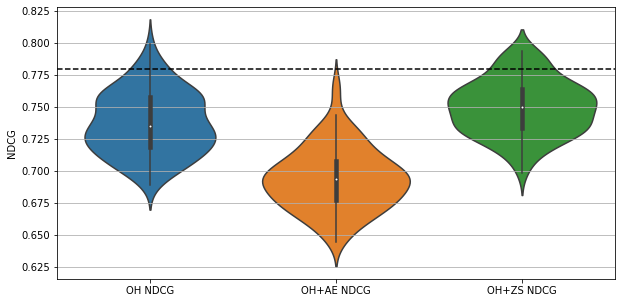

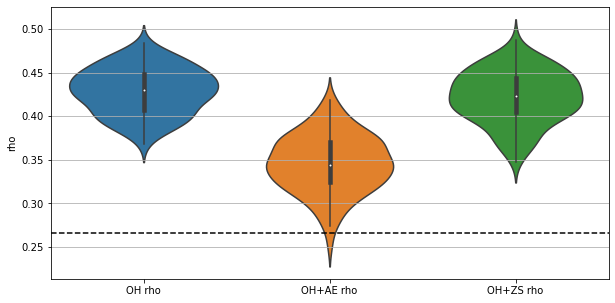

In [58]:
#increasing the NDCG increase ridge model performance
results = pd.DataFrame(data=results, columns= ['OH NDCG', 'OH+AE NDCG', 'OH+ZS NDCG', 'OH rho', 'OH+AE rho','OH+ZS rho'])

plt.figure(figsize=(10,5))
plt.grid()
ax = sns.violinplot(data = results.iloc[:,:3])
plt.axhline(y = ndcg_score([fitness], [scores]), color = 'k', linestyle = '--')
plt.ylabel('NDCG')

plt.figure(figsize=(10,5))
plt.grid()
ax = sns.violinplot(data = results.iloc[:,3:])
plt.axhline(y = spearmanr(fitness, scores)[0], color = 'k', linestyle = '--')
plt.ylabel('rho')

print(np.mean(results, axis =0))


Text(336.9714285714286, 0.5, 'Actual fitness')

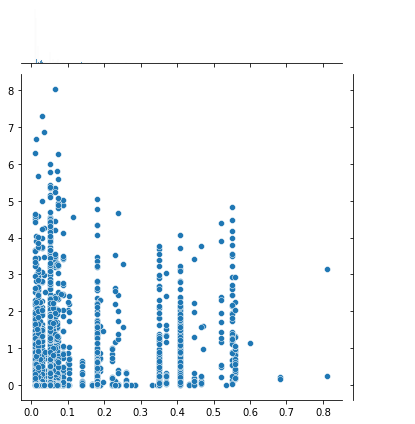

In [41]:
ax = sns.jointplot(x = y_pred_test,y = y_test)
plt.xlabel('Predicted fitness')
plt.ylabel('Actual fitness')

In [50]:
X = np.array(dataset.X)
scaler = StandardScaler()
scaler.fit_transform(X)

array([[-0.18541156, -0.23250265, -0.2205624 , ...,  4.2401094 ,
        -0.23049617, -0.23352468],
       [ 5.3934073 , -0.23250265, -0.2205624 , ...,  4.2401094 ,
        -0.23049617, -0.23352468],
       [-0.18541156,  4.301026  , -0.2205624 , ...,  4.2401094 ,
        -0.23049617, -0.23352468],
       ...,
       [-0.18541156, -0.23250265, -0.2205624 , ..., -0.23584299,
        -0.23049617, -0.23352468],
       [-0.18541156, -0.23250265, -0.2205624 , ..., -0.23584299,
         4.338467  , -0.23352468],
       [-0.18541156, -0.23250265, -0.2205624 , ..., -0.23584299,
        -0.23049617,  4.2822027 ]], dtype=float32)

In [47]:
X

array([[-0.18541156, -0.23250266, -0.22056241, ..., -0.23049616,
        -0.23352467,  1.23894389],
       [ 5.39340705, -0.23250266, -0.22056241, ..., -0.23049616,
        -0.23352467,  1.1111844 ],
       [-0.18541156,  4.30102605, -0.22056241, ..., -0.23049616,
        -0.23352467,  1.09557876],
       ...,
       [-0.18541156, -0.23250266, -0.22056241, ..., -0.23049616,
        -0.23352467, -0.01830571],
       [-0.18541156, -0.23250266, -0.22056241, ...,  4.338467  ,
        -0.23352467, -0.7392068 ],
       [-0.18541156, -0.23250266, -0.22056241, ..., -0.23049616,
         4.28220276, -0.0187083 ]])

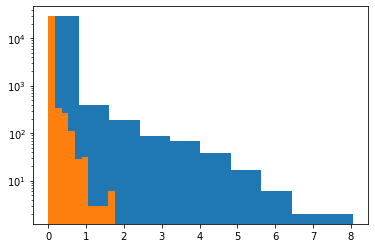

In [24]:
plt.hist(y_test)
plt.hist(y_pred_test)
plt.yscale('log')

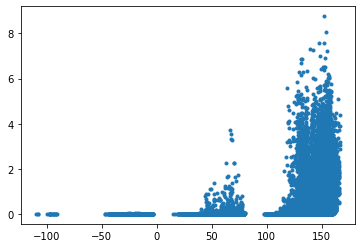

In [25]:
plt.plot(scores, fitness, '.')